# Metapath2Vec SoundCloud Offline Experiments
### Table of Contents:
* [Imports & Data Loading/Processing](#imports)
* [Metapath2Vec Training](#mp2v)

## Imports & Data Loading/Processing <a class="anchor" id="imports"></a>

In [1]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
from typing import Dict, List, Optional, Tuple
from collections import defaultdict, Counter
import pickle
import random
import itertools
import copy
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from scipy.stats import wilcoxon
from sklearn.metrics.pairwise import cosine_similarity
import glob
import os
import polars as pl
import random
import time
import voyager

import torch
from torch_geometric.nn.models import MetaPath2Vec
from torch_geometric.nn import MetaPath2Vec
from torch_geometric.data import HeteroData
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torch_geometric.index import index2ptr
from torch_geometric.typing import EdgeType, NodeType, OptTensor
from torch_geometric.utils import sort_edge_index
from utils.evaluate import soundcloud_eval


### Load BigQuery Tables into GCS Bucket (20.01.25 Partition)

#### Data table descriptions
* [Embeddings](https://console.cloud.google.com/bigquery?project=sc-recommender-prod&inv=1&invt=AbnQkw&ws=!1m5!1m4!4m3!1ssc-recommender-prod!2sviews_daily_latest!3sembeddings)
    * Dataset containing the W2V trained embeddings for each track
* [Listener Embeddings](https://console.cloud.google.com/bigquery?project=sc-recommender-prod&inv=1&invt=AbnQkw&ws=!1m5!1m4!4m3!1ssc-recommender-prod!2sviews_daily_latest!3slistener_embeddings)
    * The weighted average W2V embeddings for each user
* [Follow Affiliations](https://console.cloud.google.com/bigquery?project=sc-recommender-prod&inv=1&invt=AbnRLA&ws=!1m5!1m4!4m3!1ssc-db-dumps!2sfollows!3saffiliations)
    * The user-user follows edges table
* [Creator interactions](https://console.cloud.google.com/bigquery?project=sc-recommender-prod&inv=1&invt=AbnQkw&ws=!1m5!1m4!4m3!1ssc-recommender-prod!2screator_inputs!3screator_interactions)
    * Dataset of user with creator interactions used for training similar-creator model.
    * Creator interactions are created from track interactions (like, play, repost) by transforming a track interaction to an interaction with a creator of a track.
    * For each user we keep a history of 2 years (max 5000) interactions.
* [Track Interactions](https://console.cloud.google.com/bigquery?project=sc-recommender-prod&inv=1&invt=AbnQkw&ws=!1m5!1m4!4m3!1ssc-recommender-prod!2sinputs!3strack_interactions)
    * User interactions with tracks


In [2]:
bq_client = bigquery.Client()
gcs_client = storage.Client()

#### W2V Track Embeddings

In [8]:
%%time
# Track embeddings
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT *
FROM `sc-recommender-prod.views_daily_latest.embeddings`
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'embeddings'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    )
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/embeddings
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/embeddings
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.

CPU times: user 38.7 ms, sys: 3 ms, total: 41.7 ms
Wall time: 35.7 s


#### W2V Average User/Listener Embeddings

In [9]:
# User embeddings
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT * 
FROM `sc-recommender-prod.views_daily_latest.listener_embeddings`
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'listener_embeddings'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/listener_embeddings
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/listener_embeddings
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.



#### Follows Table

In [10]:
# Follows table
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT
    fan_lookup.user_id AS fan,
    contact_lookup.user_id AS contact
FROM `sc-db-dumps.follows.affiliations` AS affiliations
LEFT JOIN `sc-data-pii.hash_lookup_tables.users` AS fan_lookup
    ON affiliations.fan = fan_lookup.user
LEFT JOIN `sc-data-pii.hash_lookup_tables.users` AS contact_lookup
    ON affiliations.contact = contact_lookup.user
WHERE _PARTITIONDATE = CURRENT_DATE() - 1
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'follows_table'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/follows_table
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/follows_table
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.



#### Creator Interactions -- Potentially Not Needed

In [11]:
%%time
# Creator interactions
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT * 
FROM `sc-recommender-prod.creator_inputs.creator_interactions`
WHERE _PARTITIONDATE = CURRENT_DATE() - 1
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'creator_interactions'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/creator_interactions
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/creator_interactions
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.

CPU times: user 67.4 ms, sys: 6.24 ms, total: 73.6 ms
Wall time: 1min 50s


#### Track Interactions

In [12]:
# Track interactions
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT * 
FROM `sc-recommender-prod.inputs.track_interactions`
WHERE _PARTITIONDATE = CURRENT_DATE() - 1
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'track_interactions'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/track_interactions
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/track_interactions
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.



In [3]:
# Track interactions
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT 
    user, 
    interaction.track AS track, 
    interaction.score AS score
FROM `sc-recommender-prod.inputs.track_interactions`,
UNNEST(interactions) AS interaction
WHERE _PARTITIONDATE = DATE('2025-01-20')
  AND TIMESTAMP_SECONDS(interaction.last_interaction) > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 365 DAY);
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'track_interactions_365_days'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/track_interactions_365_days
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/track_interactions_365_days
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.



In [4]:
# Track interactions
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT 
    user, 
    interaction.track AS track, 
    interaction.score AS score
FROM `sc-recommender-prod.inputs.track_interactions`,
UNNEST(interactions) AS interaction
WHERE _PARTITIONDATE = DATE('2025-01-20')
  AND TIMESTAMP_SECONDS(interaction.last_interaction) > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 180 DAY);
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'track_interactions_180_days'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/track_interactions_180_days
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/track_interactions_180_days
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.



In [5]:
# Track interactions
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
sql_query = """
SELECT 
    user, 
    interaction.track AS track, 
    interaction.score AS score
FROM `sc-recommender-prod.inputs.track_interactions`,
UNNEST(interactions) AS interaction
WHERE _PARTITIONDATE = DATE('2025-01-20')
  AND TIMESTAMP_SECONDS(interaction.last_interaction) > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 90 DAY);
"""

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

query_job = bq_client.query(sql_query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'track_interactions_90_days'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/track_interactions_90_days
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/track_interactions_90_days
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.



#### Offline Test set creation

In [13]:
# Offline Evaluation Interactions table
# -----------------------------
# 1) Query and Write to Temp Table
# -----------------------------
config = {'bq_partition_date':'2025-01-23',
          'bq_inputs_dataset':'inputs',
          'bq_interactions_table':'interactions',
          'bq_offline_eval_interactions_dataset':'inputs',
          'bq_offline_eval_start_date':'2025-01-21',
          'bq_offline_eval_end_date':'2025-01-23',
          'bq_offline_eval_partition_date':'2025-01-23',
         }

interactions_data = Interactions(
            window_start_date=config.get('bq_offline_eval_start_date'),
            window_end_date=config.get('bq_offline_eval_end_date'),
            partition_date=config.get('bq_offline_eval_partition_date'),
        )
query = interactions_data.full_query().render_using_with()

destination_table = "sc-recommender-stage.sachinresearch.temporary_table"
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)
query_job = bq_client.query(query, job_config=job_config)
query_job.result()
print(f"Query results saved to table: {destination_table}")

# -----------------------------
# 2) Export to GCS
# -----------------------------
bucket_name = 'sc-reco-stage-sachin'
folder = 'offline_eval_interactions'

uri = f"gs://{bucket_name}/{folder}/*.parquet"

extract_job = bq_client.extract_table(
    destination_table,
    uri,
    location="EU",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET,
        compression=bigquery.Compression.SNAPPY,
    ),
)
extract_job.result()
print(f"Table exported to GCS: {bucket_name}/{folder}")

# -----------------------------
# 3) Clean up BQ Temporary Table
# -----------------------------
bq_client.delete_table(destination_table, not_found_ok=True)
print(f"Deleted temporary table: {destination_table}")

print(f"""
All done!
- Data was exported to gs://{bucket_name}/{folder}
- BQ table {destination_table} was deleted.
""")

Query results saved to table: sc-recommender-stage.sachinresearch.temporary_table
Table exported to GCS: sc-reco-stage-sachin/offline_eval_interactions
Deleted temporary table: sc-recommender-stage.sachinresearch.temporary_table

All done!
- Data was exported to gs://sc-reco-stage-sachin/offline_eval_interactions
- BQ table sc-recommender-stage.sachinresearch.temporary_table was deleted.



### Visualize embeddings

In [14]:
%%time
bucket_name = 'sc-reco-stage-sachin'
folder = 'embeddings'

fs = gcsfs.GCSFileSystem()
ddf = dd.read_parquet(f"gs://{bucket_name}/{folder}/*.parquet", 
                      engine="pyarrow", filesystem=fs)

CPU times: user 568 ms, sys: 99.3 ms, total: 668 ms
Wall time: 12.2 s


In [15]:
%%time
def clean_and_stack_embeddings(df):
    """
    Filter and process the 'embedding' column in one step:
    - Remove rows with 'foo' (bs string).
    - Keep only valid embeddings of length 150.
    - Return a single-column DataFrame for valid embeddings.
    """
    def is_valid(embedding):
        return isinstance(embedding, (list, np.ndarray)) and len(embedding) == 150

    valid_embeddings = df["embedding"].apply(lambda x: is_valid(x) and x != "foo")
    df = df[valid_embeddings]

    # Return a single-column DataFrame with valid embeddings
    return pd.DataFrame({"embedding": df["embedding"]})

# Define the meta (output structure) for Dask
meta = pd.DataFrame({"embedding": pd.Series(dtype=object)})

# Apply the cleaning and processing in one step
cleaned_partitions = ddf.map_partitions(clean_and_stack_embeddings, meta=meta).compute()

# Combine all valid embeddings into a single 2D NumPy array
embeddings = np.vstack(cleaned_partitions["embedding"].to_list())  # Stack all embeddings
print(f"Embeddings shape: {embeddings.shape}")

Embeddings shape: (25841871, 150)
CPU times: user 4min 18s, sys: 53.6 s, total: 5min 11s
Wall time: 2min 50s


In [16]:
%%time

# Create an IncrementalPCA instance
ipca = IncrementalPCA(n_components=2, batch_size=500000)  # Adjust batch size if needed

# Fit and transform the data in-memory
X_2d = ipca.fit_transform(embeddings)  # Shape: (25841871, 2)

print(f"Reduced shape: {X_2d.shape}")

Reduced shape: (25841871, 2)
CPU times: user 35min 46s, sys: 6min 45s, total: 42min 31s
Wall time: 5min 17s


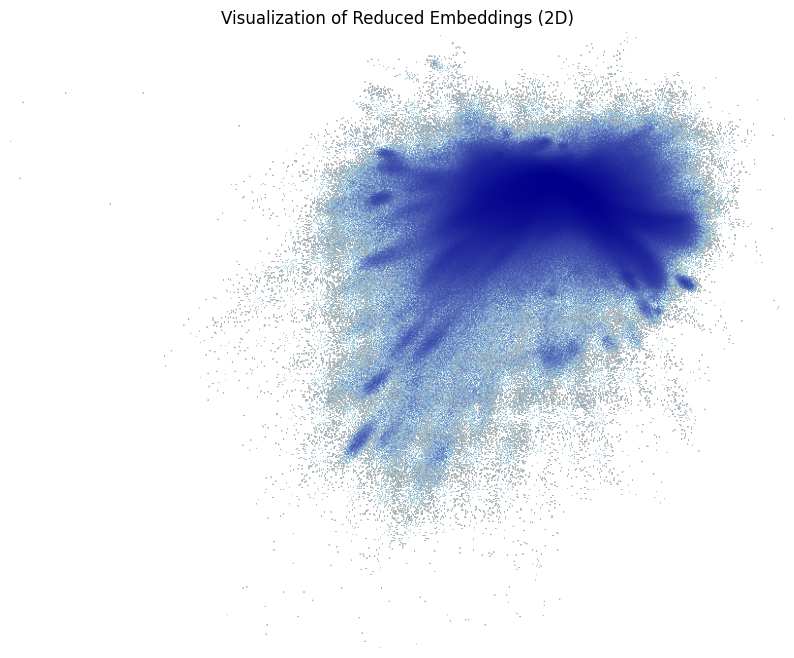

In [19]:
# Convert to Pandas DataFrame for Datashader
df_2d = pd.DataFrame(X_2d, columns=["pc1", "pc2"])

# Datashader visualization
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(df_2d, "pc1", "pc2", ds.count())
img = tf.shade(agg, cmap=["lightblue", "darkblue"])

# Display using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(img.to_pil(), aspect="auto")
plt.title("Visualization of Reduced Embeddings (2D)")
plt.axis("off")
plt.show()

In [27]:
import gc
del df_2d
del embeddings
del X_2d
del ddf
del cleaned_partitions
gc.collect()

12973

### Inspect Data Size

In [22]:
!gsutil du -sh gs://sc-reco-stage-sachin/embeddings

22.6 GiB     gs://sc-reco-stage-sachin/embeddings


In [24]:
!gsutil du -sh gs://sc-reco-stage-sachin/listener_embeddings

128.66 GiB   gs://sc-reco-stage-sachin/listener_embeddings


In [26]:
!gsutil du -sh gs://sc-reco-stage-sachin/follows_table

59.32 GiB    gs://sc-reco-stage-sachin/follows_table


In [23]:
!gsutil du -sh gs://sc-reco-stage-sachin/creator_interactions

139.49 GiB   gs://sc-reco-stage-sachin/creator_interactions


In [21]:
!gsutil du -sh gs://sc-reco-stage-sachin/track_interactions

253.26 GiB   gs://sc-reco-stage-sachin/track_interactions


In [6]:
!gsutil du -sh gs://sc-reco-stage-sachin/track_interactions_365_days

176.88 GiB   gs://sc-reco-stage-sachin/track_interactions_365_days


In [7]:
!gsutil du -sh gs://sc-reco-stage-sachin/track_interactions_180_days

101.85 GiB   gs://sc-reco-stage-sachin/track_interactions_180_days


In [8]:
!gsutil du -sh gs://sc-reco-stage-sachin/track_interactions_90_days

54.93 GiB    gs://sc-reco-stage-sachin/track_interactions_90_days


In [25]:
!gsutil du -sh gs://sc-reco-stage-sachin/offline_eval_interactions

4.77 GiB     gs://sc-reco-stage-sachin/offline_eval_interactions


## Metapath2Vec Training <a class="anchor" id="mp2v"></a>

### Create Adjacency List

In [2]:
%%time
# Get number of nodes
with open("SoundCloud/user2idx.pkl", "rb") as f:
    user2idx = pickle.load(f) # 2.6 Gb
with open("SoundCloud/track2idx.pkl", "rb") as f:
    track2idx = pickle.load(f) # 0.6 Gb
num_users = len(user2idx)
num_tracks = len(track2idx)
del user2idx, track2idx

CPU times: user 52 s, sys: 12.9 s, total: 1min 4s
Wall time: 1min 6s


In [40]:
%%time
# Requires ~175 Gb RAM
# Create graph
data = HeteroData()
data['user'].num_nodes = num_users
data['track'].num_nodes = num_tracks
edge_index_ut = np.load('SoundCloud/edge_index_ut_90.npy') # 36 Gb
data['user', 'listens', 'track'].edge_index = torch.tensor(edge_index_ut, dtype=torch.long)
# Include reverse edges too:
data['track', 'listened_by', 'user'].edge_index = torch.tensor(edge_index_ut[:, [1,0]], dtype=torch.long)
del edge_index_ut
edge_index_uu = np.load('SoundCloud/edge_index_uu.npy') # 19 Gb
data['user', 'follows', 'user'].edge_index = torch.tensor(edge_index_uu, dtype=torch.long)
del edge_index_uu

CPU times: user 43.6 s, sys: 1min 53s, total: 2min 37s
Wall time: 20.2 s


In [41]:
import torch
import pickle
import numpy as np
import numba
from torch_geometric.data import HeteroData

@numba.njit(parallel=True)
def fill_col(src, dst, insertion_ptr, col):
    """
    Numba JIT function:
    For each edge i, we look up src[i], find insertion_ptr for that src node,
    and place dst[i] in col[pos], then increment insertion_ptr.
    """
    for i in numba.prange(len(src)):
        s = src[i]
        pos = insertion_ptr[s]
        col[pos] = dst[i]
        insertion_ptr[s] = pos + 1

def build_csr_two_pass_numba(src: np.ndarray, dst: np.ndarray, num_src: int):
    """
    Build (rowptr, col) for edges (src[i], dst[i]) in two passes:
      1) Count how many edges each source node has (np.bincount).
      2) Prefix sum -> rowptr, then fill col array via fill_col.

    Returns:
      rowptr: shape [num_src + 1]
      col: shape [len(src)]
    """
    # 1) row_count: how many edges each source node has
    row_count = np.bincount(src, minlength=num_src)

    # 2) rowptr = prefix sum
    rowptr = np.zeros(num_src + 1, dtype=np.int64)
    np.cumsum(row_count, out=rowptr[1:])

    # 3) Build col array
    col = np.zeros(len(src), dtype=np.int64)
    insertion_ptr = rowptr.copy()

    # 4) Fill
    fill_col(src, dst, insertion_ptr, col)

    return rowptr, col

def build_and_save_adjacency_numba(data: HeteroData, save_path: str):
    """
    For each edge_type in data.edge_index_dict,
    builds a CSR adjacency (rowptr, col, rowcount) using a two-pass approach
    optimized by Numba. Assumes edge_index is shape [E, 2] (i.e., each row is [src, dst]).

    Saves adjacency dicts to 'save_path' for quick future loading.
    """
    # Gather node counts for each node type
    num_nodes_dict = {}
    for node_type in data.node_types:
        num_nodes_dict[node_type] = data[node_type].num_nodes

    rowptr_dict = {}
    col_dict = {}
    rowcount_dict = {}

    # Iterate over each edge_type in data
    for keys, edge_index in data.edge_index_dict.items():
        src_type, rel_type, dst_type = keys
        src_size = num_nodes_dict[src_type]
        dst_size = num_nodes_dict[dst_type]

        # edge_index: shape (E, 2)
        edge_index_cpu = edge_index.cpu().numpy()  # shape [E, 2]
        # src = first column, dst = second column
        src = edge_index_cpu[:, 0]
        dst = edge_index_cpu[:, 1]

        # Build adjacency
        rowptr_np, col_np = build_csr_two_pass_numba(src, dst, num_src=src_size)
        rowcount_np = rowptr_np[1:] - rowptr_np[:-1]

        # Convert to torch tensors
        rowptr_t = torch.from_numpy(rowptr_np)
        col_t = torch.from_numpy(col_np)
        rowcount_t = torch.from_numpy(rowcount_np)

        # Store in dict
        rowptr_dict[keys] = rowptr_t
        col_dict[keys] = col_t
        rowcount_dict[keys] = rowcount_t

        print(f"Processed edge type {keys} with {len(src)} edges.")
    edge_weight_dict = {
            ('user','listens','track'): data['user','listens','track'].edge_weight,
            ('track','listened_by','user'): data['track','listened_by','user'].edge_weight,
            ('user','follows','user'): None,
    }

    # Build final output
    save_dict = {
        "rowptr_dict": rowptr_dict,
        "col_dict": col_dict,
        "rowcount_dict": rowcount_dict,
        "num_nodes_dict": num_nodes_dict,
        "edge_weights_dict": edge_weight_dict
    }

    # Save to disk
    with open(save_path, "wb") as f:
        pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Saved adjacency structures (Numba two-pass) to: {save_path}")

In [42]:
%%time
build_and_save_adjacency_numba(
    data,
    save_path="SoundCloud/mp2vec_adj_numbatwopass.pkl"
)

### Sample training

In [2]:
%%time
with open("SoundCloud/adj_data_90_sampled.pkl", "rb") as f:
    adj_data = pickle.load(f)

CPU times: user 1.46 s, sys: 7.26 s, total: 8.73 s
Wall time: 50.2 s


In [3]:
%%time
from models.metapath2vec import MetaPath2Vec
from utils.evaluate import soundcloud_eval
clock = time.time()
device = 'cuda'
batch_size = 3500
epochs = 2
metapath = [
    ('user', 'follows', 'user'),
    ('user', 'listens', 'track'),
    ('track', 'listened_by', 'user')
]
model = MetaPath2Vec(
            adj_data,
            embedding_dim=150,
            metapath=metapath,
            walk_length=15,
            context_size=4,
            walks_per_node=15,
            num_negative_samples=7,
            sparse=True
        ).to(device)
del adj_data
print(f'Model created ({time.time() - clock})')

In [4]:
clock = time.time()
# Initialize embeddings
#user_embeddings = torch.tensor(np.load('SoundCloud/user_embeddings.npy'), dtype=torch.float32) # 64 Gb
#track_embeddings = torch.tensor(np.load('SoundCloud/track_embeddings.npy'), dtype=torch.float32) # 15 Gb
#with torch.no_grad():
    #model('track').data.copy_(track_embeddings)
    #model('user').data.copy_(user_embeddings)
#del user_embeddings, track_embeddings
#print(f'Embeddings initialized ({time.time() - clock})')
#clock = time.time()

loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=64)
optimizer = torch.optim.SparseAdam([p for p in model.parameters()], lr=0.02)
print(f'n batches: {len(loader)}')
def train_one_epoch():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        pos_rw, neg_rw = pos_rw.to(device), neg_rw.to(device)
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

# Load validation & test set
with open("SoundCloud/val_data.pkl", "rb") as f:
    val_data = pickle.load(f) # 0.34 Gb
with open("SoundCloud/test_data.pkl", "rb") as f:
    test_data = pickle.load(f) # 1.1 Gb
print(f'Val & Test Loaded ({time.time() - clock})')
clock = time.time()


loss = train_one_epoch()
print(f'Trained 1 epoch ({time.time()-clock})')
clock = time.time()

model.eval()
track_emb = model('track').cpu().detach().numpy()
print(f'Retrieved track embeddings ({time.time()-clock})')
clock = time.time()
user_emb = model('user').cpu().detach().numpy()
print(f'Retrieved user embs ({time.time()-clock})')
clock = time.time()
val_metrics = soundcloud_eval(
        user_emb=user_emb,
        item_emb=track_emb,
        val_data=val_data,
        test_data=test_data,
        is_validation=True,
        top_k=[1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        progress_bar=True
    )
print(f'Val evaluation done ({time.time()-clock})')
print(f'Epoch: {epoch}, Loss: {loss}, metrics: {val_metrics}')

n batches: 11385
Val & Test Loaded (102.64334011077881)



KeyboardInterrupt



In [8]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import numpy as np
import math
import multiprocessing
import voyager

#################### SOUNDCLOUD ####################
    
def build_voyager_index(track_emb, batch_size=13_000_000, ef_construction=90):
    """
    Build a Voyager index from track_emb in batches.
    :param track_emb: np.ndarray of shape [num_tracks, dim].
    :param batch_size: Number of embeddings to add per batch.
    :param ef_construction: Voyager parameter controlling index build speed vs. quality.
    """
    num_tracks, dim = track_emb.shape

    # Create a Voyager index
    index = voyager.Index(
        space=voyager.Space.Euclidean,
        num_dimensions=dim,
        max_elements=num_tracks,
        ef_construction=ef_construction
    )
    
    for i in range(0, num_tracks, batch_size):
        batch = track_emb[i : i + batch_size]
        index.add_items(batch)
    
    return index

# -----------------------------
# Global variables for multiprocessing
# -----------------------------
GLOBAL_USER_EMB = None           # np.array: [num_users, dim]
GLOBAL_VOYAGER = None            # Voyager index (already built)
GLOBAL_VAL_DATA = None           # dict: user_id -> set of relevant item indices
GLOBAL_TEST_DATA = None          # dict: user_id -> set of relevant item indices
GLOBAL_TOPK_LIST = None          # A list of top-K values, e.g. [1, 5, 10, 20]
GLOBAL_IS_VALIDATION = True
GLOBAL_TOPK_MAX = None           # max of top_k list

def _init_globals(user_emb, voyager_index, val_data, test_data,
                  top_k_list, is_validation, top_k_max):
    """
    Initializer for each child process: sets globals for shared data (via fork).
    """
    global GLOBAL_USER_EMB, GLOBAL_VOYAGER, GLOBAL_VAL_DATA
    global GLOBAL_TEST_DATA, GLOBAL_TOPK_LIST, GLOBAL_IS_VALIDATION
    global GLOBAL_TOPK_MAX

    GLOBAL_USER_EMB = user_emb
    GLOBAL_VOYAGER = voyager_index
    GLOBAL_VAL_DATA = val_data
    GLOBAL_TEST_DATA = test_data
    GLOBAL_TOPK_LIST = top_k_list
    GLOBAL_IS_VALIDATION = is_validation
    GLOBAL_TOPK_MAX = top_k_max

def _eval_worker_batch(user_list):
    """
    Worker function that processes a batch of user IDs at once.
    Performs a single query with k=top_k_max, then for each user
    computes recall and nDCG for all k in top_k_list.
    
    Returns:
      (sum_recall_dict, sum_ndcg_dict, count) for the batch.
      sum_recall_dict[k] = total recall for that k
      sum_ndcg_dict[k]   = total ndcg for that k
      count = #users processed
    """
    user_emb        = GLOBAL_USER_EMB
    voyager_index   = GLOBAL_VOYAGER
    val_data        = GLOBAL_VAL_DATA
    test_data       = GLOBAL_TEST_DATA
    top_k_list      = GLOBAL_TOPK_LIST
    top_k_max       = GLOBAL_TOPK_MAX
    is_validation   = GLOBAL_IS_VALIDATION

    # We fetch from val_data or test_data for "relevant" items:
    relevant_dict   = val_data if is_validation else test_data
    other_dict      = test_data if is_validation else val_data

    # Prepare query matrix:
    batch_queries = np.stack([user_emb[u] for u in user_list])  # shape [B, dim]

    # Single batch query with k=top_k_max
    neighbors_batch, _ = voyager_index.query(batch_queries, k=top_k_max)

    # For each top_k in top_k_list, we'll accumulate sums of recall and ndcg
    sum_recall_dict = {k: 0.0 for k in top_k_list}
    sum_ndcg_dict   = {k: 0.0 for k in top_k_list}

    count = 0

    # Cache for IDCG calculations
    idcg_cache = {}
    def get_idcg(r_size, k):
        cut = min(k, r_size)
        # Use a tuple key in the dictionary
        if (cut, k) not in idcg_cache:
            s = 0.0
            for i in range(cut):
                s += 1.0 / log2(i + 2)
            idcg_cache[(cut, k)] = s
        return idcg_cache[(cut, k)]

    # Process each user in the batch
    for i, u in enumerate(user_list):
        relevant_set = relevant_dict.get(u, set())
        if not relevant_set:
            continue
        other_set = other_dict.get(u, set())

        # neighbors_batch[i] is length=top_k_max
        nn_indices = neighbors_batch[i].tolist()

        # We build a final ranked list by skipping "other" set
        ranked_items = []
        for idx in nn_indices:
            if idx not in other_set:
                ranked_items.append(idx)
            if len(ranked_items) == top_k_max:
                break

        # Identify positions of hits in 'ranked_items'
        # (which are relevant to this user)
        hits_positions = [rank for rank, vid in enumerate(ranked_items)
                          if vid in relevant_set]

        # For each top_k in top_k_list, compute recall and nDCG
        r_size = len(relevant_set)
        for k in top_k_list:
            # Count how many hits are within the top-k portion
            hits_within_k = sum(1 for pos in hits_positions if pos < k)
            recall = hits_within_k / float(min(k, r_size))

            # Compute the DCG over positions < k
            dcg = 0.0
            for pos in hits_positions:
                if pos < k:
                    dcg += 1.0 / log2(pos + 2)
            idcg = get_idcg(r_size, k)
            ndcg = (dcg / idcg) if idcg > 0 else 0.0

            sum_recall_dict[k] += recall
            sum_ndcg_dict[k]   += ndcg

        count += 1

    return (sum_recall_dict, sum_ndcg_dict, count)

def evaluate_user_reco_approx_multiproc(user_emb,
                                        voyager_index,
                                        val_data,
                                        test_data,
                                        top_k_list=[100],
                                        is_validation=True,
                                        n_proc=64,
                                        progress_bar=True):
    """
    Evaluate user recommendations in parallel using multiprocessing and a shared Voyager index.
    
    Args:
      user_emb (np.ndarray): shape [num_users, dim].
      voyager_index: A prebuilt Voyager index with a batch query method `.query(query_matrix, k=k)`.
      val_data (dict): user->set of relevant items (for validation).
      test_data (dict): user->set of relevant items (for testing).
      top_k_list (list): e.g. [1, 5, 10, 20, 50, 100].
      is_validation (bool): If True, evaluate on val_data; else test_data.
      n_proc (int): number of processes to spawn.
      progress_bar (bool): if True, shows a tqdm progress bar over chunks.
      
    Returns:
      A dict of the form:
        {
          "Recall@1":  R1, "Recall@5":  R5, ...
          "NDCG@1":    N1, "NDCG@5":    N5, ...
        }
      containing average recall and ndcg for each K in top_k_list.
    """
    top_k_max = max(top_k_list)

    # Build list of user IDs
    relevant_dict = val_data if is_validation else test_data
    user_ids = list(relevant_dict.keys())

    # Split user_ids into n_proc chunks
    total_users = len(user_ids)
    chunk_size = max(1, total_users // n_proc)
    chunks = [user_ids[i:i+chunk_size] for i in range(0, total_users, chunk_size)]

    # Start a multiprocessing pool
    ctx = multiprocessing.get_context("fork")
    with ctx.Pool(
        processes=n_proc,
        initializer=_init_globals,
        initargs=(user_emb, voyager_index, val_data, test_data,
                  top_k_list, is_validation, top_k_max)
    ) as pool:
        if progress_bar:
            results = list(tqdm(pool.imap(_eval_worker_batch, chunks),
                                total=len(chunks),
                                desc="Evaluating users"))
        else:
            results = list(pool.imap(_eval_worker_batch, chunks))

    # Combine results
    sum_recall_dict = {k: 0.0 for k in top_k_list}
    sum_ndcg_dict   = {k: 0.0 for k in top_k_list}
    user_count = 0

    for (partial_recall_dict, partial_ndcg_dict, cnt) in results:
        for k in top_k_list:
            sum_recall_dict[k] += partial_recall_dict[k]
            sum_ndcg_dict[k]   += partial_ndcg_dict[k]
        user_count += cnt

    if user_count == 0:
        return {f"Recall@{k}": 0.0 for k in top_k_list} | {f"NDCG@{k}": 0.0 for k in top_k_list}

    # Compute final averages
    recall_avg = {f"Recall@{k}": (sum_recall_dict[k] / user_count) for k in top_k_list}
    ndcg_avg   = {f"NDCG@{k}":   (sum_ndcg_dict[k]   / user_count) for k in top_k_list}

    return recall_avg | ndcg_avg

def soundcloud_eval(user_emb, item_emb, val_data, test_data,
                    top_k=[100],
                    is_validation=True, progress_bar=True):
    """
      1) Build a Voyager index from track_emb
      2) Evaluate user_emb via approximate nearest neighbor queries
      3) Return metrics for each K in top_k_list
    """
    track_emb = item_emb
    # 1) Build the Voyager index:
    index = build_voyager_index(track_emb)
    del track_emb

    # 2) Evaluate via multi-process approach:
    metrics = evaluate_user_reco_approx_multiproc(
        user_emb      = user_emb,
        voyager_index = index,
        val_data      = val_data,
        test_data     = test_data,
        top_k_list    = top_k,
        is_validation = is_validation,
        n_proc        = multiprocessing.cpu_count(),
        progress_bar  = progress_bar
    )
    del user_emb
    return metrics


In [7]:
import math
import numpy as np
import multiprocessing
from tqdm import tqdm

# Global variables for multiprocessing evaluation (shared via fork)
GLOBAL_USER_EMB = None           # np.array: [num_users, dim]
GLOBAL_VOYAGER = None             # Voyager index (already built) with a batch query interface
GLOBAL_VAL_DATA = None            # dict: user_id -> set of relevant video indices
GLOBAL_TEST_DATA = None           # dict: user_id -> set of test video indices
GLOBAL_TOPK = None
GLOBAL_IS_VALIDATION = True

def _init_globals(user_emb, voyager_index, val_data, test_data, top_k, is_validation):
    """Initializer for each child process: sets globals for shared data."""
    global GLOBAL_USER_EMB, GLOBAL_VOYAGER, GLOBAL_VAL_DATA, GLOBAL_TEST_DATA, GLOBAL_TOPK, GLOBAL_IS_VALIDATION
    GLOBAL_USER_EMB = user_emb
    GLOBAL_VOYAGER = voyager_index
    GLOBAL_VAL_DATA = val_data
    GLOBAL_TEST_DATA = test_data
    GLOBAL_TOPK = top_k
    GLOBAL_IS_VALIDATION = is_validation

def _eval_worker_batch(user_list):
    """
    Worker function that processes a batch of user IDs at once.
    
    For the given list of users, it builds a 2D query matrix from their embeddings,
    performs a batch query on the shared Voyager index, then for each user filters 
    the results and computes HR@k and nDCG@k.
    
    Returns:
        (sum_hr, sum_ndcg, count) for the batch.
    """
    from math import log2

    # Retrieve globals.
    user_emb = GLOBAL_USER_EMB
    voyager_index = GLOBAL_VOYAGER   # Must support batch queries: .query(query_matrix, k=k)
    val_data = GLOBAL_VAL_DATA
    test_data = GLOBAL_TEST_DATA
    top_k = GLOBAL_TOPK
    is_validation = GLOBAL_IS_VALIDATION

    # Use the appropriate relevant/other dictionary.
    relevant_dict = val_data if is_validation else test_data
    other_dict = test_data if is_validation else val_data

    # Build a 2D query matrix from the user embeddings in this batch.
    batch_queries = np.stack([user_emb[u] for u in user_list])  # shape [B, dim]
    
    # Perform a single batch query.
    # We assume voyager_index.query(query_matrix, k=k) returns (neighbors, distances),
    # where neighbors is an array of shape [B, k].
    neighbors_batch, _ = voyager_index.query(batch_queries, k=top_k)
    
    sum_hr = 0.0
    sum_ndcg = 0.0
    count = 0
    
    # Cache for IDCG calculations.
    idcg_cache = {}
    def get_idcg(r_size):
        cut = min(top_k, r_size)
        if cut not in idcg_cache:
            s = 0.0
            for i in range(cut):
                s += 1.0 / log2(i + 2)
            idcg_cache[cut] = s
        return idcg_cache[cut]
    
    # Process each user in the batch.
    for i, u in enumerate(user_list):
        relevant_set = relevant_dict.get(u, set())
        if not relevant_set:
            continue
        other_set = other_dict.get(u, set())
        
        # Convert the i-th row of neighbors to a list.
        nn_indices = neighbors_batch[i].tolist()
        
        # Filter out items that are in the "other" set.
        ranked_items = []
        for idx in nn_indices:
            if idx not in other_set:
                ranked_items.append(idx)
                if len(ranked_items) == top_k:
                    break
        
        # Compute HR@k and nDCG@k.
        hits_positions = [rank for rank, vid in enumerate(ranked_items) if vid in relevant_set]
        hits_count = len(hits_positions)
        hr = hits_count / float(min(top_k, len(relevant_set)))
        dcg = sum(1.0 / log2(pos + 2) for pos in hits_positions)
        idcg = get_idcg(len(relevant_set))
        ndcg = (dcg / idcg) if idcg > 0 else 0.0
        
        sum_hr += hr
        sum_ndcg += ndcg
        count += 1
    
    return (sum_hr, sum_ndcg, count)

def evaluate_user_reco_approx_multiproc(user_emb,
                                        voyager_index,
                                        val_data,
                                        test_data,
                                        is_validation=True,
                                        top_k=100,
                                        n_proc=64):
    """
    Evaluate user recommendations in parallel using multiprocessing and a shared Voyager index.
    
    Args:
      user_emb (np.ndarray): Array of shape [num_users, dim].
      voyager_index: A prebuilt Voyager index with a batch query method:
                     .query(query_matrix, k=k) returns (neighbors, distances).
      val_data: dict mapping user_id -> set of relevant video indices.
      test_data: dict mapping user_id -> set of test video indices.
      is_validation (bool): If True, evaluate using val_data; else test_data.
      top_k (int): Number of nearest neighbors to retrieve.
      n_proc (int): Number of processes to spawn.
      
    Returns:
      dict with {f'HR@{top_k}': hr_avg, f'NDCG@{top_k}': ndcg_avg}.
    """
    # Build the list of user IDs from the relevant dictionary.
    relevant_dict = val_data if is_validation else test_data
    user_ids = list(relevant_dict.keys())
    
    # Split user_ids into n_proc chunks.
    total_users = len(user_ids)
    chunk_size = max(1, total_users // n_proc)
    chunks = [user_ids[i:i+chunk_size] for i in range(0, total_users, chunk_size)]
    
    # Initialize a multiprocessing pool using fork so that globals are shared.
    ctx = multiprocessing.get_context("fork")
    with ctx.Pool(processes=n_proc,
                  initializer=_init_globals,
                  initargs=(user_emb, voyager_index, val_data, test_data, top_k, is_validation)
                 ) as pool:
        # Use imap directly (no lambda) with tqdm for a progress bar.
        results = list(tqdm(pool.imap(_eval_worker_batch, chunks),
                            total=len(chunks),
                            desc="Evaluating users"))
    
    # Combine results.
    total_hr, total_ndcg, user_count = 0.0, 0.0, 0
    for (sum_hr, sum_ndcg, cnt) in results:
        total_hr += sum_hr
        total_ndcg += sum_ndcg
        user_count += cnt

    if user_count == 0:
        return {f'HR@{top_k}': 0.0, f'NDCG@{top_k}': 0.0}
    hr_avg = total_hr / user_count
    ndcg_avg = total_ndcg / user_count
    return {f'HR@{top_k}': hr_avg, f'NDCG@{top_k}': ndcg_avg}

In [14]:
import math
import numpy as np
import multiprocessing
from tqdm import tqdm

# Global variables for multiprocessing evaluation (shared via fork)
GLOBAL_USER_EMB = None           # np.array: [num_users, dim]
GLOBAL_VOYAGER = None             # Voyager index (already built) with a batch query interface
GLOBAL_VAL_DATA = None            # dict: user_id -> set of relevant video indices
GLOBAL_TEST_DATA = None            # dict: user_id -> set of test video indices
GLOBAL_TOPK = None
GLOBAL_IS_VALIDATION = True

def _init_globals(user_emb, voyager_index, val_data, test_data, top_k, is_validation):
    """Initializer for each child process: sets globals for shared data."""
    global GLOBAL_USER_EMB, GLOBAL_VOYAGER, GLOBAL_VAL_DATA, GLOBAL_TEST_DATA, GLOBAL_TOPK, GLOBAL_IS_VALIDATION
    GLOBAL_USER_EMB = user_emb
    GLOBAL_VOYAGER = voyager_index
    GLOBAL_VAL_DATA = val_data
    GLOBAL_TEST_DATA = test_data
    GLOBAL_TOPK = top_k
    GLOBAL_IS_VALIDATION = is_validation

def _eval_worker_batch(user_list):
    """
    Worker function that processes a batch of user IDs at once.
    
    For the given list of users, it builds a 2D query matrix from their embeddings,
    performs a batch query on the shared Voyager index, then for each user filters 
    the results (if needed) and computes HR@k and nDCG@k.
    
    Returns:
        (sum_hr, sum_ndcg, count) for the batch.
    """
    from math import log2

    # Retrieve globals.
    user_emb = GLOBAL_USER_EMB
    voyager_index = GLOBAL_VOYAGER   # Must support batch queries: .query(query_matrix, k=k)
    val_data = GLOBAL_VAL_DATA
    test_data = GLOBAL_TEST_DATA
    top_k = GLOBAL_TOPK
    is_validation = GLOBAL_IS_VALIDATION

    # Use the appropriate relevant/other dict.
    relevant_dict = val_data if is_validation else test_data
    other_dict = test_data if is_validation else val_data

    # Build a 2D query matrix from the user embeddings in this batch.
    batch_queries = np.stack([user_emb[u] for u in user_list])  # shape [B, dim]
    
    # Perform a single batch query.
    # Voyager's query interface is assumed to be: 
    #   voyager_index.query(query_matrix, k=k) -> (neighbors, distances)
    # where neighbors is an array of shape [B, k]
    neighbors_batch, _ = voyager_index.query(batch_queries, k=top_k)
    
    sum_hr = 0.0
    sum_ndcg = 0.0
    count = 0
    
    # Cache for IDCG calculations.
    idcg_cache = {}
    def get_idcg(r_size):
        cut = min(top_k, r_size)
        if cut not in idcg_cache:
            s = 0.0
            for i in range(cut):
                s += 1.0 / log2(i + 2)
            idcg_cache[cut] = s
        return idcg_cache[cut]
    
    # Process each user in the batch.
    for i, u in enumerate(user_list):
        relevant_set = relevant_dict.get(u, set())
        if not relevant_set:
            continue
        other_set = other_dict.get(u, set())
        
        # Convert the i-th row of neighbors to a list.
        nn_indices = neighbors_batch[i].tolist()
        
        # Filter out items in the "other" set.
        ranked_items = []
        for idx in nn_indices:
            if idx not in other_set:
                ranked_items.append(idx)
                if len(ranked_items) == top_k:
                    break
        
        # Compute HR@k and nDCG@k.
        hits_positions = [rank for rank, vid in enumerate(ranked_items) if vid in relevant_set]
        hits_count = len(hits_positions)
        hr = hits_count / float(min(top_k, len(relevant_set)))
        dcg = sum(1.0 / log2(pos + 2) for pos in hits_positions)
        idcg = get_idcg(len(relevant_set))
        ndcg = (dcg / idcg) if idcg > 0 else 0.0
        
        sum_hr += hr
        sum_ndcg += ndcg
        count += 1
    
    return (sum_hr, sum_ndcg, count)

def evaluate_user_reco_approx_multiproc(user_emb,
                                        voyager_index,
                                        val_data,
                                        test_data,
                                        is_validation=True,
                                        top_k=100,
                                        n_proc=64):
    """
    Evaluate user recommendations in parallel using multiprocessing and a shared Voyager index.
    
    Args:
      user_emb (np.ndarray): Array of shape [num_users, dim].
      voyager_index: A prebuilt Voyager index with a batch query method:
                     .query(query_matrix, k=k) returns (neighbors, distances).
      val_data: dict mapping user_id -> set of relevant video indices.
      test_data: dict mapping user_id -> set of test video indices.
      is_validation (bool): If True, evaluate using val_data; else test_data.
      top_k (int): Number of nearest neighbors to retrieve.
      n_proc (int): Number of processes to spawn.
      
    Returns:
      dict with {f'HR@{top_k}': hr_avg, f'NDCG@{top_k}': ndcg_avg}.
    """
    # Build the list of user IDs from the relevant dictionary.
    relevant_dict = val_data if is_validation else test_data
    user_ids = list(relevant_dict.keys())
    
    # Split user_ids into n_proc chunks.
    total_users = len(user_ids)
    chunk_size = max(1, total_users // n_proc)
    chunks = [user_ids[i:i+chunk_size] for i in range(0, total_users, chunk_size)]
    
    # Initialize a multiprocessing pool using fork.
    ctx = multiprocessing.get_context("fork")
    with ctx.Pool(processes=n_proc,
                  initializer=_init_globals,
                  initargs=(user_emb, voyager_index, val_data, test_data, top_k, is_validation)
                 ) as pool:
        # Use imap with tqdm for a progress bar.
        results = list(tqdm(pool.imap(_eval_worker_batch, chunks),
                            total=len(chunks),
                            desc="Evaluating users"))
    
    # Combine results.
    total_hr, total_ndcg, user_count = 0.0, 0.0, 0
    for (sum_hr, sum_ndcg, cnt) in results:
        total_hr += sum_hr
        total_ndcg += sum_ndcg
        user_count += cnt

    if user_count == 0:
        return {f'HR@{top_k}': 0.0, f'NDCG@{top_k}': 0.0}
    hr_avg = total_hr / user_count
    ndcg_avg = total_ndcg / user_count
    return {f'HR@{top_k}': hr_avg, f'NDCG@{top_k}': ndcg_avg}

In [13]:
def create_toy_data(num_users=1000000, num_videos=500000, dim=10):
    """
    Create toy user embeddings and dummy evaluation dictionaries.
    Here we assume user IDs and video IDs are integers, and that each user’s 
    "relevant" items are a random set of video indices.
    
    Returns:
      user_emb: np.ndarray of shape [num_users, dim] (float32)
      val_data: dict mapping user id -> set of relevant video indices
      test_data: dict mapping user id -> set of test video indices
    """
    user_emb = np.random.rand(num_users, dim).astype('float32')
    # For simplicity, we simulate evaluation by assigning random subsets from range(num_videos)
    val_data = {}
    test_data = {}
    for u in range(num_users):
        val_count = random.randint(1, 5)
        test_count = random.randint(1, 5)
        val_data[u] = set(random.sample(range(num_videos), val_count))
        test_data[u] = set(random.sample(range(num_videos), test_count))
    return user_emb, val_data, test_data
user_emb, val_data, test_data = create_toy_data()
print(f"Created toy data: {1000} users, {500} videos, dimension {10}.")
track_emb = np.random.rand(500, 10).astype('float32')
index = build_voyager_index(track_emb, 500)
result = evaluate_user_reco_approx_multiproc(user_emb, index, val_data, test_data, is_validation=True, top_k=10, n_proc=8)

Created toy data: 1000 users, 500 videos, dimension 10.


Evaluating users: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


## SoundCloud Results

In [2]:
with open("SoundCloud/val_data_active_sampled.pkl", "rb") as f:
    val_data = pickle.load(f)
with open("SoundCloud/test_data_active_sampled.pkl", "rb") as f:
    test_data = pickle.load(f)

### Random Embedding Results

In [7]:
# Get user and track embedding shapes
user_embeddings_sampled = np.load('SoundCloud/user_embeddings_active_sampled.npy')
track_embeddings = np.load('SoundCloud/track_embeddings_active.npy')

In [8]:
# Generate random embeddings for users and tracks
random_user_embeddings = np.random.rand(user_embeddings_sampled.shape[0], 30)
random_track_embeddings = np.random.rand(track_embeddings.shape[0], 30)
del user_embeddings_sampled, track_embeddings
print("Random embeddings generated")
random_results = soundcloud_eval(random_user_embeddings, random_track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(random_results)

Random embeddings generated
batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:21<00:00,  2.46s/it]


{'Recall@1': 1.1559322558965838e-06, 'Recall@2': 1.2715254814862423e-06, 'Recall@3': 1.1559322558965838e-06, 'Recall@5': 1.3254689867614163e-06, 'Recall@10': 1.0585954206976731e-06, 'Recall@20': 1.7495061637802626e-06, 'Recall@30': 2.3389174455242035e-06, 'Recall@40': 2.6730435221558356e-06, 'Recall@50': 3.39182836588179e-06, 'Recall@60': 4.1931732942400015e-06, 'Recall@70': 4.714430088060211e-06, 'Recall@80': 5.627348623743538e-06, 'Recall@90': 6.600506975266238e-06, 'Recall@100': 7.181718637085374e-06, 'NDCG@1': 1.1559322558965838e-06, 'NDCG@2': 1.2453673835298938e-06, 'NDCG@3': 1.1701369405095966e-06, 'NDCG@5': 1.2701523244277813e-06, 'NDCG@10': 1.0773179657437389e-06, 'NDCG@20': 1.3340614964452657e-06, 'NDCG@30': 1.5799791051005534e-06, 'NDCG@40': 1.707270698857947e-06, 'NDCG@50': 1.9353427394449016e-06, 'NDCG@60': 2.237941885436056e-06, 'NDCG@70': 2.434312255819036e-06, 'NDCG@80': 2.7043198028968755e-06, 'NDCG@90': 2.980703105259018e-06, 'NDCG@100': 3.164884394423905e-06}


In [9]:
df = pd.DataFrame([random_results])
df.insert(0, "model", "random")
df.to_csv("results/SoundCloud/random_results.csv", index=False)

### Production W2V Embedding Results

In [3]:
# Load production W2V user and track embeddings
user_embeddings_sampled = np.load('SoundCloud/user_embeddings_active_sampled.npy')
track_embeddings = np.load('SoundCloud/track_embeddings_active.npy')

In [4]:
%%time
w2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(w2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:38<00:00,  2.99s/it]


{'Recall@1': 3.48353432288942e-06, 'Recall@2': 6.515950580492521e-06, 'Recall@3': 1.0247847121354467e-05, 'Recall@5': 1.744530950032241e-05, 'Recall@10': 3.5736742370303954e-05, 'Recall@20': 7.085360177255126e-05, 'Recall@30': 0.0001031076602645876, 'Recall@40': 0.0001342377646149801, 'Recall@50': 0.00016542693830400062, 'Recall@60': 0.00019404164871317204, 'Recall@70': 0.00022417918323263945, 'Recall@80': 0.0002505888168240414, 'Recall@90': 0.0002797164172052325, 'Recall@100': 0.0003045904437263472, 'NDCG@1': 4.485017152878745e-05, 'NDCG@2': 4.252485821032139e-05, 'NDCG@3': 4.415537707899968e-05, 'NDCG@5': 4.467477932733125e-05, 'NDCG@10': 4.851976567281948e-05, 'NDCG@20': 5.908991463819017e-05, 'NDCG@30': 6.932650542504922e-05, 'NDCG@40': 7.935113796477266e-05, 'NDCG@50': 8.95536734700188e-05, 'NDCG@60': 9.854124744656079e-05, 'NDCG@70': 0.00010781319451863263, 'NDCG@80': 0.00011595433605189433, 'NDCG@90': 0.00012459160672052702, 'NDCG@100': 0.00013211177740304027, 'Coverage@1': 0.05

In [7]:
df = pd.DataFrame([w2v_results])
df.insert(0, "model", "w2v")
df.to_csv("results/SoundCloud/w2v_results.csv", index=False)

### Mp2V results

In [5]:
# Load MP2V user and track embeddings
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings7_16.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings7_16.npy')

In [6]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:34<00:00,  2.87s/it]


{'Recall@1': 0.0014059135148504424, 'Recall@2': 0.0025958075957412522, 'Recall@3': 0.0037008785875165995, 'Recall@5': 0.005701858813430693, 'Recall@10': 0.010092054202542024, 'Recall@20': 0.017354500547602663, 'Recall@30': 0.023556548979654066, 'Recall@40': 0.02910183967174748, 'Recall@50': 0.03423810345254837, 'Recall@60': 0.038957532260400426, 'Recall@70': 0.043364517435678096, 'Recall@80': 0.047514119199763845, 'Recall@90': 0.051438002724632226, 'Recall@100': 0.05506378181710519, 'NDCG@1': 0.011769239856636658, 'NDCG@2': 0.011453408100103438, 'NDCG@3': 0.0113677698506022, 'NDCG@5': 0.011398790482993608, 'NDCG@10': 0.01203349819048715, 'NDCG@20': 0.013846710160819214, 'NDCG@30': 0.01569590063757385, 'NDCG@40': 0.01741666028515909, 'NDCG@50': 0.01901134595779167, 'NDCG@60': 0.020467667764964594, 'NDCG@70': 0.02180781855016126, 'NDCG@80': 0.023050706484510085, 'NDCG@90': 0.024208644620358974, 'NDCG@100': 0.025247151847270163, 'Coverage@1': 0.027339138547898392, 'Coverage@2': 0.04132766

In [8]:
df = pd.DataFrame([mp2v_results])
df.insert(0, "model", "mp2v")
df.to_csv("results/SoundCloud/mp2v_results.csv", index=False)

### MP2V without W2V init

In [2]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_no_init_8.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_no_init_8.npy')

In [5]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:10<00:00,  2.15s/it]


{'Recall@1': 0.0002553814357596085, 'Recall@2': 0.0005021303994788341, 'Recall@3': 0.0007373637861772784, 'Recall@5': 0.0011838753487273838, 'Recall@10': 0.00221090504926421, 'Recall@20': 0.004023439428635541, 'Recall@30': 0.005627961386265704, 'Recall@40': 0.007093565079965385, 'Recall@50': 0.00843998270904099, 'Recall@60': 0.009729433035079268, 'Recall@70': 0.010952109218284182, 'Recall@80': 0.012119536860195219, 'Recall@90': 0.013242480868069966, 'Recall@100': 0.014291552270423292, 'NDCG@1': 0.002237653660964607, 'NDCG@2': 0.0023269785635360684, 'NDCG@3': 0.002369216423889315, 'NDCG@5': 0.002470113873643732, 'NDCG@10': 0.0027166111987335945, 'NDCG@20': 0.0032239698617730806, 'NDCG@30': 0.003719893432404601, 'NDCG@40': 0.004185240112280307, 'NDCG@50': 0.0046175010438076775, 'NDCG@60': 0.005026320628620538, 'NDCG@70': 0.005410503673850325, 'NDCG@80': 0.005773247452041386, 'NDCG@90': 0.006117965636533353, 'NDCG@100': 0.006434615718450299, 'Coverage@1': 0.01805670327343205, 'Coverage@2'

In [6]:
df = pd.DataFrame([mp2v_results])
df.insert(0, "model", "mp2v_no_init")
df.to_csv("results/SoundCloud/mp2v_no_init_results.csv", index=False)

### MP2V UUT

In [3]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_uut_4.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_uut_4.npy')

In [4]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [02:05<00:00,  3.80s/it]  


{'Recall@1': 6.821280012618673e-05, 'Recall@2': 0.00013520958706653768, 'Recall@3': 0.00019954155734390824, 'Recall@5': 0.0003173132093787154, 'Recall@10': 0.0006053532962843919, 'Recall@20': 0.001167650095676202, 'Recall@30': 0.0016531865253224711, 'Recall@40': 0.0021256643434013124, 'Recall@50': 0.002557600004788543, 'Recall@60': 0.002985228704956355, 'Recall@70': 0.00340469021779079, 'Recall@80': 0.0037960153182350753, 'Recall@90': 0.004187019751531211, 'Recall@100': 0.004567227508100643, 'NDCG@1': 0.0008764278364207899, 'NDCG@2': 0.0008887335667279763, 'NDCG@3': 0.0008908630031217317, 'NDCG@5': 0.0009052663054843445, 'NDCG@10': 0.0009636004484706811, 'NDCG@20': 0.001109051087124312, 'NDCG@30': 0.0012491931494994263, 'NDCG@40': 0.0013953486117157454, 'NDCG@50': 0.001536351902598127, 'NDCG@60': 0.001675142930085471, 'NDCG@70': 0.0018101332934625416, 'NDCG@80': 0.0019372636342646274, 'NDCG@90': 0.002062729760907296, 'NDCG@100': 0.00218109043557049, 'Coverage@1': 0.09182973212072944, '

In [5]:
df = pd.DataFrame([mp2v_results])
df.insert(0, "model", "mp2v_uut")
df.to_csv("results/SoundCloud/mp2v_uut_results.csv", index=False)

### RMP2V Results

In [ ]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_13.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_13.npy')

In [ ]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

In [11]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_9.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_9.npy')

In [12]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:31<00:00,  2.78s/it]


{'Recall@1': 0.0012821351716836217, 'Recall@2': 0.002388955483852609, 'Recall@3': 0.0033847592570089946, 'Recall@5': 0.005166590853121007, 'Recall@10': 0.009071039752503809, 'Recall@20': 0.015534739875714706, 'Recall@30': 0.02100308706484672, 'Recall@40': 0.02587680033129723, 'Recall@50': 0.03033626085597252, 'Recall@60': 0.03444492060872205, 'Recall@70': 0.03829905121957505, 'Recall@80': 0.04191278561567524, 'Recall@90': 0.0453331598454626, 'Recall@100': 0.0484498442287347, 'NDCG@1': 0.011012104229024395, 'NDCG@2': 0.010728156180487124, 'NDCG@3': 0.010599720073250885, 'NDCG@5': 0.010571087556831582, 'NDCG@10': 0.011058092418961375, 'NDCG@20': 0.012625224353983713, 'NDCG@30': 0.014247970430509996, 'NDCG@40': 0.015768321135106386, 'NDCG@50': 0.017169012821461167, 'NDCG@60': 0.01844914072303897, 'NDCG@70': 0.019631031955399728, 'NDCG@80': 0.020725660939929794, 'NDCG@90': 0.021744394511343284, 'NDCG@100': 0.022645096801240654, 'Coverage@1': 0.017467588319288335, 'Coverage@2': 0.0244513397

In [9]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_10.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_10.npy')

In [10]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:27<00:00,  2.64s/it]


{'Recall@1': 0.0014375278040104418, 'Recall@2': 0.0026769375757070045, 'Recall@3': 0.0038102655802694937, 'Recall@5': 0.005833378778232735, 'Recall@10': 0.010168675076673558, 'Recall@20': 0.017358350461149263, 'Recall@30': 0.0233598669157275, 'Recall@40': 0.028711212653001375, 'Recall@50': 0.033579471979872766, 'Recall@60': 0.038065583978824126, 'Recall@70': 0.0422777400522091, 'Recall@80': 0.04623236608859834, 'Recall@90': 0.049959904082391295, 'Recall@100': 0.05338012711894648, 'NDCG@1': 0.012952452113772401, 'NDCG@2': 0.012566281750668649, 'NDCG@3': 0.012390508731366762, 'NDCG@5': 0.012304440940643348, 'NDCG@10': 0.012759487242163957, 'NDCG@20': 0.014418439021665714, 'NDCG@30': 0.016160593862167397, 'NDCG@40': 0.017812444476052097, 'NDCG@50': 0.01933589563691797, 'NDCG@60': 0.02073509327902972, 'NDCG@70': 0.02203477578819202, 'NDCG@80': 0.02323732183012422, 'NDCG@90': 0.02435716852040228, 'NDCG@100': 0.0253525410503647, 'Coverage@1': 0.017674829722146134, 'Coverage@2': 0.02597039386

In [5]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_12.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_12.npy')

In [6]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:28<00:00,  2.67s/it]


{'Recall@1': 0.001577515006047738, 'Recall@2': 0.002935525937871441, 'Recall@3': 0.004158770143164831, 'Recall@5': 0.006364499573094927, 'Recall@10': 0.011176643625104678, 'Recall@20': 0.01909787206807541, 'Recall@30': 0.025780806646248485, 'Recall@40': 0.031724641024099935, 'Recall@50': 0.03708985877392204, 'Recall@60': 0.04205567857495284, 'Recall@70': 0.04667762337052499, 'Recall@80': 0.05103332092572092, 'Recall@90': 0.05512770613626314, 'Recall@100': 0.05889319631856768, 'NDCG@1': 0.013815471136024791, 'NDCG@2': 0.013422763183372833, 'NDCG@3': 0.013245100901433042, 'NDCG@5': 0.013181701962566144, 'NDCG@10': 0.013752684598675003, 'NDCG@20': 0.01563229754203931, 'NDCG@30': 0.01758919624998991, 'NDCG@40': 0.019428843960269965, 'NDCG@50': 0.02110692759571545, 'NDCG@60': 0.022652838908123443, 'NDCG@70': 0.02407298432701622, 'NDCG@80': 0.02539271646536519, 'NDCG@90': 0.02661693263756966, 'NDCG@100': 0.02770529638760425, 'Coverage@1': 0.017819307901183985, 'Coverage@2': 0.026146253657031

In [3]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_11.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_11.npy')

In [4]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:30<00:00,  2.74s/it]


{'Recall@1': 0.000900495868662291, 'Recall@2': 0.0016695313763230733, 'Recall@3': 0.0023692394961512065, 'Recall@5': 0.003633596583906622, 'Recall@10': 0.006357713432943984, 'Recall@20': 0.010869000754866192, 'Recall@30': 0.01471277790384115, 'Recall@40': 0.018116932776401383, 'Recall@50': 0.02123695815186656, 'Recall@60': 0.024162551738077215, 'Recall@70': 0.026843523926857956, 'Recall@80': 0.02937586184178018, 'Recall@90': 0.0317864838089792, 'Recall@100': 0.03402323600630835, 'NDCG@1': 0.007732030859692249, 'NDCG@2': 0.007440893636738741, 'NDCG@3': 0.00733181578057653, 'NDCG@5': 0.007267774092255884, 'NDCG@10': 0.007567992979903347, 'NDCG@20': 0.008644546567665726, 'NDCG@30': 0.00978242578519328, 'NDCG@40': 0.010836466557377241, 'NDCG@50': 0.011803621070707458, 'NDCG@60': 0.012695706475189597, 'NDCG@70': 0.013508905908868458, 'NDCG@80': 0.014259825747115212, 'NDCG@90': 0.014962506000002292, 'NDCG@100': 0.0155938702753682, 'Coverage@1': 0.014027733979073299, 'Coverage@2': 0.019451612

In [3]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_4.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_4.npy')

In [4]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:16<00:00,  2.33s/it]


{'Recall@1': 0.0010549809089040025, 'Recall@2': 0.00199091928298715, 'Recall@3': 0.0028433313095429825, 'Recall@5': 0.0044546958969208525, 'Recall@10': 0.00796835190109189, 'Recall@20': 0.013864527812159556, 'Recall@30': 0.018906824360937866, 'Recall@40': 0.023464111196102456, 'Recall@50': 0.02764718610373925, 'Recall@60': 0.03155188907923768, 'Recall@70': 0.03521150644373206, 'Recall@80': 0.03864139032823315, 'Recall@90': 0.04187403015523658, 'Recall@100': 0.044894844769452824, 'NDCG@1': 0.009701739423740028, 'NDCG@2': 0.00949440571487249, 'NDCG@3': 0.009404091103663083, 'NDCG@5': 0.00942940565003652, 'NDCG@10': 0.009895773786248093, 'NDCG@20': 0.011322118246564374, 'NDCG@30': 0.012812914018748274, 'NDCG@40': 0.014231936220455387, 'NDCG@50': 0.01553983610092444, 'NDCG@60': 0.01675494857255752, 'NDCG@70': 0.017882651121287303, 'NDCG@80': 0.018925880255070568, 'NDCG@90': 0.019895644134132983, 'NDCG@100': 0.020771851368853598, 'Coverage@1': 0.013161708909078492, 'Coverage@2': 0.019838626

In [3]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_8.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_8.npy')

In [4]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=True, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 32/32 [01:04<00:00,  2.01s/it]


{'Recall@1': 0.001133915463268352, 'Recall@2': 0.002078004522419396, 'Recall@3': 0.0029555308653256137, 'Recall@5': 0.004524395750057613, 'Recall@10': 0.007977612900887531, 'Recall@20': 0.013734319459970041, 'Recall@30': 0.018673698929657066, 'Recall@40': 0.023134904504484098, 'Recall@50': 0.02717445449732948, 'Recall@60': 0.03097670792938792, 'Recall@70': 0.034534320689736546, 'Recall@80': 0.03787090671369352, 'Recall@90': 0.04099918419028121, 'Recall@100': 0.04356347313499077, 'NDCG@1': 0.00407577053927624, 'NDCG@2': 0.004087412313216009, 'NDCG@3': 0.004250021444333856, 'NDCG@5': 0.004648964558298411, 'NDCG@10': 0.005762752652429033, 'NDCG@20': 0.0076183787012286145, 'NDCG@30': 0.00908503320485918, 'NDCG@40': 0.010312911516664962, 'NDCG@50': 0.011366004340743106, 'NDCG@60': 0.012310396801703772, 'NDCG@70': 0.013162566051262528, 'NDCG@80': 0.013938024158865506, 'NDCG@90': 0.014642471851438101, 'NDCG@100': 0.015185344961625127, 'Coverage@1': 0.012606814490171571, 'Coverage@2': 0.018617

In [9]:
user_embeddings_sampled = np.load('runs/SoundCloud/u_embeddings_rmp2v_12.npy')
track_embeddings = np.load('runs/SoundCloud/t_embeddings_rmp2v_12.npy')

In [6]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=True, progress_bar=True)
print(mp2v_results)

batch
batch
Index built


Evaluating users: 100%|██████████| 32/32 [01:05<00:00,  2.05s/it]


{'Recall@1': 0.0013726850130923328, 'Recall@2': 0.0025333039233535566, 'Recall@3': 0.0035773112865888613, 'Recall@5': 0.005450259506652196, 'Recall@10': 0.00953099249660664, 'Recall@20': 0.016291747053683026, 'Recall@30': 0.022114777152715023, 'Recall@40': 0.027304270445735697, 'Recall@50': 0.032077576197164046, 'Recall@60': 0.03646176953140442, 'Recall@70': 0.04057770849041058, 'Recall@80': 0.04442592111510532, 'Recall@90': 0.048067144190917475, 'Recall@100': 0.05100633504612238, 'NDCG@1': 0.004644688746683947, 'NDCG@2': 0.004734419385241624, 'NDCG@3': 0.0049371439116710734, 'NDCG@5': 0.005447008580957696, 'NDCG@10': 0.006775513328013165, 'NDCG@20': 0.00894940558393235, 'NDCG@30': 0.010657086276214166, 'NDCG@40': 0.012071932013223131, 'NDCG@50': 0.013295232628124452, 'NDCG@60': 0.014371610303568313, 'NDCG@70': 0.015347187515271636, 'NDCG@80': 0.016234089325360038, 'NDCG@90': 0.01704268271233871, 'NDCG@100': 0.017657615813808123, 'Coverage@1': 0.015859376618474023, 'Coverage@2': 0.0234

In [10]:
%%time
mp2v_results = soundcloud_eval(user_embeddings_sampled, track_embeddings, val_data, test_data,
                top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                is_validation=False, progress_bar=True)
print(mp2v_results)

batch
batch
batch
Index built


Evaluating users: 100%|██████████| 33/33 [01:31<00:00,  2.76s/it]


{'Recall@1': 0.0012710255720622772, 'Recall@2': 0.0023573520989778503, 'Recall@3': 0.0033549079474408496, 'Recall@5': 0.005136898084269698, 'Recall@10': 0.008993139185390894, 'Recall@20': 0.015424738660239872, 'Recall@30': 0.020877057706438558, 'Recall@40': 0.025696126364662692, 'Recall@50': 0.030124266860543553, 'Recall@60': 0.03419681718590466, 'Recall@70': 0.0379860930568454, 'Recall@80': 0.041569676613040875, 'Recall@90': 0.044942972797155055, 'Recall@100': 0.0480593243147738, 'NDCG@1': 0.01087223642606091, 'NDCG@2': 0.010567406463369816, 'NDCG@3': 0.010456562362393196, 'NDCG@5': 0.010442975911613805, 'NDCG@10': 0.010920505081525672, 'NDCG@20': 0.0124811803233967, 'NDCG@30': 0.014084616625309476, 'NDCG@40': 0.015572822831380326, 'NDCG@50': 0.016947833936076618, 'NDCG@60': 0.018202850004208425, 'NDCG@70': 0.019359303618500235, 'NDCG@80': 0.020436548954107268, 'NDCG@90': 0.021436240905046946, 'NDCG@100': 0.02233024470355734, 'Coverage@1': 0.018942907717344516, 'Coverage@2': 0.0277784

In [2]:
df = pd.DataFrame([mp2v_results])
df.insert(0, "model", "rmp2v")
df.to_csv("results/SoundCloud/rmp2v_results.csv", index=False)

### Recommendation Metric Plots

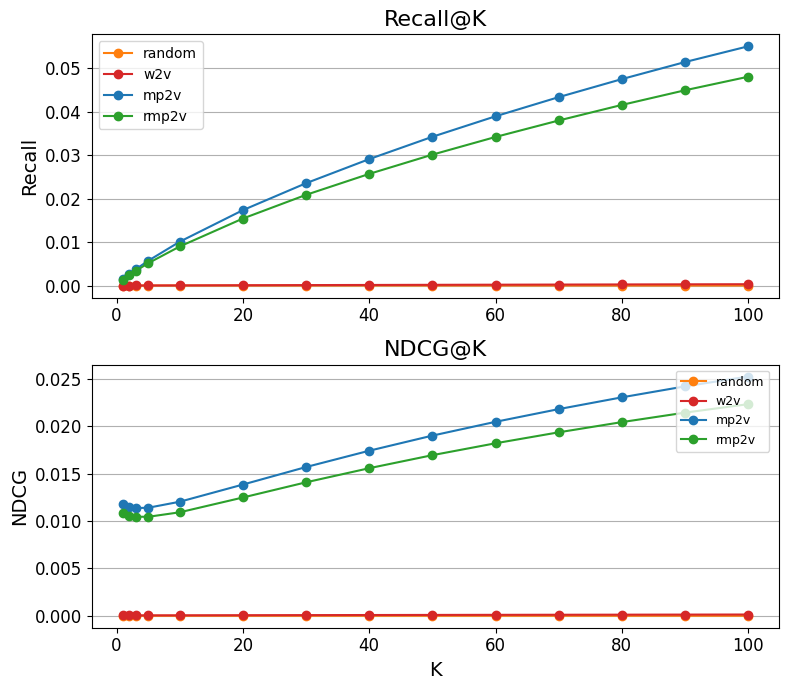

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from CSV files
random_df = pd.read_csv("results/SoundCloud/random_results.csv")
w2v_df = pd.read_csv("results/SoundCloud/w2v_results.csv")
mp2v_df = pd.read_csv("results/SoundCloud/mp2v_results.csv")
rmp2v_df = pd.read_csv("results/SoundCloud/rmp2v_results.csv")

# Extract K values from column names
k_values = sorted([int(col.split("@")[1]) for col in random_df.columns if "Recall@" in col])

# Create dictionaries for Recall and NDCG values
recall_dict = {
    "random": [random_df[f"Recall@{k}"].values[0] for k in k_values],
    "w2v": [w2v_df[f"Recall@{k}"].values[0] for k in k_values],
    "mp2v": [mp2v_df[f"Recall@{k}"].values[0] for k in k_values],
    "rmp2v": [rmp2v_df[f"Recall@{k}"].values[0] for k in k_values],
}

ndcg_dict = {
    "random": [random_df[f"NDCG@{k}"].values[0] for k in k_values],
    "w2v": [w2v_df[f"NDCG@{k}"].values[0] for k in k_values],
    "mp2v": [mp2v_df[f"NDCG@{k}"].values[0] for k in k_values],
    "rmp2v": [rmp2v_df[f"NDCG@{k}"].values[0] for k in k_values],
}

# Define colors for consistency with KuaiRec plot
colors = {
    "random": "tab:orange",
    "w2v": "tab:red",
    "mp2v": "tab:blue",
    "rmp2v": "tab:green",
}

# Initialize the figure with 2 subplots (Recall and NDCG)
fig, axs = plt.subplots(2, 1, figsize=(8, 7), sharex=False)

# Plot Recall@K for all models
for model_name in recall_dict.keys():
    recall_scores = recall_dict[model_name]
    axs[0].plot(k_values, recall_scores, marker="o", linestyle="-", label=model_name, color=colors[model_name])
axs[0].set_title("Recall@K", fontsize=16)
axs[0].set_ylabel("Recall", fontsize=14)
axs[0].legend(fontsize=10, loc="best")  # Inside plot, as in your original
axs[0].grid(True, axis="y")
axs[0].tick_params(axis="both", which="major", labelsize=12)

# Plot NDCG@K for all models
for model_name in ndcg_dict.keys():
    ndcg_scores = ndcg_dict[model_name]
    axs[1].plot(k_values, ndcg_scores, marker="o", linestyle="-", label=model_name, color=colors[model_name])
axs[1].set_title("NDCG@K", fontsize=16)
axs[1].set_xlabel("K", fontsize=14)
axs[1].set_ylabel("NDCG", fontsize=14)
axs[1].legend(fontsize=9, loc="upper left", bbox_to_anchor=(0.84, 1))  # Outside plot, matching KuaiRec style
axs[1].grid(True, axis="y")
axs[1].tick_params(axis="both", which="major", labelsize=12)

# Adjust layout and save
plt.tight_layout()
#fig.savefig("results/SoundCloud/metrics_by_k.png", bbox_inches="tight", dpi=300)  # Includes legend outside
plt.show()

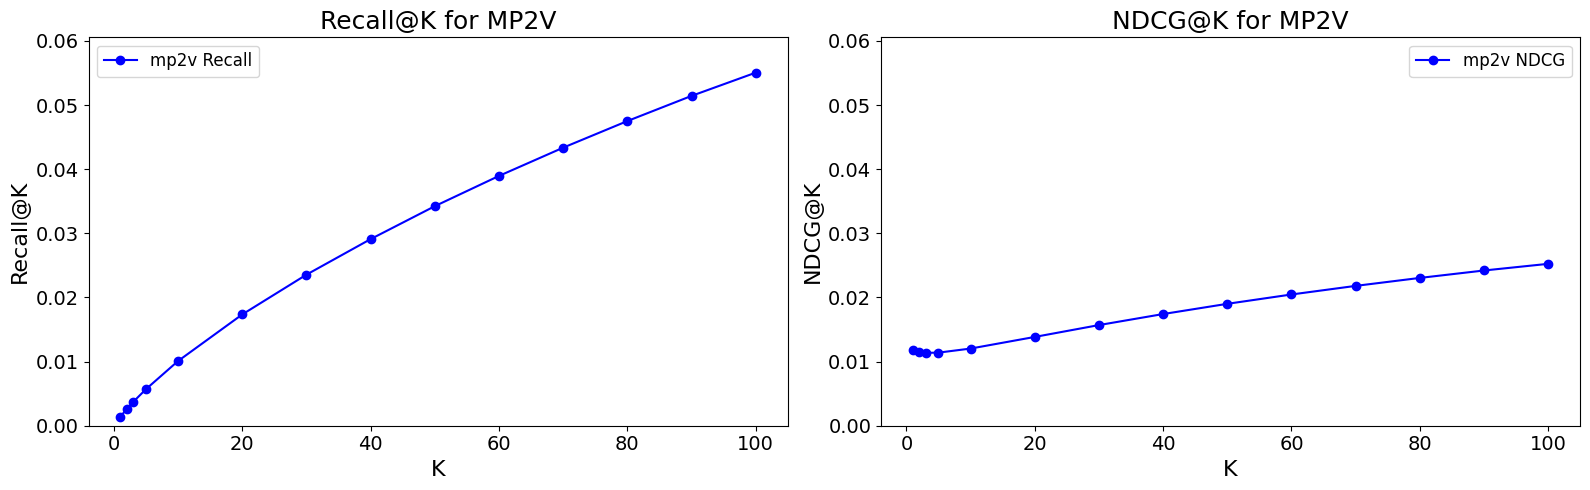

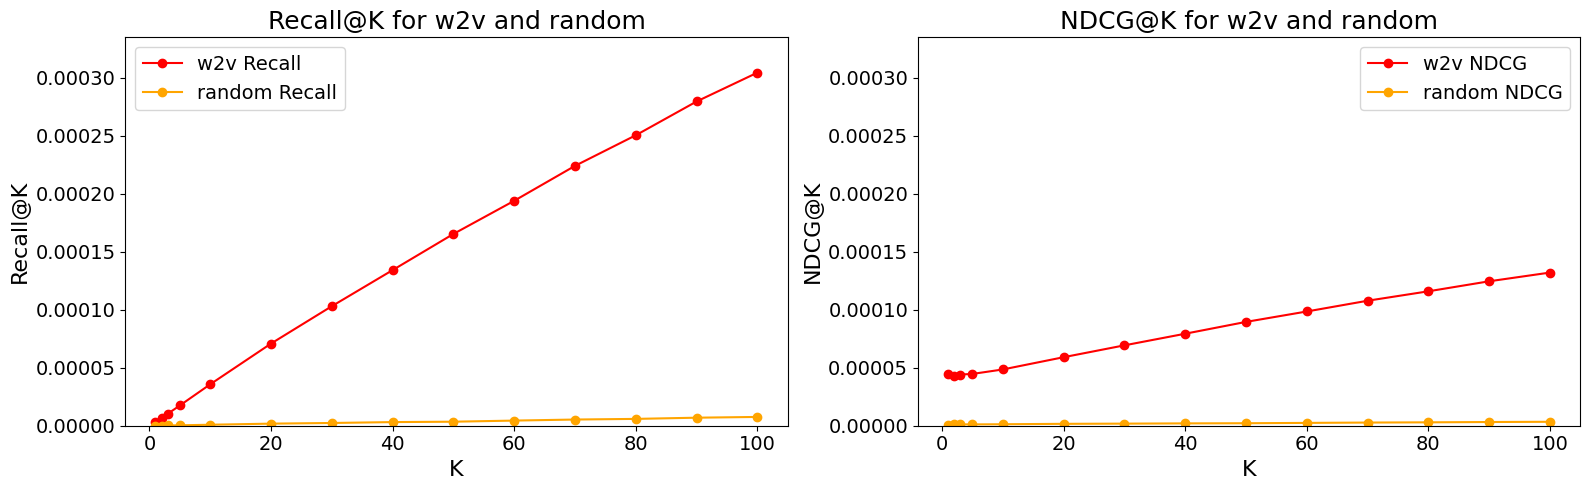

In [10]:
random_df = pd.read_csv("results/SoundCloud/random_results.csv")
w2v_df = pd.read_csv("results/SoundCloud/w2v_results.csv")
mp2v_df = pd.read_csv("results/SoundCloud/mp2v_results.csv")
rmp2v_df = pd.read_csv("results/SoundCloud/rmp2v_results.csv")

# Extract Recall@K and NDCG@K values
k_values = [int(col.split("@")[1]) for col in random_df.columns if "Recall@" in col]

# Create dictionaries for Recall and NDCG values
recall_dict = {
    "random": [random_df[f"Recall@{k}"].values[0] for k in k_values],
    "w2v": [w2v_df[f"Recall@{k}"].values[0] for k in k_values],
    "mp2v": [mp2v_df[f"Recall@{k}"].values[0] for k in k_values],
}

ndcg_dict = {
    "random": [random_df[f"NDCG@{k}"].values[0] for k in k_values],
    "w2v": [w2v_df[f"NDCG@{k}"].values[0] for k in k_values],
    "mp2v": [mp2v_df[f"NDCG@{k}"].values[0] for k in k_values],
}

# Get the global min and max for y-axis scaling for W2V and Random plots (just Recall and NDCG)
y_min_w2v_random = 0
y_max_w2v_random = max(max(recall_dict["random"]), max(recall_dict["w2v"]), max(ndcg_dict["random"]), max(ndcg_dict["w2v"]))*1.1

# Get the global min and max for y-axis scaling for MP2V plots (just Recall and NDCG)
y_min_mp2v = 0
y_max_mp2v = max(max(recall_dict["mp2v"]), max(ndcg_dict["mp2v"]))*1.1

# Plot for MP2V Recall@K and NDCG@K (mp2v in separate plot, sharing y-axis)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot Recall@K for MP2V
axs[0].plot(k_values, recall_dict["mp2v"], marker="o", linestyle="-", label="mp2v Recall", color='blue')
axs[0].set_xlabel("K", fontsize=16)
axs[0].set_ylabel("Recall@K", fontsize=16)
axs[0].set_title("Recall@K for MP2V", fontsize=18)
axs[0].set_ylim(y_min_mp2v, y_max_mp2v)  # Same y-axis scale for both plots
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=14)

# Plot NDCG@K for MP2V
axs[1].plot(k_values, ndcg_dict["mp2v"], marker="o", linestyle="-", label="mp2v NDCG", color='blue')
axs[1].set_xlabel("K", fontsize=16)
axs[1].set_ylabel("NDCG@K", fontsize=16)
axs[1].set_title("NDCG@K for MP2V", fontsize=18)
axs[1].set_ylim(y_min_mp2v, y_max_mp2v)  # Same y-axis scale for both plots
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("results/SoundCloud/mp2v_recall_ndcg.png", dpi=300)
plt.show()

# Plot for W2V and Random Recall@K and NDCG@K (w2v and random in one plot, sharing y-axis)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot Recall@K for w2v and random
axs[0].plot(k_values, recall_dict["w2v"], marker="o", linestyle="-", label="w2v Recall", color='red')
axs[0].plot(k_values, recall_dict["random"], marker="o", linestyle="-", label="random Recall", color='orange')
axs[0].set_xlabel("K", fontsize=16)
axs[0].set_ylabel("Recall@K", fontsize=16)
axs[0].set_title("Recall@K for w2v and random", fontsize=18)
axs[0].set_ylim(y_min_w2v_random, y_max_w2v_random)  # Same y-axis scale for both plots
axs[0].legend(fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

# Plot NDCG@K for w2v and random
axs[1].plot(k_values, ndcg_dict["w2v"], marker="o", linestyle="-", label="w2v NDCG", color='red')
axs[1].plot(k_values, ndcg_dict["random"], marker="o", linestyle="-", label="random NDCG", color='orange')
axs[1].set_xlabel("K", fontsize=16)
axs[1].set_ylabel("NDCG@K", fontsize=16)
axs[1].set_title("NDCG@K for w2v and random", fontsize=18)
axs[1].set_ylim(y_min_w2v_random, y_max_w2v_random)  # Same y-axis scale for both plots
axs[1].legend(fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("results/SoundCloud/w2v_random_recall_ndcg.png", dpi=300)
plt.show()

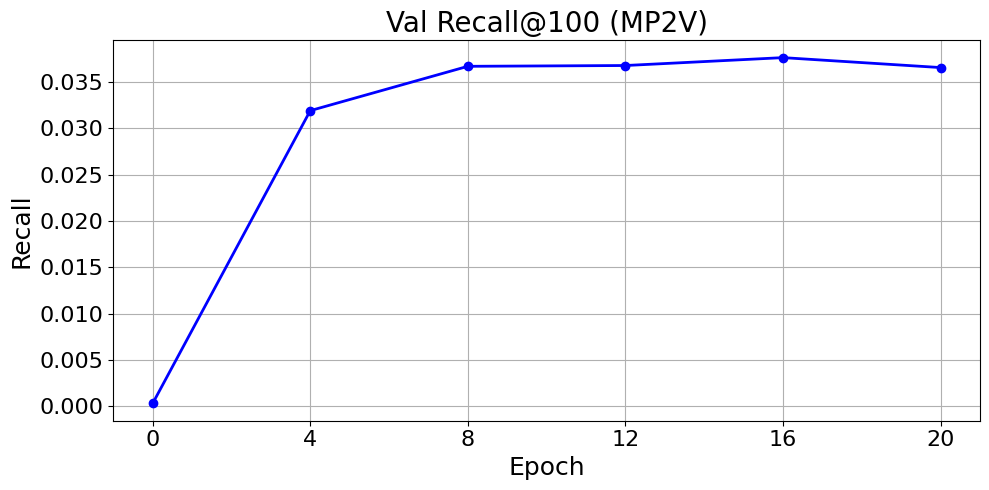

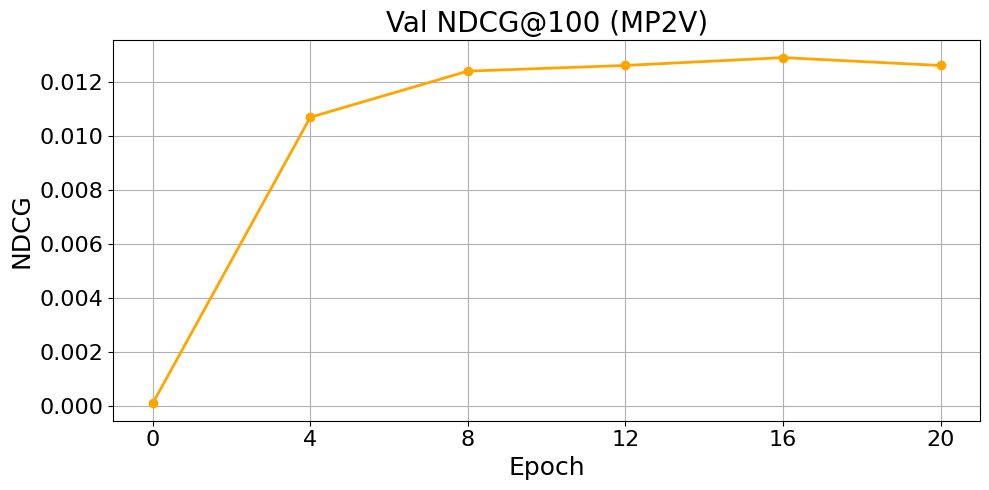

In [52]:
# Load validation metrics (Recall and NDCG over epochs)
val_metrics_df = pd.read_csv("results/SoundCloud/val_metrics.csv")

# Extract epochs
epochs = val_metrics_df['epoch']

# Extract the specific columns for Recall@100 and NDCG@100
recall_100 = val_metrics_df['Recall@100']
ndcg_100 = val_metrics_df['NDCG@100']

# Plotting Recall@100 over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, recall_100, marker="o", linestyle="-", label="Recall@100", color='blue', linewidth=2)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Recall", fontsize=18)
plt.title("Val Recall@100 (MP2V)", fontsize=20)
plt.xticks(epochs.astype(int), fontsize=16)  # Make x-axis labels integers
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("results/SoundCloud/recall_100_over_epochs.png", dpi=300)
plt.show()

# Plotting NDCG@100 over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, ndcg_100, marker="o", linestyle="-", label="NDCG@100", color='orange', linewidth=2)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("NDCG", fontsize=18)
plt.title("Val NDCG@100 (MP2V)", fontsize=20)
plt.xticks(epochs.astype(int), fontsize=16)  # Make x-axis labels integers
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("results/SoundCloud/ndcg_100_over_epochs.png", dpi=300)
plt.show()

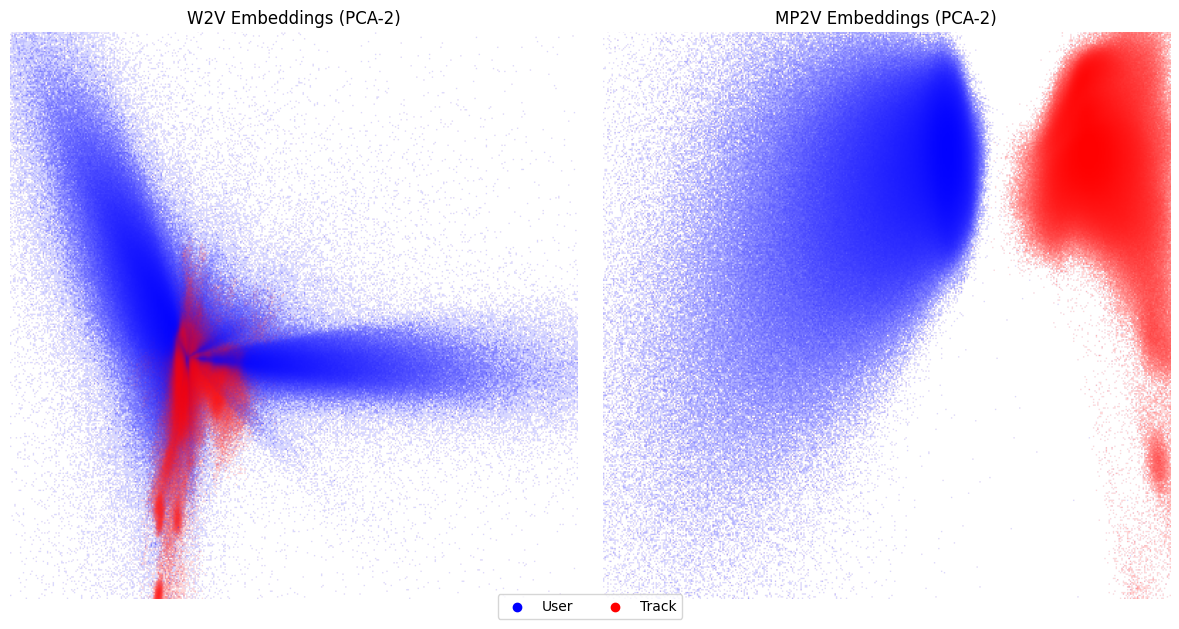

In [23]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

# Load W2V embeddings
w2v_user_emb = np.load('SoundCloud/user_embeddings_active_sampled.npy')
w2v_track_emb = np.load('SoundCloud/track_embeddings_active.npy')

# Load MP2V embeddings
mp2v_user_emb = np.load('runs/SoundCloud/u_embeddings7_16.npy')
mp2v_track_emb = np.load('runs/SoundCloud/t_embeddings7_16.npy')

n_users, n_tracks = 9184586, 13033110

w2v_combined = np.vstack((w2v_user_emb, w2v_track_emb))
mp2v_combined = np.vstack((mp2v_user_emb, mp2v_track_emb))

pca = PCA(n_components=2)
w2v_2d = pca.fit_transform(w2v_combined)
mp2v_2d = pca.fit_transform(mp2v_combined)

w2v_user_2d = w2v_2d[:n_users]
w2v_track_2d = w2v_2d[n_users:]
mp2v_user_2d = mp2v_2d[:n_users]
mp2v_track_2d = mp2v_2d[n_users:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# W2V (left)
w2v_df = pd.DataFrame(np.vstack((w2v_user_2d, w2v_track_2d)), columns=['x', 'y'])
w2v_df['type'] = pd.Categorical(['user'] * n_users + ['track'] * n_tracks)
x_bounds = [np.percentile(w2v_df['x'], 0.05), np.percentile(w2v_df['x'], 99.95)]
y_bounds = [np.percentile(w2v_df['y'], 0.05), np.percentile(w2v_df['y'], 99.95)]
cvs = ds.Canvas(plot_width=400, plot_height=400, x_range=x_bounds, y_range=y_bounds)
agg = cvs.points(w2v_df, 'x', 'y', ds.count_cat('type'))
img = tf.shade(agg, color_key={'user': 'blue', 'track': 'red'})
ax1.imshow(img.to_pil())
ax1.set_title('W2V Embeddings (PCA-2)')
ax1.axis('off')

# MP2V (right)
mp2v_df = pd.DataFrame(np.vstack((mp2v_user_2d, mp2v_track_2d)), columns=['x', 'y'])
mp2v_df['type'] = pd.Categorical(['user'] * n_users + ['track'] * n_tracks)
x_bounds = [np.percentile(mp2v_df['x'], 0.05), np.percentile(mp2v_df['x'], 99.95)]
y_bounds = [np.percentile(mp2v_df['y'], 0.05), np.percentile(mp2v_df['y'], 99.95)]
cvs = ds.Canvas(plot_width=400, plot_height=400, x_range=x_bounds, y_range=y_bounds)
agg = cvs.points(mp2v_df, 'x', 'y', ds.count_cat('type'))
img = tf.shade(agg, color_key={'user': 'blue', 'track': 'red'})
ax2.imshow(img.to_pil())
ax2.set_title('MP2V Embeddings (PCA-2)')
ax2.axis('off')

# Add proxy artists for legend
user_proxy = plt.scatter([], [], c='blue', label='User')
track_proxy = plt.scatter([], [], c='red', label='Track')

# Place legend below the subplots
fig.legend(handles=[user_proxy, track_proxy], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.savefig('results/SoundCloud/pca_embeddings.png')
plt.show()

### User Story Embedding Space Example

In [13]:
with open("SoundCloud/adj_data_90_active_sampled.pkl", "rb") as f:
    adj_data = pickle.load(f)
with open("SoundCloud/test_data_active_sampled.pkl", "rb") as f:
    test_data = pickle.load(f)
w2v_user_emb = np.load('SoundCloud/user_embeddings_active_sampled.npy')
w2v_track_emb = np.load('SoundCloud/track_embeddings_active.npy')
mp2v_user_emb = np.load('runs/SoundCloud/u_embeddings7_16.npy')
mp2v_track_emb = np.load('runs/SoundCloud/t_embeddings7_16.npy')

In [12]:
def select_active_users(adj_data, test_data, n_train=100, n_test=50, max_users=5):
    rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
    col = adj_data['col_dict'][('user', 'listens', 'track')]
    num_users = adj_data['num_nodes_dict']['user']
    
    # Convert test_data to set for O(1) lookup
    test_users = set(test_data.keys())
    selected_users = []
    
    # Randomly sample users until we have enough
    indices = np.random.permutation(num_users)
    for u in indices:
        train_count = rowptr[u + 1] - rowptr[u]  # Number of training interactions
        test_count = len(test_data.get(u, []))   # Number of test interactions
        if train_count >= n_train and test_count >= n_test and u in test_users:
            selected_users.append((u, train_count, test_count))
            if len(selected_users) == max_users:
                break
    return selected_users

def build_voyager_index(track_emb, batch_size=5000000, ef_construction=90):
    num_tracks, dim = track_emb.shape
    index = voyager.Index(
        space=voyager.Space.Cosine,
        num_dimensions=dim,
        max_elements=num_tracks,
        ef_construction=ef_construction
    )
    for i in range(0, num_tracks, batch_size):
        batch = track_emb[i:i + batch_size]
        index.add_items(batch)
    return index

def get_top_k_recommendations(user_emb, track_emb, user_id, voyager_index, k=50):
    user_vec = user_emb[user_id:user_id + 1]  # Shape: (1, dim)
    neighbors, _ = voyager_index.query(user_vec, k=k + 10)  # Extra to account for possible duplicates
    return neighbors[0][:k]  # Take top k

In [14]:
selected_users = select_active_users(adj_data, test_data)
print("Selected users:", [(u, t, te) for u, t, te in selected_users])
w2v_voyager = build_voyager_index(w2v_track_emb)
mp2v_voyager = build_voyager_index(mp2v_track_emb) 
print("Voyager Index built")

Selected users: [(8964763, tensor(184), 59), (7657010, tensor(402), 80), (1119954, tensor(318), 65), (4167322, tensor(872), 212), (8297151, tensor(109), 64)]
Voyager Index built


In [15]:
rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
col = adj_data['col_dict'][('user', 'listens', 'track')]
train_interactions = {u: col[rowptr[u]:rowptr[u + 1]].numpy().tolist() for u, _, _ in selected_users}
user_data = {}
for user_id, train_count, test_count in selected_users:
    print(f"User: {user_id}")
    w2v_recs = get_top_k_recommendations(w2v_user_emb, w2v_track_emb, user_id, w2v_voyager)
    mp2v_recs = get_top_k_recommendations(mp2v_user_emb, mp2v_track_emb, user_id, mp2v_voyager)
    user_data[user_id] = {
        'w2v_user': w2v_user_emb[user_id],
        'mp2v_user': mp2v_user_emb[user_id],
        'train_tracks': train_interactions[user_id],
        'test_tracks': test_data[user_id],
        'w2v_train': w2v_track_emb[train_interactions[user_id]],
        'mp2v_train': mp2v_track_emb[train_interactions[user_id]],
        'w2v_test': w2v_track_emb[test_data[user_id]],
        'mp2v_test': mp2v_track_emb[test_data[user_id]],
        'w2v_recs': w2v_track_emb[w2v_recs],
        'mp2v_recs': mp2v_track_emb[mp2v_recs]
    }

User: 8964763
User: 7657010
User: 1119954
User: 4167322
User: 8297151


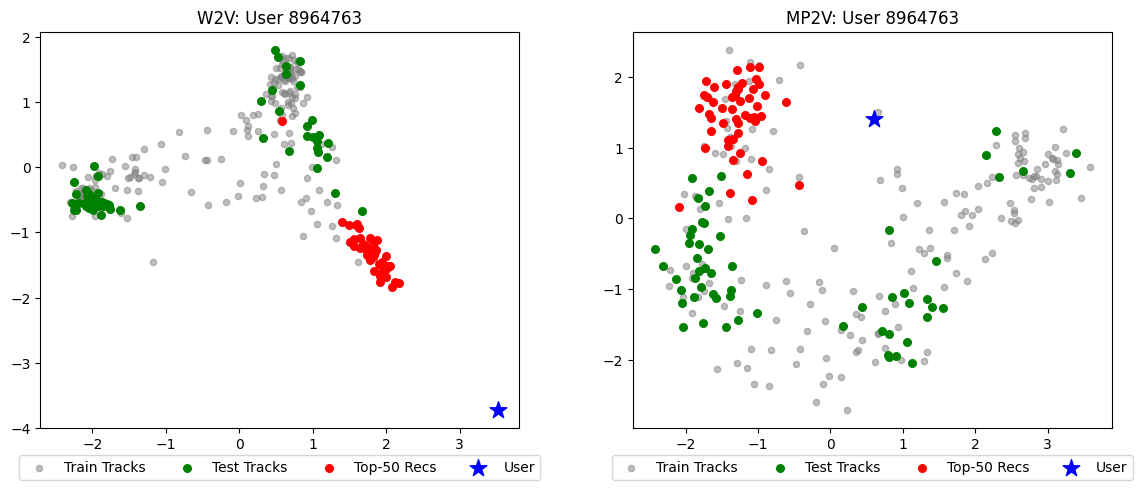

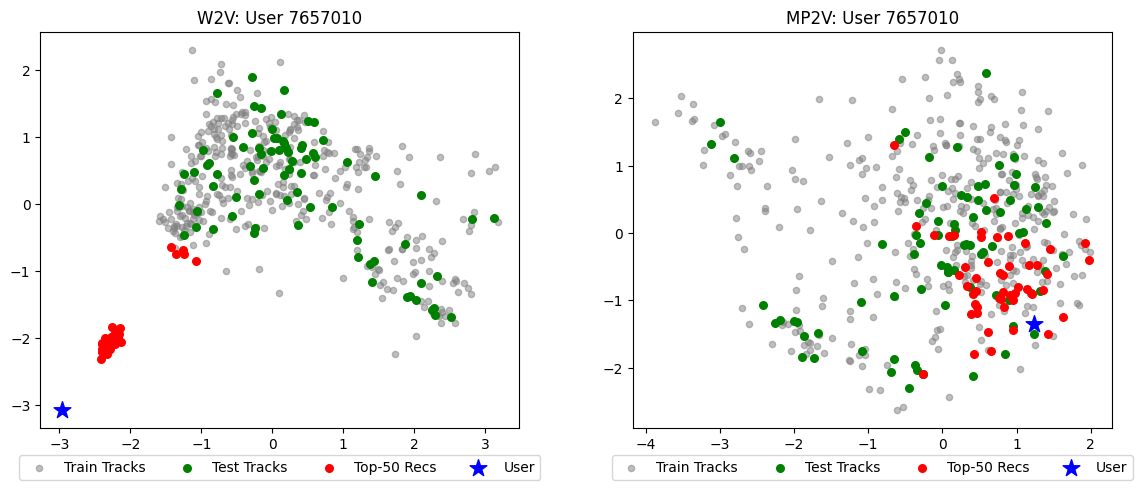

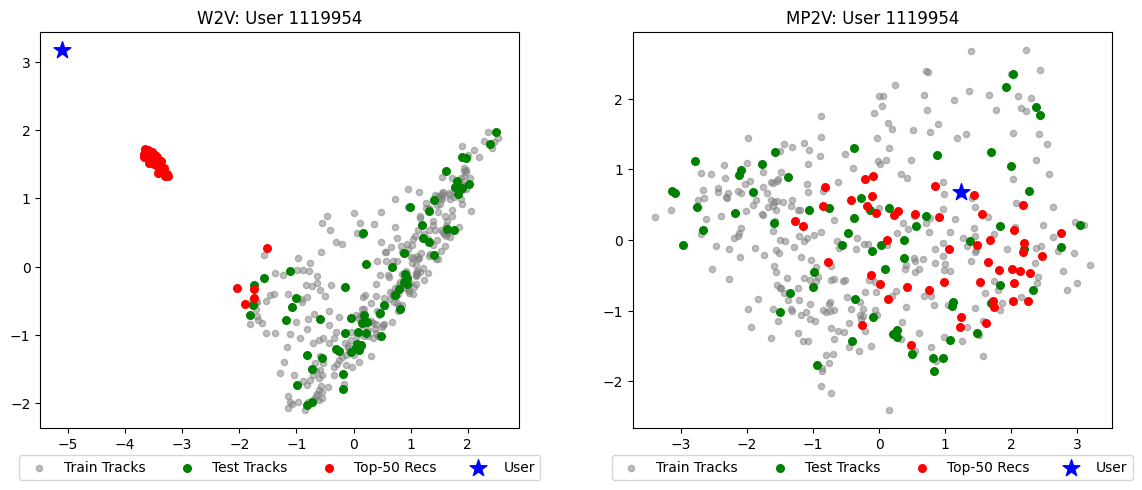

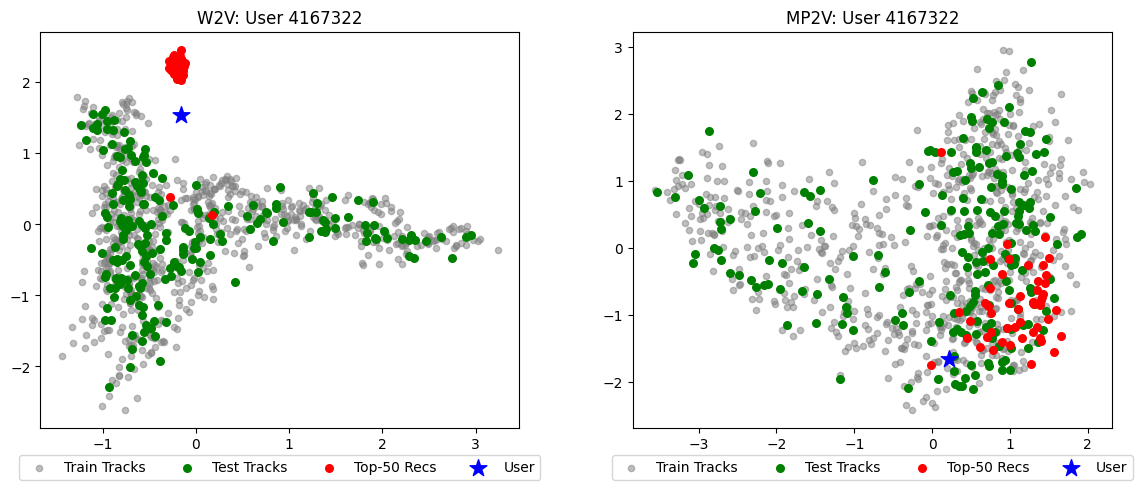

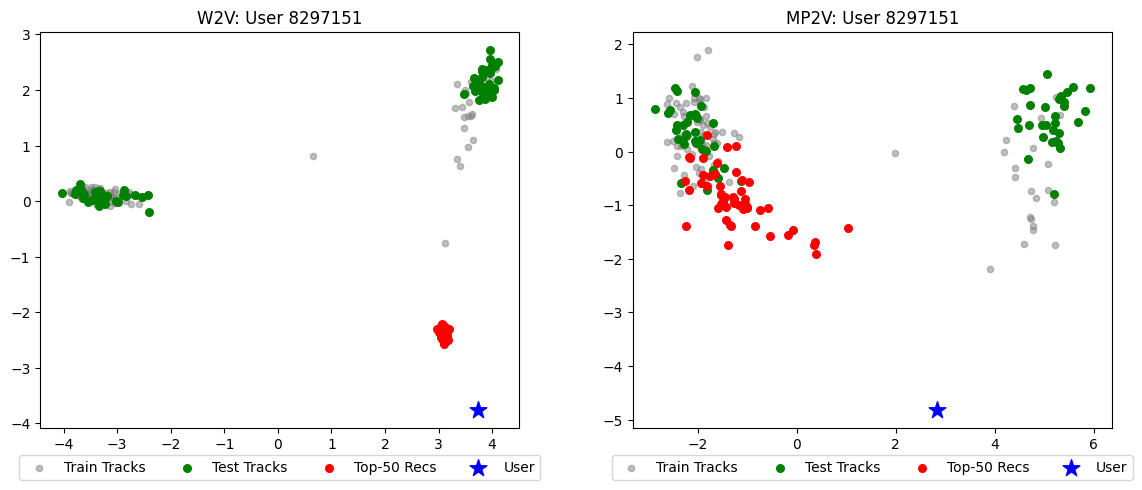

In [17]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import pickle
import voyager

for user_id in user_data:
    data = user_data[user_id]
    
    # PCA
    pca = PCA(n_components=2)
    w2v_all = np.vstack((data['w2v_user'].reshape(1, -1), data['w2v_train'], data['w2v_test'], data['w2v_recs']))
    mp2v_all = np.vstack((data['mp2v_user'].reshape(1, -1), data['mp2v_train'], data['mp2v_test'], data['mp2v_recs']))
    w2v_2d = pca.fit_transform(w2v_all)
    mp2v_2d = pca.fit_transform(mp2v_all)

    # Split PCA results
    w2v_user_2d = w2v_2d[0]
    w2v_train_2d = w2v_2d[1:1+len(data['train_tracks'])]
    w2v_test_2d = w2v_2d[1+len(data['train_tracks']):1+len(data['train_tracks'])+len(data['test_tracks'])]
    w2v_recs_2d = w2v_2d[1+len(data['train_tracks'])+len(data['test_tracks']):]
    mp2v_user_2d = mp2v_2d[0]
    mp2v_train_2d = mp2v_2d[1:1+len(data['train_tracks'])]
    mp2v_test_2d = mp2v_2d[1+len(data['train_tracks']):1+len(data['train_tracks'])+len(data['test_tracks'])]
    mp2v_recs_2d = mp2v_2d[1+len(data['train_tracks'])+len(data['test_tracks']):]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # W2V (left)
    ax1.scatter(w2v_train_2d[:, 0], w2v_train_2d[:, 1], c='gray', label='Train Tracks', s=20, alpha=0.5)
    ax1.scatter(w2v_test_2d[:, 0], w2v_test_2d[:, 1], c='green', label='Test Tracks', s=30)
    ax1.scatter(w2v_recs_2d[:, 0], w2v_recs_2d[:, 1], c='red', label='Top-50 Recs', s=30)
    ax1.scatter(w2v_user_2d[0], w2v_user_2d[1], c='blue', label='User', s=160, marker='*')
    ax1.set_title(f'W2V: User {user_id}')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

    # MP2V (right)
    ax2.scatter(mp2v_train_2d[:, 0], mp2v_train_2d[:, 1], c='gray', label='Train Tracks', s=20, alpha=0.5)
    ax2.scatter(mp2v_test_2d[:, 0], mp2v_test_2d[:, 1], c='green', label='Test Tracks', s=30)
    ax2.scatter(mp2v_recs_2d[:, 0], mp2v_recs_2d[:, 1], c='red', label='Top-50 Recs', s=30)
    ax2.scatter(mp2v_user_2d[0], mp2v_user_2d[1], c='blue', label='User', s=160, marker='*')
    ax2.set_title(f'MP2V: User {user_id}')
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.savefig(f'results/SoundCloud/user_{user_id}_embedding_comparison.png')
    plt.show()

### User Experience Metrics

In [6]:
with open("SoundCloud/adj_data_90_active_sampled.pkl", "rb") as f:
    adj_data = pickle.load(f)
with open("SoundCloud/test_data_active_sampled.pkl", "rb") as f:
    test_data = pickle.load(f)
w2v_user_emb = np.load('SoundCloud/user_embeddings_active_sampled.npy')
w2v_track_emb = np.load('SoundCloud/track_embeddings_active.npy')
mp2v_user_emb = np.load('runs/SoundCloud/u_embeddings7_16.npy')
mp2v_track_emb = np.load('runs/SoundCloud/t_embeddings7_16.npy')

In [7]:
def build_voyager_index(track_emb, batch_size=5000000, ef_construction=90):
    num_tracks, dim = track_emb.shape
    index = voyager.Index(
        space=voyager.Space.Cosine,
        num_dimensions=dim,
        max_elements=num_tracks,
        ef_construction=ef_construction
    )
    for i in range(0, num_tracks, batch_size):
        batch = track_emb[i:i + batch_size]
        index.add_items(batch)
    return index
w2v_voyager = build_voyager_index(w2v_track_emb)
mp2v_voyager = build_voyager_index(mp2v_track_emb)

In [8]:
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample 200,000 users from test_data for detailed analysis
sampled_users = random.sample(list(test_data.keys()), 200000)

# Extract training tracks for sampled users
rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
col = adj_data['col_dict'][('user', 'listens', 'track')]
train_tracks = {u: col[rowptr[u]:rowptr[u + 1]].numpy().tolist() for u in sampled_users}

# Function to get batch recommendations using Voyager indices
def get_batch_recommendations(user_emb, voyager_index, user_ids, k=50):
    batch_queries = user_emb[user_ids]
    neighbors, _ = voyager_index.query(batch_queries, k=k)
    return neighbors  # Shape: (len(user_ids), k)

# Get top-50 recommendations for sampled users in batches
w2v_recs = {}
mp2v_recs = {}
batch_size = 1000
for i in range(0, len(sampled_users), batch_size):
    batch_users = sampled_users[i:i + batch_size]
    w2v_batch_recs = get_batch_recommendations(w2v_user_emb, w2v_voyager, batch_users, k=50)
    mp2v_batch_recs = get_batch_recommendations(mp2v_user_emb, mp2v_voyager, batch_users, k=50)
    for j, u in enumerate(batch_users):
        w2v_recs[u] = w2v_batch_recs[j]
        mp2v_recs[u] = mp2v_batch_recs[j]

In [9]:
def compute_diversity(recs, track_emb):
    """Compute diversity as 1 - average pairwise cosine similarity among recommendations."""
    if len(recs) < 2:
        return 0
    emb = track_emb[recs]
    sim_matrix = cosine_similarity(emb)
    np.fill_diagonal(sim_matrix, 0)  # Exclude self-similarity
    return 1 - np.mean(sim_matrix)  # Higher value = more diverse

def compute_novelty(recs, train_tracks):
    """Compute novelty as the proportion of recommendations not in the user's training set."""
    novel = [t for t in recs if t not in train_tracks]
    return len(novel) / len(recs) if len(recs) > 0 else 0

# Compute metrics for each sampled user
w2v_diversity_list = []
mp2v_diversity_list = []
w2v_novelty_list = []
mp2v_novelty_list = []

for u in sampled_users:
    w2v_r = w2v_recs[u]
    mp2v_r = mp2v_recs[u]
    train_t = set(train_tracks[u])  # Convert to set for faster lookup
    
    w2v_div = compute_diversity(w2v_r, w2v_track_emb)
    mp2v_div = compute_diversity(mp2v_r, mp2v_track_emb)
    w2v_nov = compute_novelty(w2v_r, train_t)
    mp2v_nov = compute_novelty(mp2v_r, train_t)
    
    w2v_diversity_list.append(w2v_div)
    mp2v_diversity_list.append(mp2v_div)
    w2v_novelty_list.append(w2v_nov)
    mp2v_novelty_list.append(mp2v_nov)

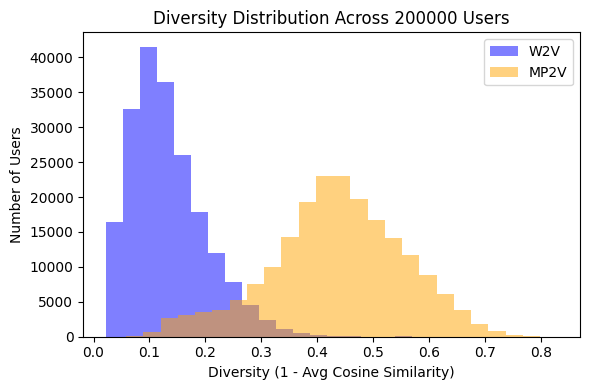

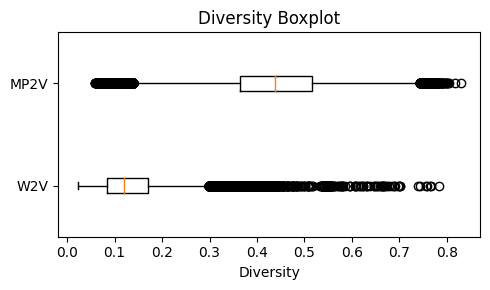

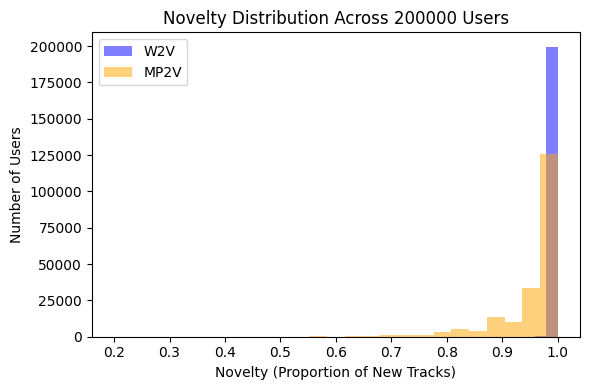

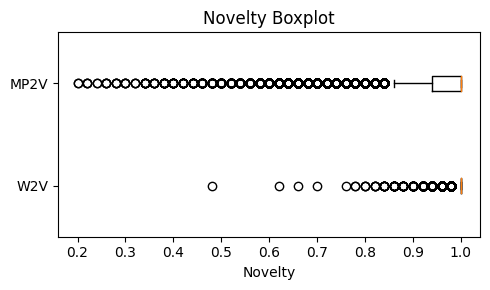

### Summary Statistics Across 200000 Sampled Users ###
W2V Diversity: Mean=0.133, Median=0.121, Std=0.068
MP2V Diversity: Mean=0.435, Median=0.437, Std=0.120
W2V Novelty: Mean=1.000, Median=1.000, Std=0.004
MP2V Novelty: Mean=0.960, Median=1.000, Std=0.066

### Catalog Coverage Across All Users (K=100) ###
W2V Coverage@100: 0.4886
MP2V Coverage@100: 0.2689


In [13]:
# Diversity Histogram
plt.figure(figsize=(6, 4))
plt.hist(w2v_diversity_list, bins=25, alpha=0.5, label='W2V', color='blue')
plt.hist(mp2v_diversity_list, bins=25, alpha=0.5, label='MP2V', color='orange')
plt.title('Diversity Distribution Across 200000 Users')
plt.xlabel('Diversity (1 - Avg Cosine Similarity)')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.savefig('results/SoundCloud/diversity_histogram.png')
plt.show()

# Diversity Boxplot (Horizontal)
plt.figure(figsize=(5, 3))  # Adjusted height for horizontal layout
plt.boxplot([w2v_diversity_list, mp2v_diversity_list], labels=['W2V', 'MP2V'], vert=False)
plt.title('Diversity Boxplot')
plt.xlabel('Diversity')  # Changed to xlabel since x-axis now shows values
plt.tight_layout()
plt.savefig('results/SoundCloud/diversity_boxplot.png')
plt.show()

# Novelty Histogram
plt.figure(figsize=(6, 4))
plt.hist(w2v_novelty_list, bins=25, alpha=0.5, label='W2V', color='blue')
plt.hist(mp2v_novelty_list, bins=25, alpha=0.5, label='MP2V', color='orange')
plt.title('Novelty Distribution Across 200000 Users')
plt.xlabel('Novelty (Proportion of New Tracks)')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.savefig('results/SoundCloud/novelty_histogram.png')
plt.show()

# Novelty Boxplot (Horizontal)
plt.figure(figsize=(5, 3))  # Adjusted height for horizontal layout
plt.boxplot([w2v_novelty_list, mp2v_novelty_list], labels=['W2V', 'MP2V'], vert=False)
plt.title('Novelty Boxplot')
plt.xlabel('Novelty')  # Changed to xlabel since x-axis now shows values
plt.tight_layout()
plt.savefig('results/SoundCloud/novelty_boxplot.png')
plt.show()

# Summary statistics
print("### Summary Statistics Across 200000 Sampled Users ###")
print(f"W2V Diversity: Mean={np.mean(w2v_diversity_list):.3f}, Median={np.median(w2v_diversity_list):.3f}, Std={np.std(w2v_diversity_list):.3f}")
print(f"MP2V Diversity: Mean={np.mean(mp2v_diversity_list):.3f}, Median={np.median(mp2v_diversity_list):.3f}, Std={np.std(mp2v_diversity_list):.3f}")
print(f"W2V Novelty: Mean={np.mean(w2v_novelty_list):.3f}, Median={np.median(w2v_novelty_list):.3f}, Std={np.std(w2v_novelty_list):.3f}")
print(f"MP2V Novelty: Mean={np.mean(mp2v_novelty_list):.3f}, Median={np.median(mp2v_novelty_list):.3f}, Std={np.std(mp2v_novelty_list):.3f}")

# Catalog coverage
print("\n### Catalog Coverage Across All Users (K=100) ###")
print("W2V Coverage@100: 0.4886")
print("MP2V Coverage@100: 0.2689")

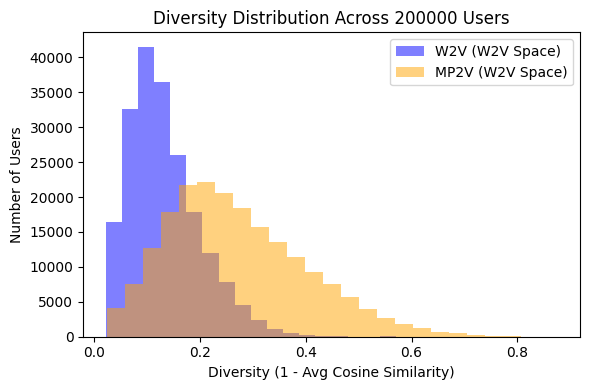

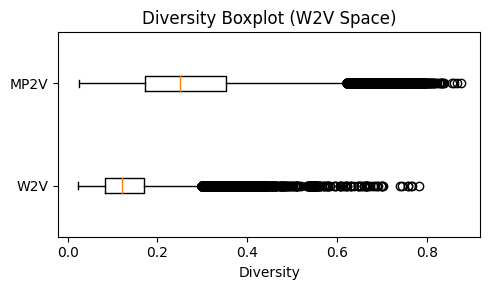

### Diversity Statistics Across 200000 Sampled Users ###
W2V Diversity (W2V Space): Mean=0.133, Median=0.121, Std=0.068
MP2V Diversity (W2V Space): Mean=0.270, Median=0.251, Std=0.131


In [16]:
# Compute MP2V diversity using W2V embeddings
mp2v_diversity_w2v_space = []
for u in sampled_users:
    mp2v_r = mp2v_recs[u]  # MP2V recommendations for this user
    if len(mp2v_r) < 2:
        mp2v_diversity_w2v_space.append(0)
    else:
        emb = w2v_track_emb[mp2v_r]  # Use W2V embeddings for MP2V recs
        sim_matrix = cosine_similarity(emb)
        np.fill_diagonal(sim_matrix, 0)  # Exclude self-similarity
        avg_sim = np.mean(sim_matrix)
        mp2v_diversity_w2v_space.append(1 - avg_sim)

# Diversity Histogram
plt.figure(figsize=(6, 4))
plt.hist(w2v_diversity_list, bins=25, alpha=0.5, label='W2V (W2V Space)', color='blue')
plt.hist(mp2v_diversity_w2v_space, bins=25, alpha=0.5, label='MP2V (W2V Space)', color='orange')
plt.title('Diversity Distribution Across 200000 Users')
plt.xlabel('Diversity (1 - Avg Cosine Similarity)')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.savefig('results/SoundCloud/diversity_histogram_mp2v_in_w2v_space.png')
plt.show()

# Diversity Boxplot
plt.figure(figsize=(5, 3))
plt.boxplot([w2v_diversity_list, mp2v_diversity_w2v_space], labels=['W2V', 'MP2V'], vert=False)
plt.title('Diversity Boxplot (W2V Space)')
plt.xlabel('Diversity')
plt.tight_layout()
plt.savefig('results/SoundCloud/diversity_boxplot_mp2v_in_w2v_space.png')
plt.show()

# Summary statistics
print("### Diversity Statistics Across 200000 Sampled Users ###")
print(f"W2V Diversity (W2V Space): Mean={np.mean(w2v_diversity_list):.3f}, Median={np.median(w2v_diversity_list):.3f}, Std={np.std(w2v_diversity_list):.3f}")
print(f"MP2V Diversity (W2V Space): Mean={np.mean(mp2v_diversity_w2v_space):.3f}, Median={np.median(mp2v_diversity_w2v_space):.3f}, Std={np.std(mp2v_diversity_w2v_space):.3f}")

In [10]:
combined_df = pd.read_csv("SoundCloud/track_attributes.csv")

# Precompute lookup dictionaries for track_idx to artist and genre
start_time = time.time()
track_to_artist = pd.Series(combined_df['username'].values, index=combined_df['track_idx']).dropna().to_dict()
track_to_genre = pd.Series(combined_df['genre'].values, index=combined_df['track_idx']).dropna().to_dict()
print(f"Precomputing lookups took {time.time() - start_time:.2f} seconds")

# Function to calculate unique feature count efficiently
def calculate_unique_count(recs, feature_dict):
    """Calculate unique count using a precomputed feature lookup."""
    feature_values = [feature_dict.get(r) for r in recs if r in feature_dict]
    return len(set(feature_values)) if feature_values else 0

# Vectorized computation for all users
start_time = time.time()
w2v_recs_array = np.array([w2v_recs[u] for u in sampled_users[:100000]])
mp2v_recs_array = np.array([mp2v_recs[u] for u in sampled_users[:100000]])

# Compute diversity metrics for all users at once
w2v_artist_counts = [calculate_unique_count(recs, track_to_artist) for recs in w2v_recs_array]
w2v_genre_counts = [calculate_unique_count(recs, track_to_genre) for recs in w2v_recs_array]
mp2v_artist_counts = [calculate_unique_count(recs, track_to_artist) for recs in mp2v_recs_array]
mp2v_genre_counts = [calculate_unique_count(recs, track_to_genre) for recs in mp2v_recs_array]

# Calculate average metrics
w2v_avg_artist_unique = np.mean(w2v_artist_counts)
w2v_avg_genre_unique = np.mean(w2v_genre_counts)
mp2v_avg_artist_unique = np.mean(mp2v_artist_counts)
mp2v_avg_genre_unique = np.mean(mp2v_genre_counts)

print(f"Diversity computation took {time.time() - start_time:.2f} seconds")

# Print results
print("W2V Average Unique Artists:", w2v_avg_artist_unique)
print("W2V Average Unique Genres:", w2v_avg_genre_unique)
print("MP2V Average Unique Artists:", mp2v_avg_artist_unique)
print("MP2V Average Unique Genres:", mp2v_avg_genre_unique)

Precomputing lookups took 14.11 seconds
Diversity computation took 52.37 seconds
W2V Average Unique Artists: 40.11255
W2V Average Unique Genres: 3.70329
MP2V Average Unique Artists: 38.81278
MP2V Average Unique Genres: 4.30252


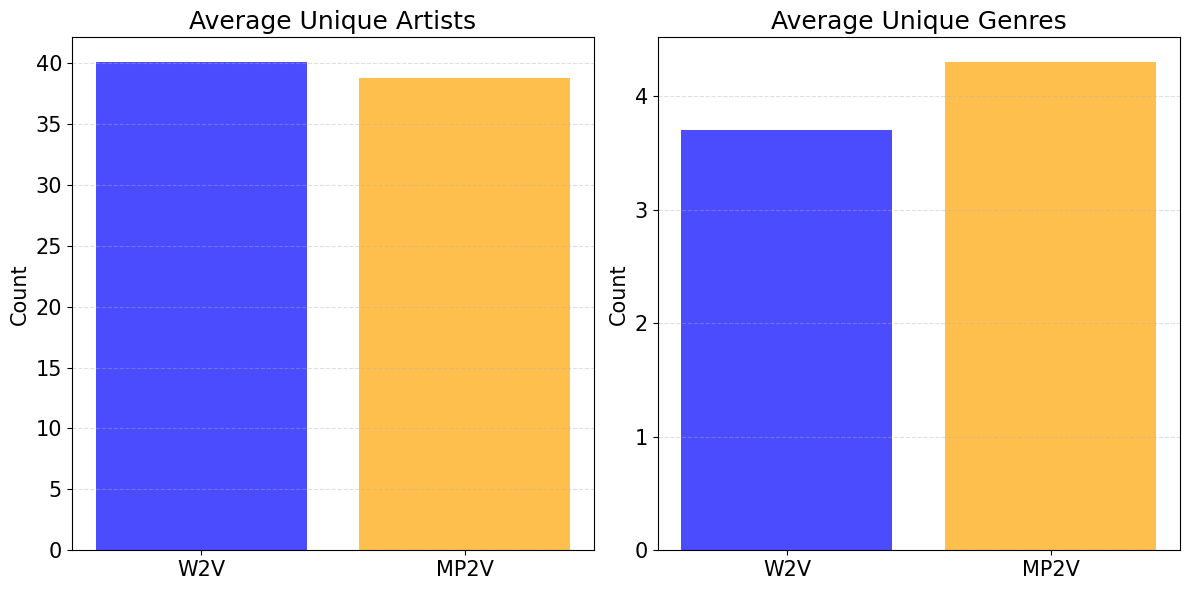

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Consistent color scheme from previous plots
colors = ['blue', 'orange']  # Matches histogram colors

# Artist Unique Count
axes[0].bar(['W2V', 'MP2V'], [w2v_avg_artist_unique, mp2v_avg_artist_unique], color=colors, alpha=0.7)
axes[0].set_title('Average Unique Artists', fontsize=18)
axes[0].set_ylabel('Count', fontsize=15)
axes[0].tick_params(axis='both', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# Genre Unique Count
axes[1].bar(['W2V', 'MP2V'], [w2v_avg_genre_unique, mp2v_avg_genre_unique], color=colors, alpha=0.7)
axes[1].set_title('Average Unique Genres', fontsize=18)
axes[1].set_ylabel('Count', fontsize=15)
axes[1].tick_params(axis='both', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

# Improve layout and save the figure
plt.tight_layout()
fig.savefig('results/SoundCloud/feature_diversity.png', dpi=300)
plt.show()

### User Cohort & Long Tail Content Analysis

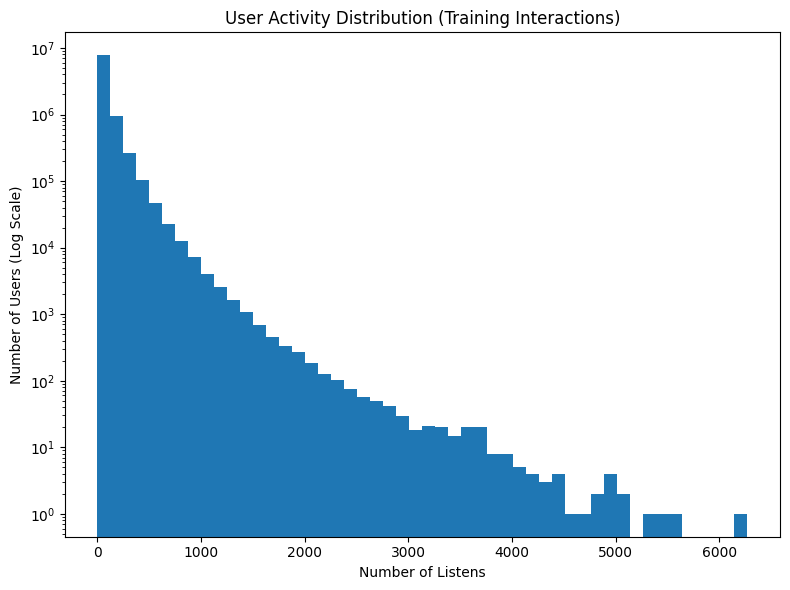

In [4]:
rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
col = adj_data['col_dict'][('user', 'listens', 'track')]
num_users = adj_data['num_nodes_dict']['user']

# Count training interactions per user
user_activity = [rowptr[u + 1] - rowptr[u] for u in range(num_users)]

# Plot histogram to define cohorts
plt.figure(figsize=(8, 6))
plt.hist(user_activity, bins=50, log=True)
plt.title('User Activity Distribution (Training Interactions)')
plt.xlabel('Number of Listens')
plt.ylabel('Number of Users (Log Scale)')
plt.tight_layout()
plt.show()

In [6]:
activity_thresholds = np.percentile(user_activity, [25, 75])
cohorts = {u: 'Low' if a < activity_thresholds[0] else 'Medium' if a < activity_thresholds[1] else 'High' 
           for u, a in enumerate(user_activity)}

def get_top_k_recommendations(user_emb, voyager_index, user_ids, k=10):
    batch = user_emb[user_ids]
    neighbors, _ = voyager_index.query(batch, k=k)
    return neighbors

def compute_recall(recs, test_tracks):
    hits = sum(1 for t in test_tracks if t in recs)  # Check if test tracks are in recs list
    return hits / len(test_tracks) if test_tracks else 0

def compute_diversity(recs, track_emb):
    if len(recs) < 2:
        return 0
    emb = track_emb[recs]
    sim_matrix = cosine_similarity(emb)
    np.fill_diagonal(sim_matrix, 0)
    return 1 - np.mean(sim_matrix)

def compute_novelty(recs, train_tracks):
    novel = [t for t in recs if t not in train_tracks]
    return len(novel) / len(recs) if len(recs) > 0 else 0

In [23]:
cohort_metrics = {'W2V': {'Low': [], 'Medium': [], 'High': []}, 
                  'MP2V': {'Low': [], 'Medium': [], 'High': []}}

for cohort in ['Low', 'Medium', 'High']:
    cohort_users = [u for u, c in cohorts.items() if c == cohort and u in test_data]
    cohort_users = cohort_users[:200000]  # Limit for speed
    
    w2v_recs = get_top_k_recommendations(w2v_user_emb, w2v_voyager, cohort_users, k=100)
    mp2v_recs = get_top_k_recommendations(mp2v_user_emb, mp2v_voyager, cohort_users, k=100)
    
    for i, u in enumerate(cohort_users):
        train_tracks = set(col[rowptr[u]:rowptr[u + 1]].numpy())
        test_tracks = set(test_data[u])
        
        w2v_r = w2v_recs[i]
        mp2v_r = mp2v_recs[i]
        
        cohort_metrics['W2V'][cohort].append({
            'recall': compute_recall(w2v_r, test_tracks),
            'diversity': compute_diversity(w2v_r, w2v_track_emb),
            'novelty': compute_novelty(w2v_r, train_tracks)
        })
        cohort_metrics['MP2V'][cohort].append({
            'recall': compute_recall(mp2v_r, test_tracks),
            'diversity': compute_diversity(mp2v_r, mp2v_track_emb),
            'novelty': compute_novelty(mp2v_r, train_tracks)
        })

In [24]:
for model in ['W2V', 'MP2V']:
    print(f"\n### {model} Cohort Metrics ###")
    for cohort in ['Low', 'Medium', 'High']:
        recalls = [m['recall'] for m in cohort_metrics[model][cohort]]
        diversities = [m['diversity'] for m in cohort_metrics[model][cohort]]
        novelties = [m['novelty'] for m in cohort_metrics[model][cohort]]
        print(f"{cohort} (n={len(recalls)}):")
        print(f"  Recall@100: Mean={np.mean(recalls):.4f}, Std={np.std(recalls):.4f}")
        print(f"  Diversity: Mean={np.mean(diversities):.4f}, Std={np.std(diversities):.4f}")
        print(f"  Novelty: Mean={np.mean(novelties):.4f}, Std={np.std(novelties):.4f}")


### W2V Cohort Metrics ###
Low (n=200000):
  Recall@100: Mean=0.0003, Std=0.0117
  Diversity: Mean=0.1603, Std=0.0720
  Novelty: Mean=1.0000, Std=0.0009
Medium (n=200000):
  Recall@100: Mean=0.0004, Std=0.0124
  Diversity: Mean=0.1608, Std=0.0724
  Novelty: Mean=0.9998, Std=0.0022
High (n=200000):
  Recall@100: Mean=0.0003, Std=0.0081
  Diversity: Mean=0.1610, Std=0.0721
  Novelty: Mean=0.9995, Std=0.0053

### MP2V Cohort Metrics ###
Low (n=200000):
  Recall@100: Mean=0.0897, Std=0.2224
  Diversity: Mean=0.4721, Std=0.1218
  Novelty: Mean=0.9820, Std=0.0253
Medium (n=200000):
  Recall@100: Mean=0.0618, Std=0.1581
  Diversity: Mean=0.4636, Std=0.1129
  Novelty: Mean=0.9703, Std=0.0378
High (n=200000):
  Recall@100: Mean=0.0366, Std=0.0941
  Diversity: Mean=0.4689, Std=0.1005
  Novelty: Mean=0.9319, Std=0.0714


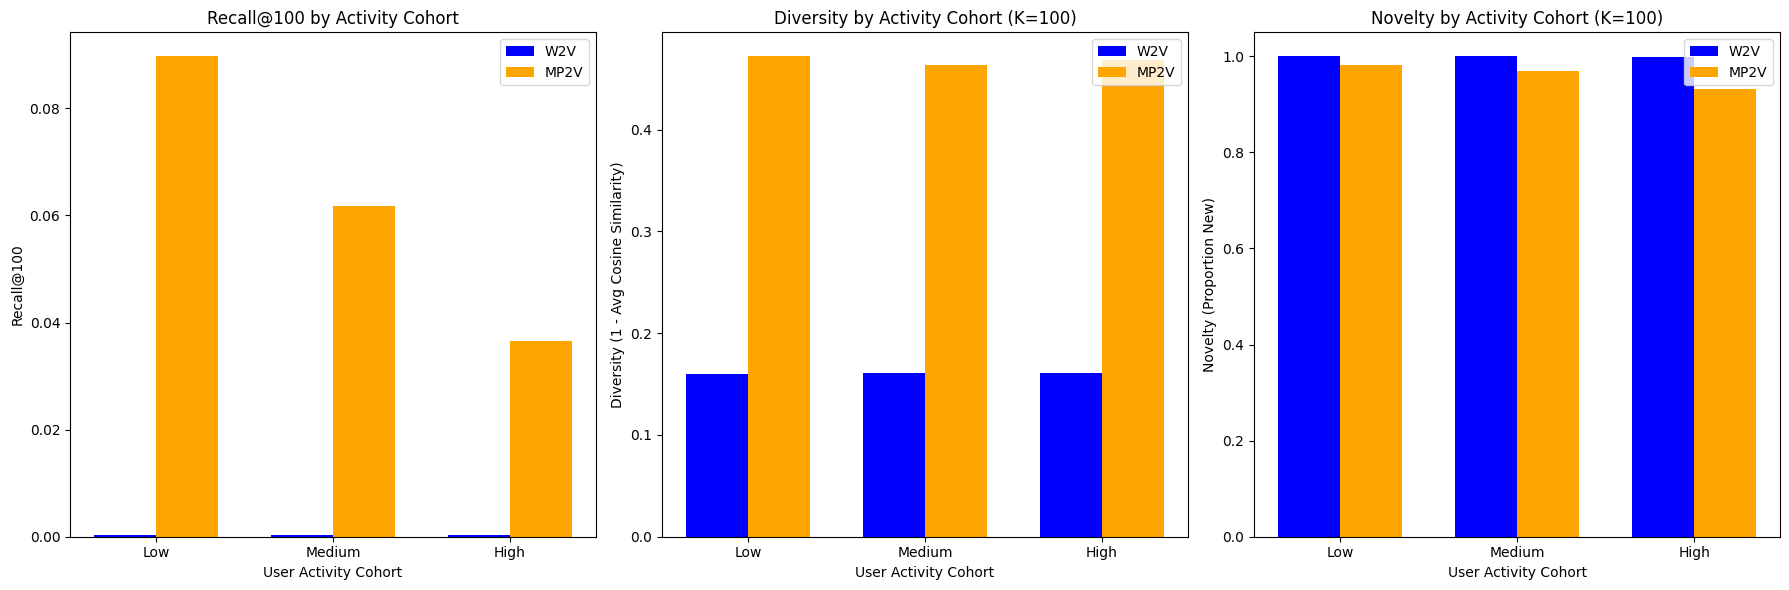

In [25]:
# Extract mean metrics from cohort_metrics
cohorts = ['Low', 'Medium', 'High']
w2v_recall = [np.mean([m['recall'] for m in cohort_metrics['W2V'][c]]) for c in cohorts]
w2v_diversity = [np.mean([m['diversity'] for m in cohort_metrics['W2V'][c]]) for c in cohorts]
w2v_novelty = [np.mean([m['novelty'] for m in cohort_metrics['W2V'][c]]) for c in cohorts]
mp2v_recall = [np.mean([m['recall'] for m in cohort_metrics['MP2V'][c]]) for c in cohorts]
mp2v_diversity = [np.mean([m['diversity'] for m in cohort_metrics['MP2V'][c]]) for c in cohorts]
mp2v_novelty = [np.mean([m['novelty'] for m in cohort_metrics['MP2V'][c]]) for c in cohorts]

# Bar plot settings
x = np.arange(len(cohorts))
width = 0.35

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Recall@100
ax1.bar(x - width/2, w2v_recall, width, label='W2V', color='blue')
ax1.bar(x + width/2, mp2v_recall, width, label='MP2V', color='orange')
ax1.set_title('Recall@100 by Activity Cohort')
ax1.set_xlabel('User Activity Cohort')
ax1.set_ylabel('Recall@100')
ax1.set_xticks(x)
ax1.set_xticklabels(cohorts)
ax1.legend()

# Diversity
ax2.bar(x - width/2, w2v_diversity, width, label='W2V', color='blue')
ax2.bar(x + width/2, mp2v_diversity, width, label='MP2V', color='orange')
ax2.set_title('Diversity by Activity Cohort (K=100)')
ax2.set_xlabel('User Activity Cohort')
ax2.set_ylabel('Diversity (1 - Avg Cosine Similarity)')
ax2.set_xticks(x)
ax2.set_xticklabels(cohorts)
ax2.legend()

# Novelty
ax3.bar(x - width/2, w2v_novelty, width, label='W2V', color='blue')
ax3.bar(x + width/2, mp2v_novelty, width, label='MP2V', color='orange')
ax3.set_title('Novelty by Activity Cohort (K=100)')
ax3.set_xlabel('User Activity Cohort')
ax3.set_ylabel('Novelty (Proportion New)')
ax3.set_xticks(x)
ax3.set_xticklabels(cohorts)
ax3.legend()

# Adjust layout
plt.tight_layout()
fig.savefig('results/SoundCloud/user_cohort_metrics.png')
plt.show()

In [28]:
from collections import Counter

# Step 1: Compute track play counts from training data
rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
col = adj_data['col_dict'][('user', 'listens', 'track')]
num_tracks = adj_data['num_nodes_dict']['track']
play_counts = np.bincount(col, minlength=num_tracks)  # Number of listens per track

# Step 2: Sort tracks by popularity and define bins
track_indices = np.arange(num_tracks)
sorted_indices = np.argsort(play_counts)[::-1]  # Descending order
sorted_play_counts = play_counts[sorted_indices]

# Define popularity bins (e.g., logarithmic bins)
bins = np.logspace(0, np.log10(max(play_counts) + 1), num=20, dtype=int)
bin_indices = np.digitize(sorted_play_counts, bins)

# Step 3: Get recommendations for a sample of users
sample_users = list(test_data.keys())[:200000]  # Sample 200K users from test set
w2v_recs = get_top_k_recommendations(w2v_user_emb, w2v_voyager, sample_users, k=100)
mp2v_recs = get_top_k_recommendations(mp2v_user_emb, mp2v_voyager, sample_users, k=100)

# Step 4: Count recommendation frequency per track
w2v_rec_counts = Counter(np.concatenate(w2v_recs))
mp2v_rec_counts = Counter(np.concatenate(mp2v_recs))

# Step 5: Aggregate recommendation frequency by popularity bin
w2v_bin_freq = np.zeros(len(bins))
mp2v_bin_freq = np.zeros(len(bins))
for idx, bin_id in enumerate(bin_indices):
    w2v_bin_freq[bin_id - 1] += w2v_rec_counts.get(sorted_indices[idx], 0)
    mp2v_bin_freq[bin_id - 1] += mp2v_rec_counts.get(sorted_indices[idx], 0)

# Normalize by number of tracks in each bin
bin_sizes = np.bincount(bin_indices, minlength=len(bins) + 1)[1:]
w2v_bin_freq = w2v_bin_freq / bin_sizes
mp2v_bin_freq = mp2v_bin_freq / bin_sizes

/var/tmp/ipykernel_3156/3271560923.py:36: RuntimeWarning: divide by zero encountered in divide
  w2v_bin_freq = w2v_bin_freq / bin_sizes
/var/tmp/ipykernel_3156/3271560923.py:36: RuntimeWarning: invalid value encountered in divide
  w2v_bin_freq = w2v_bin_freq / bin_sizes
/var/tmp/ipykernel_3156/3271560923.py:37: RuntimeWarning: divide by zero encountered in divide
  mp2v_bin_freq = mp2v_bin_freq / bin_sizes
/var/tmp/ipykernel_3156/3271560923.py:37: RuntimeWarning: invalid value encountered in divide
  mp2v_bin_freq = mp2v_bin_freq / bin_sizes


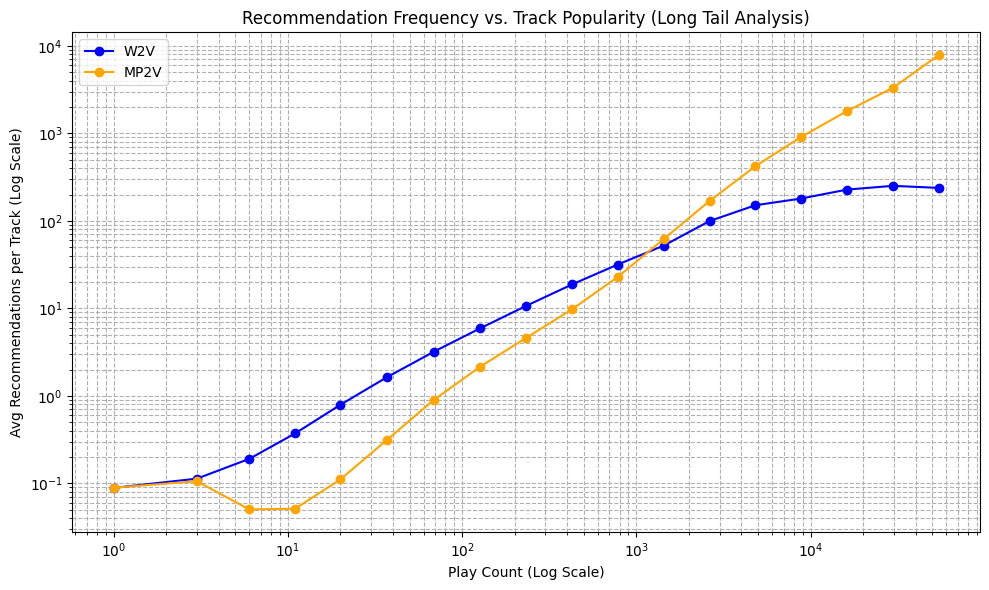

W2V Coverage@100: 0.1919 (Sampled)
MP2V Coverage@100: 0.0886 (Sampled)
Top 10% Tracks Recommended - W2V: nan, MP2V: nan
Bottom 50% Tracks Recommended - W2V: inf, MP2V: inf


In [29]:
# Step 6: Plot recommendation frequency vs. play count bins
plt.figure(figsize=(10, 6))
plt.loglog(bins, w2v_bin_freq, label='W2V', color='blue', marker='o')
plt.loglog(bins, mp2v_bin_freq, label='MP2V', color='orange', marker='o')
plt.title('Recommendation Frequency vs. Track Popularity (Long Tail Analysis)')
plt.xlabel('Play Count (Log Scale)')
plt.ylabel('Avg Recommendations per Track (Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# Step 7: Print coverage and top/bottom recommendation stats
w2v_coverage = len(w2v_rec_counts) / num_tracks
mp2v_coverage = len(mp2v_rec_counts) / num_tracks
print(f"W2V Coverage@100: {w2v_coverage:.4f} (Sampled)")
print(f"MP2V Coverage@100: {mp2v_coverage:.4f} (Sampled)")
print(f"Top 10% Tracks Recommended - W2V: {sum(w2v_bin_freq[:2]):.2f}, MP2V: {sum(mp2v_bin_freq[:2]):.2f}")
print(f"Bottom 50% Tracks Recommended - W2V: {sum(w2v_bin_freq[-10:]):.2f}, MP2V: {sum(mp2v_bin_freq[-10:]):.2f}")

In [ ]:
from collections import Counter
rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
col = adj_data['col_dict'][('user', 'listens', 'track')]
num_tracks = adj_data['num_nodes_dict']['track']
num_users = adj_data['num_nodes_dict']['user']
play_counts = np.bincount(col, minlength=num_tracks)

user_activity = [rowptr[u + 1] - rowptr[u] for u in range(num_users)]
activity_thresholds = np.percentile(user_activity, [25, 75])
cohorts = {u: 'Low' if a < activity_thresholds[0] else 'Medium' if a < activity_thresholds[1] else 'High' 
           for u, a in enumerate(user_activity)}

# Step 2: Sort tracks by popularity and define bins
track_indices = np.arange(num_tracks)
sorted_indices = np.argsort(play_counts)[::-1]
sorted_play_counts = play_counts[sorted_indices]
bins = np.logspace(0, np.log10(max(play_counts) + 1), num=20, dtype=int)
bin_indices = np.digitize(sorted_play_counts, bins, right=True)  # Right=True to include max value
bin_sizes = np.bincount(bin_indices, minlength=len(bins) + 1)[1:]  # Avoid zero bins

In [8]:
# Step 3: Get recommendations per cohort
def get_top_k_recommendations(user_emb, voyager_index, user_ids, k=100):
    batch = user_emb[user_ids]
    neighbors, _ = voyager_index.query(batch, k=k)
    return neighbors

cohort_recs = {'W2V': {}, 'MP2V': {}}
for cohort in ['Low', 'Medium', 'High']:
    cohort_users = [u for u, c in cohorts.items() if c == cohort and u in test_data][:20000]  # 20K per cohort
    cohort_recs['W2V'][cohort] = get_top_k_recommendations(w2v_user_emb, w2v_voyager, cohort_users, k=100)
    cohort_recs['MP2V'][cohort] = get_top_k_recommendations(mp2v_user_emb, mp2v_voyager, cohort_users, k=100)

# Step 4: Count recommendation frequency per track by cohort
w2v_rec_counts = {cohort: Counter(np.concatenate(cohort_recs['W2V'][cohort])) for cohort in ['Low', 'Medium', 'High']}
mp2v_rec_counts = {cohort: Counter(np.concatenate(cohort_recs['MP2V'][cohort])) for cohort in ['Low', 'Medium', 'High']}

# Step 5: Aggregate recommendation frequency by popularity bin and cohort
w2v_bin_freq = {cohort: np.zeros(len(bins)) for cohort in ['Low', 'Medium', 'High']}
mp2v_bin_freq = {cohort: np.zeros(len(bins)) for cohort in ['Low', 'Medium', 'High']}
for cohort in ['Low', 'Medium', 'High']:
    for idx, bin_id in enumerate(bin_indices):
        w2v_bin_freq[cohort][bin_id - 1] += w2v_rec_counts[cohort].get(sorted_indices[idx], 0)
        mp2v_bin_freq[cohort][bin_id - 1] += mp2v_rec_counts[cohort].get(sorted_indices[idx], 0)
    w2v_bin_freq[cohort] = np.where(bin_sizes > 0, w2v_bin_freq[cohort] / bin_sizes, 0)
    mp2v_bin_freq[cohort] = np.where(bin_sizes > 0, mp2v_bin_freq[cohort] / bin_sizes, 0)

/var/tmp/ipykernel_3015/3154550743.py:24: RuntimeWarning: divide by zero encountered in divide
  w2v_bin_freq[cohort] = np.where(bin_sizes > 0, w2v_bin_freq[cohort] / bin_sizes, 0)
/var/tmp/ipykernel_3015/3154550743.py:24: RuntimeWarning: invalid value encountered in divide
  w2v_bin_freq[cohort] = np.where(bin_sizes > 0, w2v_bin_freq[cohort] / bin_sizes, 0)
/var/tmp/ipykernel_3015/3154550743.py:25: RuntimeWarning: divide by zero encountered in divide
  mp2v_bin_freq[cohort] = np.where(bin_sizes > 0, mp2v_bin_freq[cohort] / bin_sizes, 0)
/var/tmp/ipykernel_3015/3154550743.py:25: RuntimeWarning: invalid value encountered in divide
  mp2v_bin_freq[cohort] = np.where(bin_sizes > 0, mp2v_bin_freq[cohort] / bin_sizes, 0)


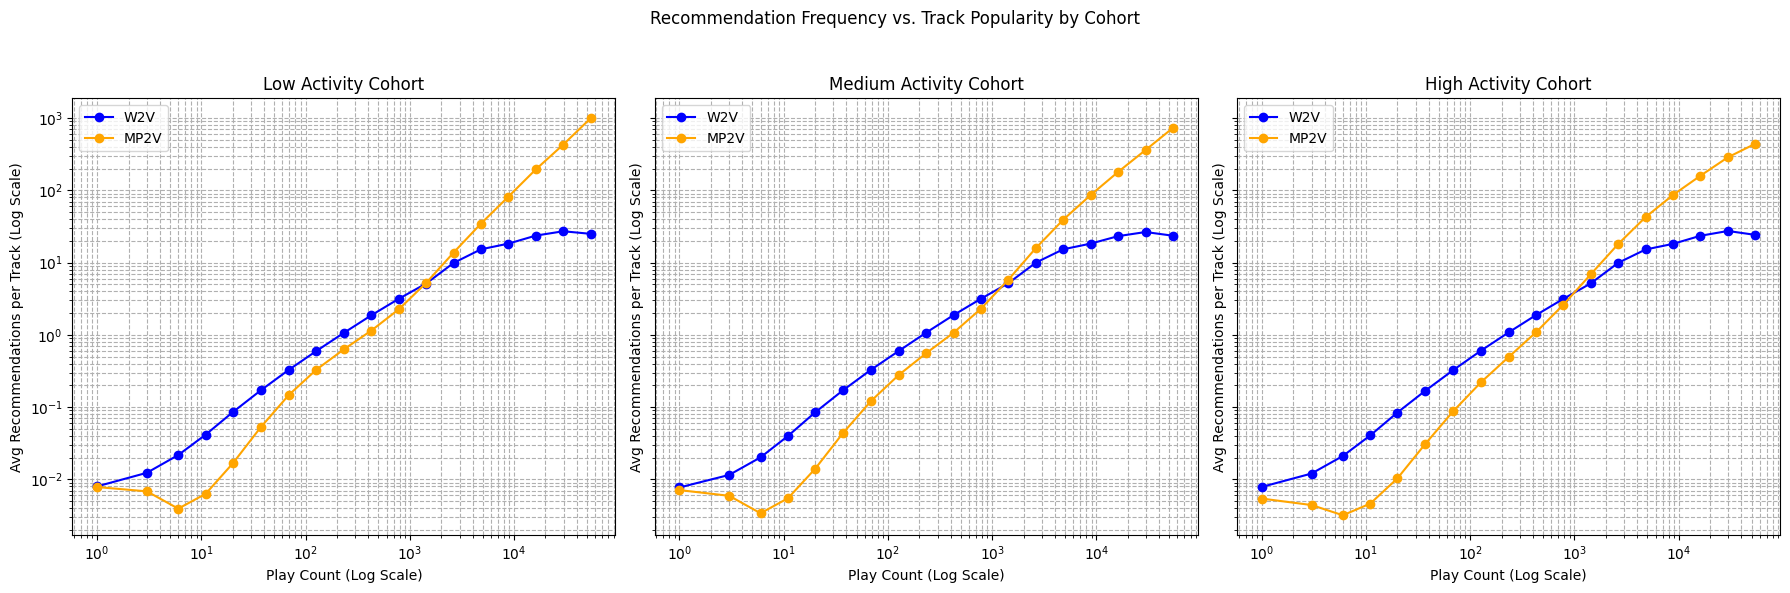


### W2V Cohort Coverage and Stats ###
Low:
  Coverage@100: 0.0596
  Top 10% Tracks Recommended: 0.7992
  Bottom 50% Tracks Recommended: 0.0313
Medium:
  Coverage@100: 0.0592
  Top 10% Tracks Recommended: 0.8034
  Bottom 50% Tracks Recommended: 0.0297
High:
  Coverage@100: 0.0596
  Top 10% Tracks Recommended: 0.8022
  Bottom 50% Tracks Recommended: 0.0306

### MP2V Cohort Coverage and Stats ###
Low:
  Coverage@100: 0.0284
  Top 10% Tracks Recommended: 0.9376
  Bottom 50% Tracks Recommended: 0.0222
Medium:
  Coverage@100: 0.0281
  Top 10% Tracks Recommended: 0.9463
  Bottom 50% Tracks Recommended: 0.0198
High:
  Coverage@100: 0.0281
  Top 10% Tracks Recommended: 0.9594
  Bottom 50% Tracks Recommended: 0.0151


In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, cohort in zip([ax1, ax2, ax3], ['Low', 'Medium', 'High']):
    # Filter non-zero values to avoid log(0)
    w2v_mask = w2v_bin_freq[cohort] > 0
    mp2v_mask = mp2v_bin_freq[cohort] > 0
    ax.loglog(bins[w2v_mask], w2v_bin_freq[cohort][w2v_mask], label='W2V', color='blue', marker='o')
    ax.loglog(bins[mp2v_mask], mp2v_bin_freq[cohort][mp2v_mask], label='MP2V', color='orange', marker='o')
    ax.set_title(f'{cohort} Activity Cohort')
    ax.set_xlabel('Play Count (Log Scale)')
    ax.set_ylabel('Avg Recommendations per Track (Log Scale)')
    ax.legend()
    ax.grid(True, which="both", ls="--")
plt.suptitle('Recommendation Frequency vs. Track Popularity by Cohort')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Step 7: Print coverage and stats
for model in ['W2V', 'MP2V']:
    print(f"\n### {model} Cohort Coverage and Stats ###")
    for cohort in ['Low', 'Medium', 'High']:
        rec_counts = w2v_rec_counts if model == 'W2V' else mp2v_rec_counts
        coverage = len(rec_counts[cohort]) / num_tracks
        top_10pct = sum(rec_counts[cohort].get(i, 0) for i in sorted_indices[:int(0.1 * num_tracks)]) / 20000 / 100
        bottom_50pct = sum(rec_counts[cohort].get(i, 0) for i in sorted_indices[int(0.5 * num_tracks):]) / 20000 / 100
        print(f"{cohort}:")
        print(f"  Coverage@100: {coverage:.4f}")
        print(f"  Top 10% Tracks Recommended: {top_10pct:.4f}")
        print(f"  Bottom 50% Tracks Recommended: {bottom_50pct:.4f}")

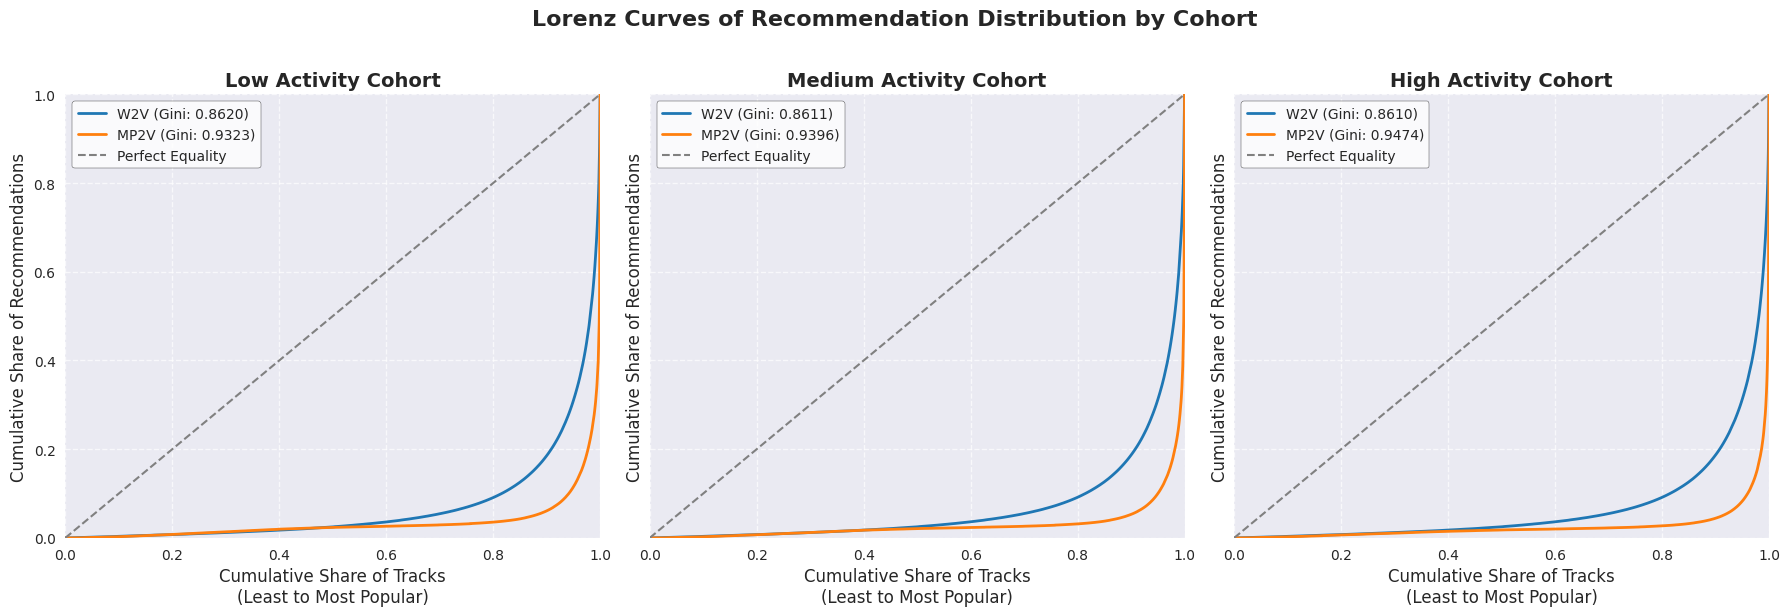

### Gini Coefficients ###

W2V:
  Low: 0.8620
  Medium: 0.8611
  High: 0.8610

MP2V:
  Low: 0.9323
  Medium: 0.9396
  High: 0.9474


In [7]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute track play counts and define user cohorts
rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
col = adj_data['col_dict'][('user', 'listens', 'track')]
num_tracks = adj_data['num_nodes_dict']['track']
num_users = adj_data['num_nodes_dict']['user']
play_counts = np.bincount(col, minlength=num_tracks)

user_activity = [rowptr[u + 1] - rowptr[u] for u in range(num_users)]
activity_thresholds = np.percentile(user_activity, [25, 75])
cohorts = {u: 'Low' if a < activity_thresholds[0] else 'Medium' if a < activity_thresholds[1] else 'High' 
           for u, a in enumerate(user_activity)}

# Step 2: Sort tracks by popularity (least to most popular)
sorted_indices = np.argsort(play_counts)  # Ascending order: least popular to most popular

# Step 3: Get recommendations per cohort
def get_top_k_recommendations(user_emb, voyager_index, user_ids, k=100):
    batch = user_emb[user_ids]
    neighbors, _ = voyager_index.query(batch, k=k)
    return neighbors

cohort_recs = {'W2V': {}, 'MP2V': {}}
for cohort in ['Low', 'Medium', 'High']:
    cohort_users = [u for u, c in cohorts.items() if c == cohort and u in test_data][:50000]  # 20K users per cohort
    cohort_recs['W2V'][cohort] = get_top_k_recommendations(w2v_user_emb, w2v_voyager, cohort_users, k=100)
    cohort_recs['MP2V'][cohort] = get_top_k_recommendations(mp2v_user_emb, mp2v_voyager, cohort_users, k=100)

# Step 4: Count recommendation frequency per track by cohort
w2v_rec_counts = {cohort: Counter(np.concatenate(cohort_recs['W2V'][cohort])) for cohort in ['Low', 'Medium', 'High']}
mp2v_rec_counts = {cohort: Counter(np.concatenate(cohort_recs['MP2V'][cohort])) for cohort in ['Low', 'Medium', 'High']}

# Step 5: Define function for Lorenz Curve and Gini Coefficient
def lorenz_curve(rec_counts, sorted_indices):
    rec_freq = np.array([rec_counts.get(i, 0) for i in sorted_indices])
    cum_rec = np.cumsum(rec_freq)
    total_rec = cum_rec[-1]
    if total_rec == 0:  # Handle edge case of no recommendations
        return np.arange(1, len(sorted_indices) + 1) / len(sorted_indices), np.zeros(len(sorted_indices)), 0
    cum_rec = cum_rec / total_rec  # Normalize to [0,1]
    cum_tracks = np.arange(1, len(sorted_indices) + 1) / len(sorted_indices)
    area_under_curve = np.trapz(cum_rec, cum_tracks)
    gini = 1 - 2 * area_under_curve
    return cum_tracks, cum_rec, gini

# Step 6: Plot Lorenz Curves by cohort with enhanced styling
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, cohort in zip([ax1, ax2, ax3], ['Low', 'Medium', 'High']):
    # W2V Lorenz curve
    w2v_cum_tracks, w2v_cum_rec, w2v_gini = lorenz_curve(w2v_rec_counts[cohort], sorted_indices)
    ax.plot(w2v_cum_tracks, w2v_cum_rec, label=f'W2V (Gini: {w2v_gini:.4f})', color='#1f77b4', linewidth=2)
    # MP2V Lorenz curve
    mp2v_cum_tracks, mp2v_cum_rec, mp2v_gini = lorenz_curve(mp2v_rec_counts[cohort], sorted_indices)
    ax.plot(mp2v_cum_tracks, mp2v_cum_rec, label=f'MP2V (Gini: {mp2v_gini:.4f})', color='#ff7f0e', linewidth=2)
    # Perfect equality line
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Equality', linewidth=1.5)
    
    # Styling
    ax.set_title(f'{cohort} Activity Cohort', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cumulative Share of Tracks\n(Least to Most Popular)', fontsize=12)
    ax.set_ylabel('Cumulative Share of Recommendations', fontsize=12)
    ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='black')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Final adjustments
plt.suptitle('Lorenz Curves of Recommendation Distribution by Cohort', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig('results/SoundCloud/lorenz_curves.png')
plt.show()

# Step 7: Print Gini coefficients for reference
print("### Gini Coefficients ###")
for model in ['W2V', 'MP2V']:
    print(f"\n{model}:")
    for cohort in ['Low', 'Medium', 'High']:
        _, _, gini = lorenz_curve(w2v_rec_counts[cohort] if model == 'W2V' else mp2v_rec_counts[cohort], sorted_indices)
        print(f"  {cohort}: {gini:.4f}")

### Recommendations Sanity Check

In [7]:
import numpy as np
import pandas as pd
from rich.console import Console
from rich.table import Table
from rich.text import Text

rowptr = adj_data['rowptr_dict'][('user', 'listens', 'track')]
col = adj_data['col_dict'][('user', 'listens', 'track')]
num_tracks = adj_data['num_nodes_dict']['track']
num_users = adj_data['num_nodes_dict']['user']

# Initialize rich console
console = Console()

# Load track attributes
combined_df = pd.read_csv("SoundCloud/track_attributes.csv")

# Recommendation function
def get_top_k_recommendations(user_emb, voyager_index, user_ids, k=100):
    batch = user_emb[user_ids]
    neighbors, _ = voyager_index.query(batch, k=k)
    return neighbors

# Compute recall
def compute_recall(recs, test_tracks):
    hits = sum(1 for t in test_tracks if t in recs)
    return hits / len(test_tracks) if test_tracks else 0

# Function to get track info
def get_track_info(track_indices):
    return combined_df[combined_df['track_idx'].isin(track_indices)][['track_idx', 'title', 'genre', 'username']]

# Sample users with at least 5 test tracks
eligible_users = [u for u in test_data.keys() if len(test_data[u]) >= 5]
sample_users = np.random.choice(eligible_users, 10, replace=False)  # Random 10 users

# Get recommendations and compute recall
w2v_recs = get_top_k_recommendations(w2v_user_emb, w2v_voyager, sample_users)
mp2v_recs = get_top_k_recommendations(mp2v_user_emb, mp2v_voyager, sample_users)
w2v_recalls = [compute_recall(w2v_recs[i], test_data[u]) for i, u in enumerate(sample_users)]
mp2v_recalls = [compute_recall(mp2v_recs[i], test_data[u]) for i, u in enumerate(sample_users)]

# Sanity check output with rich formatting
for i, u in enumerate(sample_users):
    train_tracks = col[rowptr[u]:rowptr[u + 1]].numpy()
    test_tracks = test_data[u]
    w2v_rec = w2v_recs[i]
    mp2v_rec = mp2v_recs[i]
    
    w2v_recall = w2v_recalls[i]
    mp2v_recall = mp2v_recalls[i]
    
    # Header
    console.print(f"[bold magenta]### User {u} ###[/bold magenta]")
    console.print(f"[blue]W2V Recall@100: {w2v_recall:.4f}[/blue] | [bright_magenta]MP2V Recall@100: {mp2v_recall:.4f}[/bright_magenta]\n")
    
    # Training Tracks Table
    train_df = get_track_info(train_tracks).head(20)
    train_table = Table(title="Training Tracks", title_style="bold cyan", show_header=True, header_style="bold cyan")
    train_table.add_column("Track ID", style="dim")
    train_table.add_column("Title", style="cyan")
    train_table.add_column("Genre", style="cyan")
    train_table.add_column("Artist", style="cyan")
    for _, row in train_df.iterrows():
        train_table.add_row(
            str(row['track_idx']),
            str(row['title']) if pd.notna(row['title']) else "N/A",
            str(row['genre']) if pd.notna(row['genre']) else "N/A",
            str(row['username']) if pd.notna(row['username']) else "N/A"
        )
    
    # Test Tracks Table
    test_df = get_track_info(test_tracks).head(20)
    test_table = Table(title="Test Tracks", title_style="bold green", show_header=True, header_style="bold green")
    test_table.add_column("Track ID", style="dim")
    test_table.add_column("Title", style="green")
    test_table.add_column("Genre", style="green")
    test_table.add_column("Artist", style="green")
    for _, row in test_df.iterrows():
        test_table.add_row(
            str(row['track_idx']),
            str(row['title']) if pd.notna(row['title']) else "N/A",
            str(row['genre']) if pd.notna(row['genre']) else "N/A",
            str(row['username']) if pd.notna(row['username']) else "N/A"
        )
    
    # W2V Recommendations Table
    w2v_rec_df = get_track_info(w2v_rec).head(20)
    w2v_table = Table(title="W2V Recommendations", title_style="bold blue", show_header=True, header_style="bold blue")
    w2v_table.add_column("Track ID", style="dim")
    w2v_table.add_column("Title", style="blue")
    w2v_table.add_column("Genre", style="blue")
    w2v_table.add_column("Artist", style="blue")
    for _, row in w2v_rec_df.iterrows():
        w2v_table.add_row(
            str(row['track_idx']),
            str(row['title']) if pd.notna(row['title']) else "N/A",
            str(row['genre']) if pd.notna(row['genre']) else "N/A",
            str(row['username']) if pd.notna(row['username']) else "N/A"
        )
    
    # MP2V Recommendations Table
    mp2v_rec_df = get_track_info(mp2v_rec).head(20)
    mp2v_table = Table(title="MP2V Recommendations", title_style="bold bright_magenta", show_header=True, header_style="bold bright_magenta")
    mp2v_table.add_column("Track ID", style="dim")
    mp2v_table.add_column("Title", style="bright_magenta")
    mp2v_table.add_column("Genre", style="bright_magenta")
    mp2v_table.add_column("Artist", style="bright_magenta")
    for _, row in mp2v_rec_df.iterrows():
        mp2v_table.add_row(
            str(row['track_idx']),
            str(row['title']) if pd.notna(row['title']) else "N/A",
            str(row['genre']) if pd.notna(row['genre']) else "N/A",
            str(row['username']) if pd.notna(row['username']) else "N/A"
        )
    
    # Display tables
    console.print(train_table)
    console.print(test_table)
    console.print(w2v_table)
    console.print(mp2v_table)
    console.print("\n" + "-"*80 + "\n")  # Separator

### User 2982499 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0357

                                                  Training Tracks                                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                ┃ Genre     ┃ Artist                          ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 12933262.0 │ Racionais mc's-diario de um detento!                 │ hiphoprap │ GG Tony                         │
│ 8415049.0  │ MC Marcinho :: Ao vivo e pela primeira vez na Roda   │ rbsoul    │ Funk Carioca                    │
│            │ de Funk ::                                           │           │                                 │
│ 9179356.0  │ MÍDIA-Mc Poze do Rodo- Filipe Ret / MC Ryan          │ N/A       │ 𝐓𝐨𝐩 𝐇𝐢𝐭𝐬 𝐃𝐨 𝐌𝐨𝐦𝐞𝐧𝐭𝐨 /  Sigam 🛑 │
│            │ SP/ViperRocco_AIX                                    │           │                                 │
│ 7131561.0  │ MC Poze do Rodo - Me Da Sua Mão (prod. Mandark)      │ hiphoprap │ Roger                           │
│ 2311252.0  │ LUDMILLA - Numanice #3 Ao Vivo                       │ pop       │ branquinha                      │
│            │ (completo)_nmRsGILGMT0.mp3                           │           │                                 │
│ 4104480.0  │ El Bebeto - No Te Creas Tan Importante               │ latin     │ LATIN POWER MUSIC               │
│ 10337908.0 │ Turma Do Pagode - Horário De Verão   Pente E Rala    │ pop       │ PAGODE 2025                     │
│            │ Luz, Cama E Ação (Ao Vivo)                           │           │                                 │
│ 7760399.0  │ Calcinha Preta Dois Amores, Duas paixões             │ pop       │ Download Music                  │
│ 9518401.0  │ BINHO SIMÔES - GENRO PREFERIDO ( DJ PATRÃOZINHO )    │ pop       │ DJ PATRÃOZINHO  ®               │
│            │ TAMBOR CONGA 160BPM                                  │           │                                 │
│ 9316863.0  │ MC Cidinho :: Ao vivo na Roda de Funk de Olaria (Rio │ rbsoul    │ Funk Carioca                    │
│            │ de Janeiro)                                          │           │                                 │
│ 10911924.0 │ Amor de Fim de Noite                                 │ hiphoprap │ Orochi                          │
│ 970863.0   │ Bom Gosto - A Amizade Part: Alexandre Pires          │ pop       │ Pagode & Samba II               │
│ 7458002.0  │ Marília Mendonça - Troca de Calçada                  │ rock      │ APPLE MUSIC                     │
│ 1613542.0  │ Oração                                               │ N/A       │ Nadson O Ferinha                │
│ 1140083.0  │ Marília Mendonça - A Culpa é Dele feat. Maiara e M   │ country   │ Focagem Jornalismo              │
│ 11440318.0 │ Mc Cabelinho - Final de Semana / Dia de Sexta (Ao    │ hiphoprap │ MC CABELINHO                    │
│            │ vivo)                                                │           │                                 │
│ 3174567.0  │ Bebeto - Minha Preta(Alva´s Bootleg)                 │ house     │ Brasil com Beats                │
│ 7409162.0  │ EU SOU CANTOR NÃO SOU BANDIDO - MC Leozinho ZS, MC   │ N/A       │ Ln Relikia Ofc 🍀               │
│            │ Lele JP, MC Joãozinho VT e MC Marks ( speed up )     │           │                                 │
│ 25363.0    │ MC Menor K FT. Ricky Ribeiro- Pique Neymar -         │ hiphoprap │ ZONA TRAP & FUNK                │
│            │ Escutando Matuê (DJ Kewin Lopes)                     │           │                                 │
│ 3936383.0  │ ORUAM - HUMILDADE PRA VENCER  Ft. LZ DA CXD - PIQUE  │ hiphoprap │ RITIMADAS DO RJ                 │
│            │ CRISTIANO RONALDO- SOBRECARREGADO                    │           │                                 │
└────────────┴────────────────────────────────────────────

                                                    Test Tracks                                                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                      ┃ Genre     ┃ Artist                                    ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 2665622.0  │ Oruam · Guerras Constantes 💯 (Prévia      │ N/A       │ MartinStudio - PERFIL 2                   │
│            │ Nova)                                      │           │                                           │
│ 11010090.0 │ Pagode Do Adame - Azul Sem Fim, Eu Não Sou │ latin     │ REI DO PAGODE                             │
│            │ De Me Entregar, Até Ver Você               │           │                                           │
│            │ @PagodedoAdame                             │           │                                           │
│ 4333632.0  │ Tropa Do Mais Novo                         │ hiphoprap │ Chefin                                    │
│ 3975555.0  │ MC PH - Desestressar | Fala No Ouvido Do   │ hiphoprap │ TRAP & RAP | BRAZIL                       │
│            │ PH ( Prévia Nova )                         │           │                                           │
│ 7824514.0  │ 10 - EXAGERO                               │ hiphoprap │ BrunoRecords                              │
│ 1357332.0  │ 14 MINUTOS DE Sorriso Maroto Guerra Fria,  │ pop       │ LC Music                                  │
│            │ Vai e Chora, Sinais,  Cliché               │           │                                           │
│ 1515660.0  │ Instinto                                   │ pop       │ Gamadinho                                 │
│ 5809633.0  │ ELA QUER SENTAR PRO MALVADINHO ( DJ JR DO  │ N/A       │ DJ JR DO MD                               │
│            │ MD ) MC LUUKY - REMIX RJ                   │           │                                           │
│ 6021838.0  │ MC POZE DO RODO - MEDLEY NUNCA VISTO AO    │ hiphoprap │ HIAGO TALIBAN                             │
│            │ VIVO COM TODAS AS MÚSICAS NOVAS MAIS       │           │                                           │
│            │ TOCADAS 2022 CV POZE                       │           │                                           │
│ 9697086.0  │ Pagode do Adame - Entre Amigos - Vol.2     │ pop       │ BAILE DO CAPOTE - TAILÂNDIA               │
│            │ (Completo)                                 │           │                                           │
│ 7928240.0  │ 40 MINUTOS DE NADSON O FERINHA -           │ hiphoprap │ M A T E U S  D J♪  🇱🇺  ✪                  │
│            │ REPERTÓRIO ČÄPÏXÄBÄ Ö HÄČKËR   NOVO 2023   │           │                                           │
│            │ )                                          │           │                                           │
│ 6033471.0  │ MC NEGÃO DA BL - UM TEMPO ATRÁS MINHA MÃE  │ hiphoprap │ sshix                                     │
│            │ ME FALOU QUE SONHOU COMIGO SENDO BALEADO   │           │                                           │
│            │ (R                                         │           │                                           │
│ 2480922.0  │ SOLTA A CARTA TIGRINHO FDP X BEAT VUK VUK  │ N/A       │ DJ LC do Martins                          │
│            │ [ DJs LC DO MARTINS & PL TORVIC ] ]        │           │                                           │
│ 11148871.0 │ MC Poze Do Rodo Ft. Oruam  -  Mundo        │ hiphoprap │ DJ PATRÃOZINHO SÓ PAGODES(CONTA A         │
│            │ Covarde                                    │           │ VENDA)PEGO INSTA                          │
│ 10467051.0 │ Mc Poze do Rodo - RECOMEÇO 👩‍❤️‍💋‍👨 (prod.  │ N/A       │ MUSICAS DO TIKTOK OFICIAL                 │
│            │ Portugal no beat) ÁUDIO OFICIAL          

                                        W2V Recommendations                                         
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                     ┃ Genre ┃ Artist          ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 6877418.0  │ Рем Дигга-Тюльпан                                         │ world │ noyneym         │
│ 12194951.0 │ shAmAn, Тина Кароль - Я тебя не люблю | ніжно не ніжно    │ world │ v_bichurin      │
│ 1084806.0  │ NLO-Танцы                                                 │ world │ _Volkova_       │
│ 8081513.0  │ Тоня Матвієнко-Кульбаби (KAVA Remix)                      │ N/A   │ вєнька 🇺🇦       │
│ 9646144.0  │ TROJAN - Okay Baby                                        │ N/A   │ Sebalsya_Naxui  │
│ 4708911.0  │ WallClan - Пьяные танцы                                   │ world │ WallClan        │
│ 12670494.0 │ Ярмак - Сердце пацана                                     │ world │ prorapru4       │
│ 8664039.0  │ Kamazz Танцуй для меня моя принцесса                      │ world │ kuzya           │
│ 11105698.0 │ NLO - ТАНЦЫ ( Ты такая классная крутишься в пространстве) │ world │ beecore         │
│ 8461297.0  │ 😍❤️СНОВА НОЧЬЮ ТЫ ОДНА❤️                                   │ world │ ❤️kristina❤️      │
│ 3820887.0  │ karat Ой да Slowed.mp3                                    │ N/A   │ User 37944140   │
│ 6845116.0  │ Bula Feat. By SVNV - Тлеет                                │ world │ 𝗣𝗘𝗥𝗦𝗢𝗡𝗔𝗟𝗟𝗬𝗣𝗢𝗛𝗨𝗬 │
│ 6903643.0  │ Я убил для тебя тюльпан                                   │ world │ kriss           │
│ 1116326.0  │ мой белый никотин (MG5.com)                               │ world │ MG5             │
│ 8455152.0  │ Ты Все Что Мне Нужно                                      │ world │ Aiddas          │
│ 6764199.0  │ Он уходил, она в след кричала ❤                           │ world │ Lyrics World    │
│ 1117398.0  │ JaSkaz & A.Sergeev - Там Где Рассвет.                     │ N/A   │ Innessa         │
│ 9621614.0  │ Ицык Цыпер feat. Игорь цыба - Дымок.mp3                   │ world │ 🍉 HBK🪯        │
│ 166998.0   │ Демоны                                                    │ world │ 10AGE           │
│ 8281044.0  │ Агутин Остров (R&B remix)                                 │ N/A   │ ДАНЯ КОДА       │
└────────────┴───────────────────────────────────────────────────────────┴───────┴─────────────────┘

                                               MP2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                      ┃ Genre     ┃ Artist                                    ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10013946.0 │ Azul Sem Fim / Eu Não Sou de Me Entrega /  │ pop       │ PAGODE DO ADAME                           │
│            │ Até Ver Você / Será Que É Amor / Mande um  │           │                                           │
│            │ Sinal                                      │           │                                           │
│ 290589.0   │ MCs ORUAM GW DAONZE - DINHEIRO DO TIGRINHO │ N/A       │ DJ BELÃO DO APOLO 🔞✌️🤬                   │
│            │ ((DJBELÃODOAPOLO)) #TROPADOURSO            │           │                                           │
│ 1816017.0  │ Mari Fernandez - PÁGINA DE EX (Mari No     │ latin     │ Krispy Music                              │
│            │ Barzinho)                                  │           │                                           │
│ 11878475.0 │ LUDMILLA - Era Tão Bom (So Sick) -         │ pop       │ Clemente Martins                          │
│            │ Numanice #3                                │           │                                           │
│ 12455230.0 │ Pagode do Adame_ Gamadinho - Não Tem Hora  │ N/A       │ LN                                        │
│            │ Nem Lugar, Por Favor, Amor a Três I Entre  │           │                                           │
│            │ Amigos                                     │           │                                           │
│ 9138781.0  │ Nosso Sentimento - Namoro Escondido / Por  │ pop       │ Fabinho                                   │
│            │ Amar Você                                  │           │                                           │
│ 2326348.0  │ Nosso sentimento   Vai embora ( + Letra )  │ pop       │ RaelSantos                                │
│ 1749394.0  │ Oruam ft. Zé Felipe, Mc Tuto, Rodrigo do   │ N/A       │ TRAP DE RUA                               │
│            │ CN "OH GAROTA QUERO VOCE SO PRA MIM"       │           │                                           │
│            │ (prod. DJ LC da Roça)                      │           │                                           │
│ 9154935.0  │ Sobrenome (Ao vivo)                        │ pop       │ Vitinho                                   │
│ 11561867.0 │ Nosso Sentimento - O Amor Venceu           │ pop       │ Radio PagodeFM                            │
│ 10147755.0 │ Lua e Marte (Ao Vivo)                      │ pop       │ Vitinho                                   │
│ 10563722.0 │ MELHORES TRAP 2024 - CABELINHO, L7NNON,    │ N/A       │ DJ PSICO DE CAXIAS ( TROPA DA PARMA ) 🇪🇸  │
│            │ POZE, MC RYAN SP, VEIGH, ORUAN, CHEFIN,    │           │                                           │
│            │ FILIPE RET, MC PH                          │           │                                           │
│ 10521935.0 │ SÓ PRECISO DE DINHEIRO PRA COMPRAR O MÉ O  │ N/A       │ 𝐓𝐨𝐩 𝐇𝐢𝐭𝐬 𝐃𝐨 𝐌𝐨𝐦𝐞𝐧𝐭𝐨 🌍 𝐂𝐨𝐧𝐭𝐚 / 02 🥇      │
│            │ LEITE DAS CRIANÇAS - E SÓ FÉ E O GRELO -   │           │                                           │
│            │ GRELO DA SERESTA                           │           │                                           │
│ 884607.0   │ MC CAJA == MEU BIGODIN TRALHA (DJNEM)      │ hiphoprap │ DJ NEM DO DICK                            │
│            │ FAIXA 20 MIN                               │           │                                           │
│ 7122669.0  │ Pagode do Zero19 - Boa Noite / Eu Não Sou  │ pop       │ DJ PATRÃOZINHO SÓ PAGODES(CONTA A         │
│            │ de Me Entregar / Engano / Faz Assim /      │

--------------------------------------------------------------------------------

### User 5833337 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0000

                                                Training Tracks                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                          ┃ Genre      ┃ Artist           ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 5311062.0  │ Astéroïde - Matoux, Teuteu & Joël Fajerman                     │ electronic │ Players Records  │
│ 10312978.0 │ Duwap Kaine - Down  (Prod. CRYJNG)                             │ hiphoprap  │ sadistic         │
│ 4482210.0  │ 180 Days (feat. Snoop Dogg)                                    │ hiphoprap  │ Curren$y Spitta  │
│ 10280292.0 │ Cartier'GOD X lil shine #tellnobody prod. By futuristic'Ideasz │ hiphoprap  │ shine            │
│ 124304.0   │ ATL Smook - Vlone (TrapBoyTango)                               │ hiphoprap  │ TrapBoyTango     │
│ 625120.0   │ Topanga State of Mind                                          │ rock       │ George Clanton   │
│ 1064665.0  │ rudeboicozy - LAgangops220 prod. mojio                         │ hiphoprap  │ Mojio            │
│ 910131.0   │ Crystal Clear                                                  │ hiphoprap  │ Rio Da Yung OG   │
│ 1031368.0  │ Loaded                                                         │ hiphoprap  │ Lil Uzi Vert     │
│ 1117027.0  │ ATL SMOOK - Out Of Reach Freestyle (prod. Akachi & Badmon56k)  │ hiphoprap  │ Akachi           │
│ 2858686.0  │ Juicy J - Stoner's Night, Part 2 (feat. Wiz Khalifa)           │ hiphoprap  │ Harco            │
│ 9596562.0  │ weiland - twice (prod. taz taylor) *snippet*                   │ hiphoprap  │ WEILAND ARCHIVE  │
│ 8545224.0  │ Long day (kdoza & equallyminded)                               │ hiphoprap  │ lamont galore    │
│ 3379438.0  │ lil flash - say dat (p. chief keef) *CALVIN EXCLUSIVE*         │ hiphoprap  │ calvin           │
│ 254160.0   │ RXK NEPHEW & TONY SHHNOW - PUT ON + AIM 4 DA TOP               │ hiphoprap  │ @g1mmegreen      │
│ 6590293.0  │ ShittyBoyz (BabyTron) - Cheat Code                             │ hiphoprap  │ COOKIE DROP      │
│ 10381637.0 │ LINO - RICO ;’(PROD. GEEKHEAD + XANGANG)                       │ hiphoprap  │ Lino Da RockStar │
│ 60012.0    │ Crazy Man (Lifted + Zach808)                                   │ hiphoprap  │ ATL SMOOK        │
│ 3544069.0  │ Ricky wit some yeezys                                          │ hiphoprap  │ stacy money      │
│ 371697.0   │ 06 Smoke Sum'n                                                 │ hiphoprap  │ Lazmayne         │
└────────────┴────────────────────────────────────────────────────────────────┴────────────┴──────────────────┘

                                                  Test Tracks                                                   
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                    ┃ Genre      ┃ Artist                  ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 9025122.0  │ Teriyaki Boyz I Still Love Her Feat Kanye West           │ hiphoprap  │ Alctiraz                │
│ 11334279.0 │ anchor store                                             │ rock       │ N. Hell                 │
│ 685526.0   │ NGEEYL x SLIMEDOLLAZ - FAXTZ                             │ hiphoprap  │ NGeeYL                  │
│ 1622335.0  │ Cliqued Up ft. Caspr                                     │ hiphoprap  │ stacy money             │
│ 271923.0   │ WATCH OUT (DIGITS REMIX)                                 │ N/A        │ Dylvinci                │
│ 11953725.0 │ 22                                                       │ hiphoprap  │ GLIZZY F BABY           │
│ 8031504.0  │ 10kkev - Topanga                                         │ N/A        │ Cloud Bops (@cloudbops) │
│ 9553380.0  │ everyday - destroy lonely                                │ hiphoprap  │ 🩸                      │
│ 472876.0   │ no existence feat marjorie -w.c. sinclair                │ hiphoprap  │ Souljah Star            │
│ 9155567.0  │ P Side                                                   │ N/A        │ lilxelly                │
│ 8597329.0  │ 10kkev - Come Wit It                                     │ N/A        │ Cloud Bops (@cloudbops) │
│ 9660831.0  │ Duwap Kaine - Trampa De La Casa                          │ hiphoprap  │ hitz                    │
│ 2326937.0  │ Playboi Carti - Yah Mean (TUNNELVISION EDIT)             │ hiphoprap  │ TUNNELVISION            │
│ 3802186.0  │ from da “heart” (ElijahWho)                              │ hiphoprap  │ lilxelly                │
│ 4443826.0  │ LAZER DIM 700 - godly lookin                             │ hiphoprap  │ LAZER DIM 700           │
│ 5087388.0  │ Night Owl (Prod. Paymels & Faygocb)                      │ N/A        │ XANMAN$HAWTY            │
│ 10361517.0 │ LTJ Bukem ― Demon's Theme (7:17)                         │ electronic │ user793617969           │
│ 3401077.0  │ FLEXICAN GUDDA LUV [PROD BY HORSEHEAD]                   │ hiphoprap  │ BLACK KRAY MUSIC        │
│ 10193840.0 │ Kane Grocerys - She Love Da Way Dat I Jugg (Prod F1lthy) │ hiphoprap  │ DANK SWISHERS           │
│ 9842390.0  │ This Is Sokudo                                           │ rbsoul     │ Devin Morrison          │
└────────────┴──────────────────────────────────────────────────────────┴────────────┴─────────────────────────┘

                                               W2V Recommendations                                               
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                       ┃ Genre     ┃ Artist                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 190444.0   │ SummerGroove #2                                             │ N/A       │ Rogs                   │
│ 2173498.0  │ MAUDIE | SUNCHASERS 09.11.24                                │ N/A       │ MAUDIE                 │
│ 11353635.0 │ Eva Vrijdag | Forza | Vierdaagsefeesten 15.07.24            │ N/A       │ Eva Vrijdag            │
│ 10432609.0 │ Pegassi | Nooduitgang Summer Sessions | Bloemendaal aan Zee │ N/A       │ NOODUITGANG            │
│ 1270703.0  │ TIME OUT                                                    │ hiphoprap │ Rilès                  │
│ 9988812.0  │ MARLON HOFFSTADT LIVE @ AMF 2024                            │ N/A       │ Sytse Brentjes         │
│ 12263359.0 │ Benwal @ F_AKE Barcelona 02.04.2022                         │ house     │ Benwal                 │
│ 12142037.0 │ Bad Boombox | Boiler Room: Ghent                            │ house     │ Boiler Room            │
│ 9216186.0  │ Selected by APRD 001 | Hard House & Trance Mix              │ N/A       │ APRD                   │
│ 58732.0    │ Tryton X Something - TnT Mashup                             │ N/A       │ TnT                    │
│ 8659193.0  │ Baron Von Trax ｜ HÖR Berlin - May 20 ⧸ 2024                │ N/A       │ Baron Von Trax         │
│ 3472715.0  │ Dopamin'                                                    │ house     │ BAVAKI                 │
│ 3332049.0  │ Benwal @ Die Rakete, RADION - 05.05.2023                    │ techno    │ Benwal                 │
│ 3569805.0  │ Luca v/d Hombergh & Six Feet Up | 18-05-24 | Traplab Radio  │ N/A       │ TrapLab Radio          │
│ 1769426.0  │ STAMPPOT hardhouse / eurotrance                             │ house     │ STAMPPOT               │
│ 4053252.0  │ EVA VRIJDAG @ SUBCULTUUR NYE 2024                           │ house     │ 𝙎𝙐𝘽𝘾𝙐𝙇𝙏𝙐𝙐𝙍             │
│ 3570394.0  │ LIVING ROOM SET - BLIJ HUIS (Hardhouse/Eurotrance)          │ N/A       │ The Funkmoore Brothers │
│ 1060797.0  │ Boy In The Picture (Hard Trance Rework)                     │ house     │ Niek Hagen             │
│ 488594.0   │ LAMMER // Construct podcast -EP007                          │ N/A       │ Construct              │
│ 3312526.0  │ Misschien (Kwijt) (Freddi Remix)                            │ N/A       │ Gotu Jim               │
└────────────┴─────────────────────────────────────────────────────────────┴───────────┴────────────────────────┘

                                               MP2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                               ┃ Genre     ┃ Artist                           ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 5444608.0  │ Imagination (with Young Mellow)                     │ hiphoprap │ BATY                             │
│ 10680696.0 │ Seasons (通常の速度 )                               │ world     │ J1glock                          │
│ 5602854.0  │ childhood                                           │ hiphoprap │ eyden                            │
│ 11624177.0 │ AIRIE campstage ラップスタア2024                    │ N/A       │ Shakabosefanboy                  │
│ 12213701.0 │ Who Can feat. Fla$hBackS (Prod. by KID FRESINO)     │ hiphoprap │ SKM0tty                          │
│ 4462765.0  │ 会いたくて 会いたくて 湾岸remix                     │ N/A       │ かりなん                         │
│ 6033688.0  │ Backwoods Ft.Brrrsos (enrgybeats)                   │ hiphoprap │ juggrixhSentana(@juggboisentana) │
│ 3541149.0  │ 5lack - 東京銀河 | Remix                            │ world     │ gaison beats                     │
│ 5341951.0  │ Real ninjaz only (prod.Lil G )                      │ hiphoprap │ juggrixhSentana(@juggboisentana) │
│ 11521530.0 │ Top freestyle fujitaito .goantenna                  │ hiphoprap │ BrizaYavaisz Daze                │
│ 7950238.0  │ blue candy⭐︎                                        │ N/A       │ NillNico                         │
│ 7225472.0  │ 8                                                   │ N/A       │ ELTRUT GAW                       │
│ 11214573.0 │ CHOUJI  （ガンジャremix）                           │ world     │ G                                │
│ 4901059.0  │ Don't Forget (16FLIP Remix) - WILYWNKA ft ISSUGI    │ world     │ 16FLIP                           │
│ 9456237.0  │ Fla$hBackS Mix (jjj,febb as young mason,kid         │ hiphoprap │ ootsuka                          │
│            │ fresino)                                            │           │                                  │
│ 3816616.0  │ WHERE IS LOVE                                       │ rbsoul    │ 3House                           │
│ 8844040.0  │ Yvng xan & J1rock - by my side （prod. yung         │ hiphoprap │ Yvng xan                         │
│            │ dan）サブスク配信中Apple Music spotify など         │           │                                  │
│ 10990952.0 │ Scarif (Packs and Potions Remix）                   │ hiphoprap │ JUMADIBA                         │
│ 3870431.0  │ flyfall INTRO -Season- Prod.jjj -                   │ hiphoprap │ JJJ                              │
│            │ Fla$hBackS(jjj,Febb As Young Mason)from FLYFALL     │           │                                  │
│ 10036181.0 │ KOHH-Taiyo-Remix -feat.-LEX-                        │ hiphoprap │ Lotus                            │
└────────────┴─────────────────────────────────────────────────────┴───────────┴──────────────────────────────────┘

--------------------------------------------------------------------------------

### User 2940839 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0000

                                                 Training Tracks                                                 
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                    ┃ Genre      ┃ Artist                   ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 3004985.0  │ GOD TOLD ME                                              │ N/A        │ Lil Bo 954               │
│ 8148804.0  │ Old Flow                                                 │ N/A        │ Trapland Pat             │
│ 12978295.0 │ Enigma - Sadness Part 1 - 2-3                            │ electronic │ BatShitCat               │
│ 8081856.0  │ PRIMEE                                                   │ hiphoprap  │ HmtTray                  │
│ 10210868.0 │ Glo Getta Ft Ysl KashLaFlexx - Nun New(In The Stu Ep)    │ hiphoprap  │ Glo Getta                │
│ 4546917.0  │ Baby Smoove - 5.7                                        │ hiphoprap  │ @Awfuloscar              │
│ 117788.0   │ Warn You (Prod. by DODBH & DDOT)                         │ hiphoprap  │ Mari Montana             │
│ 9605814.0  │ THE WAY THINGS GOING                                     │ hiphoprap  │ Future                   │
│ 9199262.0  │ Juggin in traffic                                        │ hiphoprap  │ Spliffjit                │
│ 10158919.0 │ Larry Birdo                                              │ hiphoprap  │ YSR Gramz                │
│ 7824132.0  │ Baby Smoove - Tim & Ginobili (Prod. By Michigan Meech)   │ hiphoprap  │ Baby Smoove              │
│ 8324341.0  │ National Anthem                                          │ hiphoprap  │ Wam SpinThaBin           │
│ 2498746.0  │ All Drac’s                                               │ hiphoprap  │ Lil Bo 954               │
│ 2234301.0  │ Juice WRLD - Cerebral                                    │ hiphoprap  │ Juice WRLD               │
│ 1276039.0  │ No Interviews                                            │ hiphoprap  │ Lil Durk                 │
│ 5189893.0  │ Glo Getta ft Kenzowop - p30                              │ hiphoprap  │ Glo Getta                │
│ 4594078.0  │ Drake ~ Days In The East                                 │ hiphoprap  │ octobersveryown          │
│ 7923167.0  │ RJ Lamont Feat. Rio Da Yung Og &amp; RMC Mike What Up RJ │ hiphoprap  │ PrinceTatted300          │
│ 5908053.0  │ Natural Mystic                                           │ reggae     │ Bob Marley & The Wailers │
│ 6624141.0  │ Chosen One                                               │ N/A        │ Loe Shimmy               │
└────────────┴──────────────────────────────────────────────────────────┴────────────┴──────────────────────────┘

                                                Test Tracks                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                             ┃ Genre     ┃ Artist                     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 4546917.0  │ Baby Smoove - 5.7                                 │ hiphoprap │ @Awfuloscar                │
│ 9503331.0  │ Star                                              │ hiphoprap │ T9ine                      │
│ 7707860.0  │ Glo Getta - Zack & Cody                           │ hiphoprap │ Glo Getta                  │
│ 2174674.0  │ Really rich Swift jitt                            │ hiphoprap │ Justin O'Neal              │
│ 1424931.0  │ Trapland Pat - Eater                              │ N/A       │ Trapland Pat               │
│ 541722.0   │ DOPE DEALER                                       │ N/A       │ Lil Bo 954                 │
│ 6246052.0  │ Glo Getta - Mood                                  │ hiphoprap │ Glo Getta                  │
│ 3152311.0  │ GLO GETTA FT KIDD FO - GLO UP                     │ hiphoprap │ Glo Getta                  │
│ 6282110.0  │ Swift Jitt -dollabetic                            │ hiphoprap │ ‎                           │
│ 4479610.0  │ Glo Getta- 392 Muzik                              │ hiphoprap │ Glo Getta                  │
│ 10574110.0 │ Off Season                                        │ hiphoprap │ YoungBoy Never Broke Again │
│ 12348706.0 │ Glo Getta - Fuck Rap                              │ hiphoprap │ Glo Getta                  │
│ 4397893.0  │ Bad Morning                                       │ hiphoprap │ YoungBoy Never Broke Again │
│ 7273183.0  │ GLO GETTA - JOHN CENA                             │ hiphoprap │ Glo Getta                  │
│ 9902158.0  │ Glo Getta ft North Miami Baby- Glo Gettin         │ hiphoprap │ Glo Getta                  │
│ 8521445.0  │ nba youngboy - all the problems (slowed + reverb) │ hiphoprap │ clues 4                    │
│ 11743328.0 │ Chicken Phone                                     │ N/A       │ Wizz Havinn                │
│ 12729263.0 │ THANKFUL  X GLO GETTA                             │ N/A       │ iluvbani                   │
│ 8838400.0  │ Glo Getta - Chosen One                            │ hiphoprap │ Glo Getta                  │
│ 3798357.0  │ Whip It (feat. Glo Getta)                         │ hiphoprap │ MULA MITCH                 │
└────────────┴───────────────────────────────────────────────────┴───────────┴────────────────────────────┘

                                                W2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                              ┃ Genre     ┃ Artist                            ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 11718101.0 │ Bradsou Bradsa zafèm                               │ hiphoprap │ Yahknow Empire studio             │
│ 1352100.0  │ Rèv Kanaval 2022  - Ti Pay - Gadon'w Leta.mp3      │ hiphoprap │ Fredelin Francois                 │
│ 10812527.0 │ "En Dernier" Kikko Lyrics Feat Guy Wewe Official   │ hiphoprap │ Djpiklizofficial                  │
│            │ Music Video                                        │           │                                   │
│ 8031181.0  │ Move Chofè - BEDJINE & K-DILAK                     │ N/A       │ Real Prod Haiti                   │
│ 7347617.0  │ Manvi Bow - K-DILAK & BEDJINE                      │ N/A       │ Real Prod Haiti                   │
│ 11344450.0 │ Nou Pa Moun Ankor                                  │ hiphoprap │ Teamgwes                          │
│ 10240278.0 │ BEST MIXTAPE COMPAS 2024 DJ PIPAUL                 │ hiphoprap │ DJ PIPAUL                         │
│ 1851767.0  │ Zenglen- Gratitude                                 │ hiphoprap │ samyyy Haiti                      │
│ 1402733.0  │ DIEUVIX LANMOU BEL SAN MAKIYAJ                     │ rbsoul    │ Gwo Lyon Promo                    │
│ 4247589.0  │ K-DILAK & BEDJINE ( PREFERE) album 2024            │ N/A       │ sonlaria                          │
│ 12012944.0 │ Men Manmi Tololo                                   │ pop       │ Djmanumix Bodeget (Met ville la ) │
│ 6992402.0  │ Ti Lunet Fò M Alé [Mp3freex.co].mp3                │ hiphoprap │ SamNJ                             │
│ 7919059.0  │ 48 Rebecca Medjy Enposib mixed by DJ Belomix |     │ country   │ DJ Belomix Sipèsta                │
│            │ Soperiye • jou dega • bad gyal • mèsi bokou •      │           │                                   │
│            │ konsèy                                             │           │                                   │
│ 2601228.0  │ EKIP MUSIQ MAKIYE MIZÈW ALBUM MIXTAPE 2024         │ hiphoprap │ Dj Ando Mix Haïti                 │
│ 2710917.0  │ Manyen M La - Darline Desca & Kenny Haiti          │ N/A       │ Real Prod Haiti                   │
│ 10047287.0 │ KreyolLa - No Drama.m4a                            │ N/A       │ Hervierj                          │
│ 12058067.0 │ Mixtape Compas Love Varietes 2024                  │ hiphoprap │ Dj-patience- Mix                  │
│ 9177241.0  │ Lanmou Entènèt                                     │ hiphoprap │ FleshOfficiel                     │
│ 5550776.0  │ BEDJINE ( MAP RET AK TET MWEN ) album 2024.mp3     │ N/A       │ sonlaria                          │
│ 943672.0   │ JEEJEE -VIN KOURI SOU MWEN                         │ N/A       │ ZF                                │
└────────────┴────────────────────────────────────────────────────┴───────────┴───────────────────────────────────┘

                                           MP2V Recommendations                                           
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                    ┃ Genre     ┃ Artist             ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 8699294.0  │ Closure EP - 05 Some Time Away                           │ hiphoprap │ Kodak Black        │
│ 6562229.0  │ What The Business Is                                     │ hiphoprap │ Babyface Ray       │
│ 4863755.0  │ Burn It Up                                               │ N/A       │ Kodak Black        │
│ 9002402.0  │ Don't Run                                                │ N/A       │ Loe Shimmy         │
│ 11936186.0 │ Money On My Mind                                         │ hiphoprap │ Babyface Ray       │
│ 10486890.0 │ Safe Route                                               │ hiphoprap │ Loe Shimmy         │
│ 2833587.0  │ WY@                                                      │ rbsoul    │ Brent Faiyaz       │
│ 12119027.0 │ Omega                                                    │ hiphoprap │ Kodak Black        │
│ 5088091.0  │ Keep on Gettin It                                        │ hiphoprap │ Real Boston Richey │
│ 10400716.0 │ Pop Yo Shit                                              │ hiphoprap │ Veeze              │
│ 4156549.0  │ Wok & Minute Maid (Unplugged)                            │ hiphoprap │ Loe Shimmy         │
│ 11872934.0 │ HIM ALL ALONG                                            │ N/A       │ Gunna              │
│ 749126.0   │ 10. Signs (Produced by Rooq)                             │ hiphoprap │ Kodak Black        │
│ 10401742.0 │ Get Away (feat. Loe Shimmy)                              │ hiphoprap │ Kodak Black        │
│ 971447.0   │ Needing Something                                        │ hiphoprap │ Kodak Black        │
│ 6538337.0  │ Cognitive                                                │ hiphoprap │ Kodak Black        │
│ 5534627.0  │ MUTT                                                     │ N/A       │ leonthomas         │
│ 6048759.0  │ Kodak Black - No Attempt Ft. Wizdawizard & Wamspinthabin │ hiphoprap │ Hot Hip Hop Music  │
│ 5240107.0  │ Ron Artest                                               │ hiphoprap │ Babyface Ray       │
│ 5338376.0  │ When Vultures Cry                                        │ hiphoprap │ Kodak Black        │
└────────────┴──────────────────────────────────────────────────────────┴───────────┴────────────────────┘

--------------------------------------------------------------------------------

### User 552418 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0250

                                                  Training Tracks                                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                             ┃ Genre      ┃ Artist            ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 6119153.0  │ Winter (slowed)                                                   │ N/A        │ Autxmn Love       │
│ 7853791.0  │ Триада - свет не горит                                            │ world      │ slavaa.22         │
│ 11944123.0 │ Баста - На Заре (Альянс Cover)                                    │ world      │ Gazgolder Records │
│ 7438243.0  │ Привет                                                            │ world      │ MATRANG           │
│ 340563.0   │ Allj(Элджей) - А Меня Манят Ваши Города                           │ world      │ CHAPLIN FM        │
│ 9447895.0  │ 33 37Hz Скриптонит Feat Andy Panda, 104 Screwed Привычка          │ world      │ n2k               │
│ 6492639.0  │ Каждый раз                                                        │ world      │ Монеточка         │
│ 4002382.0  │ Mr. Saxobeat                                                      │ hiphoprap  │ Zhiro             │
│ 3463659.0  │ Баста, Смоки Мо И Скриптонит - Долби Мой Лед                      │ world      │ KJlACCNK          │
│ 9032529.0  │ БПАН                                                              │ world      │ ❤dzh3ffprod.      │
│ 804585.0   │ Kambulat - О ком-то                                               │ world      │ FlanzyEdits       │
│ 4523209.0  │ Marc Acardipane, (Feat. Dayerteq) - Return To Beztebya Super      │ electronic │ Dayerteq          │
│            │ Slowed Reverb                                                     │            │                   │
│ 835056.0   │ RIDER                                                             │ hiphoprap  │ NEWLIGHTCHILD     │
│ 12758766.0 │ Niels De Vries - 12 inch (Slowed + pitched down) (rocco bass-t    │ house      │ TPOJL             │
│            │ remix)                                                            │            │                   │
│ 12205615.0 │ Мутант ъхвлам - Это не та планета                                 │ world      │ Toni              │
│ 2803779.0  │ Май                                                               │ world      │ MACAN             │
│ 12118634.0 │ Yung Trappa - Я люблю ее как, деньги сук и дурь (Ульяна)          │ world      │ kamixwk           │
│ 2404222.0  │ [♥~♫~-‎Лезгинка~♫~♥]‎                                               │ world      │ Varouqa           │
│ 8530930.0  │ Мой Вавилон                                                       │ world      │ lmnshe            │
│ 10750195.0 │ Гостиница «Космос» (Prod. Fortnoxpockets)                         │ world      │ mnogoznaal        │
└────────────┴───────────────────────────────────────────────────────────────────┴────────────┴───────────────────┘

                                                    Test Tracks                                                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                               ┃ Genre      ┃ Artist                          ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10735806.0 │ 𝐬𝐨𝐚𝐩&𝐬𝐤𝐢𝐧 - 𝐦𝐞 𝐚𝐧𝐝 𝐭𝐡𝐞 𝐝𝐞𝐯𝐢𝐥 (𝐬𝐥𝐨𝐰𝐞𝐝)               │ world      │ 𝙢𝙚𝙡                             │
│ 3500586.0  │ Schiller - Ruhe                                     │ electronic │ OK! Good Records                │
│ 489831.0   │ ZippO - Каждое Утро                                 │ world      │ DmitryDAN                       │
│ 2402904.0  │ Цепи | bass boosted                                 │ world      │ 𝑼🅺︎R҉𝒜𝓘N̺͆𝐸                         │
│ 4584962.0  │ Новый день                                          │ world      │ Miyagi & Эндшпиль               │
│ 8675569.0  │ trytofriend (prod. cloudly006)                      │ world      │ FORTUNA 812                     │
│ 5660836.0  │ я хочу лететь еще выше                              │ world      │ spens1v                         │
│ 7897736.0  │ MiyaGi  Эндшпиль x МанТана - Моя банда              │ world      │ DAMUSIC✅                       │
│ 3180814.0  │ На дому                                             │ world      │ Макс Корж                       │
│ 8367469.0  │ УННВ - Фрэш                                         │ world      │ УННВ                            │
│ 12340215.0 │ blair - teeth (㇏(•̀ᵥᵥ•́)ノ) faangs                   │ N/A        │ xMomss - products pornographers │
│ 8002799.0  │ Лёша Джей - Дует  Low Bass By Matrix  52-58Hz       │ world      │ 001eugene                       │
│ 6247858.0  │ ты сегодня нежно смотришь, а потом невинно бросишь  │ N/A        │ şeva berfê                      │
│ 1673786.0  │ MiyaGi & Andy Panda - В Последний Раз               │ world      │ BLVCK MUSIC                     │
│ 7315676.0  │ Макс Корж - Пролетарка                              │ world      │ Respect Production              │
│ 2563906.0  │ отьебись                                            │ N/A        │ sSs🔥                           │
│ 3578967.0  │ MiyaGi & Эндшпиль - За Идею ♛                       │ world      │ Madridista                      │
│ 6073128.0  │ she will - lil wayne feat. drake (instrumental      │ N/A        │ axlovedbyyou                    │
│            │ tiktok edit)                                        │            │                                 │
│ 8042362.0  │ Голодный пёс ft. SEEMEE                             │ world      │ SODA LUV                        │
│ 3139945.0  │ Макс Корж — Время                                   │ world      │ Respect Production              │
└────────────┴─────────────────────────────────────────────────────┴────────────┴─────────────────────────────────┘

                                           W2V Recommendations                                            
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                     ┃ Genre     ┃ Artist            ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 4517649.0  │ NONT TANONT - คลั่งเธอ (Dopamine)                           │ N/A       │ Ju5t heR begg1ng. │
│ 1653696.0  │ เรื่องรักระหว่างเรา 2024 - Jayrun                             │ world     │ darlene           │
│ 99182.0    │ Iran-sara - ایرانسرا                                      │ world     │ Babak Rajabi      │
│ 4384026.0  │ deasy- ถึงเธอไม่มีเขาเราก็ไม่ได้รักกันอยู่ดี (Pity)                  │ world     │ Ju5t heR begg1ng. │
│ 5851634.0  │ อาหมวยหาย (阿妹走 / Chinese Girl)                         │ world     │ หทัยชนก อินซอง      │
│ 6879495.0  │ MEYOU - คิขุอาโนเนะ KIKU                                    │ hiphoprap │ 17 13             │
│ 1723687.0  │ The TOYS - เวลาขับรถ                                       │ world     │ Ablacx            │
│ 6970463.0  │ missed calls                                              │ pop       │ GENA DESOUZA      │
│ 2925637.0  │ Mater Dei                                                 │ world     │ No Bio Yet        │
│ 3431906.0  │ 09 ดอกไม้ไฟ - Mirrr                                        │ world     │ Benjaporn Nincum  │
│ 9070861.0  │ SARAN x The BESTS - ฉันยังอยู่                                │ hiphoprap │ YTM               │
│ 218071.0   │ VICTOR - เริ่มก่อน (If I Could)                              │ N/A       │ `๓                │
│ 4290465.0  │ คุณและคุณเท่านั้น-แกงส้ม(cover.youngk!ll)                       │ world     │ YoungK!LL         │
│ 7826631.0  │ If You - Sukid458                                         │ hiphoprap │ Ju5t heR begg1ng. │
│ 957678.0   │ จะปิดจะซ่อนอีกนานแค่ไหน (Project ทำเพลงให้ยายฟัง)               │ world     │ pY-1              │
│ 1401779.0  │ “เพื่อนรัก (Dear Friend)” by the Parkinson- slowed+reverb    │ world     │ Tae Brobro        │
│ 1855166.0  │ why? (lada) ft.Teng x Ge x 2Ectasy                        │ world     │ Baby Boat         │
│ 8027906.0  │ รักแรกพบ - Tattoo Colour                                   │ world     │ 250QZX1           │
│ 6319571.0  │ bbyndg - shall we cover remix (don’t call  gu friend der) │ pop       │ bbyndg            │
│ 10012631.0 │ Lipstick                                                  │ world     │ EURO              │
└────────────┴───────────────────────────────────────────────────────────┴───────────┴───────────────────┘

                                             MP2V Recommendations                                              
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                       ┃ Genre     ┃ Artist               ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 2021631.0  │ Сарума                                                      │ world     │ Каспийский Груз      │
│ 2175216.0  │ Мусора хотят меня поймать                                   │ world     │ plastelin            │
│ 4808062.0  │ ТЯЖЁЛАЯ АТЛЕТИКА, Раскольников - МАКРОН                     │ world     │ REVARD               │
│ 4081807.0  │ Девочка с рэп концерта - Глеб Калюжный                      │ world     │ noname               │
│ 11848460.0 │ Miss You                                                    │ hiphoprap │ FRIENDLY THUG 52 NGG │
│ 11089836.0 │ Serge Devant, Hadley - Addicted (SLOWED by magomedovvv.16)  │ house     │ hapreme              │
│ 4570683.0  │ KVPV-West (Best moment + Slowed)                            │ N/A       │ Krepki               │
│ 8830729.0  │ Доедешь - Пиши                                              │ world     │ Каспийский Груз      │
│ 4407996.0  │ Доля воровская Bdcmflex                                     │ world     │ nikitasidlovskii     │
│ 9902343.0  │ Guf♤Баста-Гуф ты умер? (prod.by 悟り𝕾𝖆𝖙𝖔𝖗𝖎サトリ)           │ world     │ 𝕾𝖆𝖙𝖔𝖗𝖎               │
│ 2123844.0  │ Ислам Итляшев - Салам Алейкум Братьям                       │ world     │ bratya.beatz         │
│ 11961615.0 │ Бошки дымятся                                               │ world     │ Allj(Элджей)         │
│ 3928900.0  │ Mr.Credo-Вор замочек открывает                              │ N/A       │ Yura_M               │
│ 3293910.0  │ TEDDY BEAR (ASTERO RADIO REMIX                              │ hiphoprap │ NazkaMoFei           │
│ 264006.0   │ Эндшпиль - ДЖАНГО                                           │ world     │ Arthur.Bogdanov      │
│ 182227.0   │ Каста - На Сука                                             │ world     │ Влад Пархоменко      │
│ 10807032.0 │ Малиновый рассвет                                           │ world     │ Эндшпиль             │
│ 3063431.0  │ 4К - Без палева                                             │ world     │ Masha                │
│ 7764687.0  │ Баста - Темная ночь                                         │ world     │ ilkin86              │
│ 7317870.0  │ Рыночные отношения ft. Чёрная экономика - Тебе нужна любовь │ world     │ dji-dji hip-hop      │
└────────────┴─────────────────────────────────────────────────────────────┴───────────┴──────────────────────┘

--------------------------------------------------------------------------------

### User 5847028 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0455

                                                Training Tracks                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                           ┃ Genre     ┃ Artist           ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 2103894.0  │ Pookie’s Requiem by SAILORR (ft. SOJ ST. CLAIR)                 │ N/A       │ SOJ ST. CLAIR🌟  │
│ 5722915.0  │ Rod Wave - Misunderstood                                        │ hiphoprap │ Rod Wave         │
│ 3954566.0  │ SUCK THAT DICK (RAW)                                            │ hiphoprap │ iamyoungstyle    │
│ 12224552.0 │ Man Now                                                         │ hiphoprap │ G Herbo          │
│ 12256081.0 │ KEHLANI                                                         │ hiphoprap │ Jordan Adetunji  │
│ 4943641.0  │ YTB Fatt Same Girl                                              │ hiphoprap │ ANTI-DeadW8      │
│ 5589183.0  │ On & On                                                         │ rbsoul    │ Hurri Haran      │
│ 6762770.0  │ Tek Buddy                                                       │ world     │ Skeete           │
│ 787497.0   │ Slow Whine                                                      │ N/A       │ Strikesmusic     │
│ 5610053.0  │ 25                                                              │ N/A       │ Rod Wave         │
│ 8608931.0  │ Proud Family (Prod. Tory Lanez x Play Picasso x CoopChardonnay) │ hiphoprap │ Tory Lanez       │
│ 4948265.0  │ Turn Me On (with Jada Kingdom)                                  │ hiphoprap │ The 9ine         │
│ 1773684.0  │ Wi Deh Yah                                                      │ reggae    │ kraniumreggae    │
│ 4064988.0  │ Call Me If                                                      │ reggae    │ Dexta Daps       │
│ 9376087.0  │ OWNER                                                           │ hiphoprap │ Dexta Daps       │
│ 4683989.0  │ Diamondz Zess (Prod. Ky Drippy)                                 │ hiphoprap │ Ky Drippy Beats  │
│ 805294.0   │ 6                                                               │ hiphoprap │ ソニックより速い │
│ 11223379.0 │ Stefflon Don - Don Walk                                         │ hiphoprap │ Dancehall Secret │
│ 6914715.0  │ Been That Way                                                   │ rbsoul    │ brysontiller     │
│ 809449.0   │ Favorite (Ft. Jeremih)                                          │ hiphoprap │ Kasidy Hayden    │
└────────────┴─────────────────────────────────────────────────────────────────┴───────────┴──────────────────┘

                                                    Test Tracks                                                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                    ┃ Genre     ┃ Artist                      ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 2103894.0  │ Pookie’s Requiem by SAILORR (ft. SOJ ST. CLAIR)          │ N/A       │ SOJ ST. CLAIR🌟             │
│ 11398102.0 │ Sky Priority                                             │ hiphoprap │ Rod Wave                    │
│ 11926783.0 │ Tighten Up                                               │ hiphoprap │ City Girls                  │
│ 4683989.0  │ Diamondz Zess (Prod. Ky Drippy)                          │ hiphoprap │ Ky Drippy Beats             │
│ 6632821.0  │ Chip On My Shoulder                                      │ hiphoprap │ Rod Wave                    │
│ 8893923.0  │ Boom Pt. 2 (feat. Latto)                                 │ hiphoprap │ Mello Buckzz                │
│ 9153654.0  │ LET A NIGGA BITE YAH BUTT PT 2 (DJ JAH X DJ DEE)         │ hiphoprap │ OFFICIALDJJAH               │
│ 5578918.0  │ Bend Down ( Selecta B ) ft ( Karmabandsss )              │ hiphoprap │ Selecta B ( Di Rare Breed ) │
│ 6415489.0  │ TEAM NO CAUTION                                          │ hiphoprap │ CEO RB                      │
│ 9461635.0  │ 12. Skooly - Down (prod By Bizzie)                       │ hiphoprap │ 2 Chainz                    │
│ 9789484.0  │ SUPABADD ZESS ( DJB )                                    │ hiphoprap │ Di Real DJ Buggout          │
│ 7020799.0  │ IN DA GETTOOO (TRASH DAGGA FUCK)                         │ hiphoprap │ iamyoungstyle               │
│ 11151125.0 │ Strings                                                  │ N/A       │ Capella Grey                │
│ 4522563.0  │ PUSSY LIPS (LAST PART) (SPEED X DISTORTION)              │ hiphoprap │ iamyoungstyle               │
│ 3845545.0  │ Garden (Say It Like Dat)                                 │ rbsoul    │ SZA                         │
│ 7450982.0  │ grumpy kartier👿                                         │ hiphoprap │ DeeJay Kartier              │
│ 11256079.0 │ Bryson Tiller ~ Just Another Interlude (Prod. By J -     │ hiphoprap │ brysontiller                │
│            │ Louis)                                                   │           │                             │
│ 5802084.0  │ Playing Games                                            │ rbsoul    │ Summer Walker               │
│ 13006112.0 │ Imma Shaker PRODUCED BY MYKELONTHEBEAT X KENO            │ hiphoprap │ Vickeelo                    │
│ 3841804.0  │ NBA Youngboy -  Decieved Emotions                        │ hiphoprap │ La Casa Urbana              │
└────────────┴──────────────────────────────────────────────────────────┴───────────┴─────────────────────────────┘

                                                W2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                        ┃ Genre     ┃ Artist                  ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 12996910.0 │ @Jador ❌ @What's UP ❌ @Laura Vass - Unfollow | Official    │ hiphoprap │ Panaete C. Stefan       │
│            │ Video                                                        │           │                         │
│ 3436383.0  │ Adrian Copilul Minune - Esti Singura Dintre Femei            │ hiphoprap │ laurash                 │
│ 5975968.0  │ Nicolae Guta si Nicoleta - Eu Te Iubesc Prea Mult            │ hiphoprap │ Serg Luculescu          │
│ 4286018.0  │ 01. Asu, Liviu si Ticy - Roua de pe lalea                    │ hiphoprap │ Ionela Pomârleanu       │
│ 5879234.0  │ Serena - Zemer (cover) (Adrian Ams Edit)                     │ hiphoprap │ DeeJay Adrian Ams       │
│ 6288545.0  │ Simi Deac Si Luminita Puscas- Sunt Sofer De Cursa Lunga      │ hiphoprap │ iosifminune             │
│ 808243.0   │ Georgiana Lobonț ⭐️ Armin Nicoară 🔥 Karym - SE VEDE CĂ MĂ   │ pop       │ Mos Raul                │
│            │ IUBEȘTI  2020                                                │           │                         │
│ 2205250.0  │ Vladuta Lupau - Eu Ma Joc Cu Banii                           │ hiphoprap │ Tidal                   │
│ 11589699.0 │ Asu, Ticy Si Bobby - Amintiri Din Copilarie (1)              │ hiphoprap │ Darius Farago           │
│ 3771825.0  │ Georgiana Lobonț❌Vali Vijelie❌Adi de la Vâlcea - BANII,    │ hiphoprap │ Anna                    │
│            │ BANII                                                        │           │                         │
│ 882583.0   │ Culita x Jador x Susanu - Am renuntat la ea 2020             │ hiphoprap │ Mmm_99 Ab               │
│ 4359638.0  │ Adrian Minune - Mândră Floare Trandafir                      │ pop       │ catalinq                │
│ 7148531.0  │ Carmen de la Salciua-Frunza verde de gutui                   │ N/A       │ Florin Ch               │
│ 1374230.0  │ Vali Vijelie ❌ Arabii lu_ Bursuc - La mare nivel [ VIDEO    │ hiphoprap │ ovidiu                  │
│            │ OFICIAL 2022 ](MP3_320K).mp3                                 │           │                         │
│ 12923811.0 │ Paula Lezeu - Cine-i omul din oglinda                        │ N/A       │ ONLYFUN🖤               │
│ 12913555.0 │ Colaj - ascultare petrecere                                  │ hiphoprap │ mafiapedepseste         │
│ 3728212.0  │ Vladuta Lupau - Pana La Stele                                │ hiphoprap │ forynel                 │
│ 10341250.0 │ LIVIU GUTA - PLEC CU FATA ASTA MAMA 2015 [ORIGINALA] @ [     │ hiphoprap │ Alex Alexutzu           │
│            │ WwW.MuzicaNouaBlue.Net ].mp3                                 │           │                         │
│ 7096625.0  │ DENISA Cu MR JUVE Si SUSANU (PLAY AJ) - Am O Inima Asa De    │ hiphoprap │ Virgiliu Narcis Temelie │
│            │ Mare                                                         │           │                         │
│ 12358147.0 │ Selectii Manele Numai Una si Una vechi adrian steel          │ hiphoprap │ Adrian Steel            │
└────────────┴──────────────────────────────────────────────────────────────┴───────────┴─────────────────────────┘

                                               MP2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                        ┃ Genre      ┃ Artist                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1392169.0  │ L o s e  M y  M i n d                                        │ rbsoul     │ partyomo               │
│ 10686521.0 │ ohthatsmizz - BUMBAA Ft. Sturdyyoungin                       │ N/A        │ ohthatsmizz            │
│ 12371758.0 │ Clock Dat (feat. Shamar Marco)                               │ N/A        │ FendiDa Rappa          │
│ 8608931.0  │ Proud Family (Prod. Tory Lanez x Play Picasso x              │ hiphoprap  │ Tory Lanez             │
│            │ CoopChardonnay)                                              │            │                        │
│ 9012867.0  │ stranger                                                     │ rbsoul     │ Jhené Aiko             │
│ 7825325.0  │ act like                                                     │ N/A        │ Cash Cobain            │
│ 2054886.0  │ Latto - Georgia Peach                                        │ N/A        │ JAYSCTRL               │
│ 2166425.0  │ Cash Cobain “Not My Problem” TWOmix                          │ N/A        │ TWO32                  │
│ 47793.0    │ Made For Me                                                  │ rbsoul     │ Muni Long              │
│ 9379428.0  │ Ballin'                                                      │ rbsoul     │ partyomo               │
│ 7377087.0  │ Freak In You                                                 │ rbsoul     │ partyomo               │
│ 10650359.0 │ Overtime                                                     │ rbsoul     │ brysontiller           │
│ 4947500.0  │ Toxic (with Lil Durk)                                        │ rbsoul     │ Summer Walker          │
│ 9086315.0  │ Fisherrr (Remix)                                             │ hiphoprap  │ Cash Cobain            │
│ 6208129.0  │ R e s e n t m e n t                                          │ rbsoul     │ partyomo               │
│ 1921196.0  │ Friend Zone                                                  │ hiphoprap  │ A BOOGIE WIT DA HOODIE │
│ 6469767.0  │ Slowpoke Speedway                                            │ electronic │ [ODDBOY]               │
│ 11460560.0 │ Session 32                                                   │ rbsoul     │ Summer Walker          │
│ 12851677.0 │ Just Might (with PARTYNEXTDOOR)                              │ rbsoul     │ Summer Walker          │
│ 1524868.0  │ Rump Punch                                                   │ N/A        │ Cash Cobain            │
└────────────┴──────────────────────────────────────────────────────────────┴────────────┴────────────────────────┘

--------------------------------------------------------------------------------

### User 111648 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0000

                                                  Training Tracks                                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                               ┃ Genre      ┃ Artist          ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 2020617.0  │ Eminem - Superman (slowed)                                          │ N/A        │ Romyツ          │
│ 6371388.0  │ Metal: Hellsinger — Poetry of Cinder ft. James Dorton of Black      │ metal      │ Piece Of Lembas │
│            │ Crown Initiate                                                      │            │                 │
│ 8743550.0  │ 01 - The Partisan (feat. Tex Perkins)                               │ soundtrack │ Mick Gordon     │
│ 8903115.0  │ Pirates of the Caribbean - Lord Cutler Beckett Suite                │ soundtrack │ chaos56         │
│ 6673650.0  │ Gutter Brothers - House Of Ill Repute                               │ trap       │ TrapMusicHDTV   │
│ 10826211.0 │ playingtheangel x mel p. - Coroner.                                 │ hiphoprap  │ #badbarbiez     │
│ 9452435.0  │ Metal Hellsinger - Stygia (feat. Alissa White)                      │ rock       │ Dr. Cunheta     │
│ 9349455.0  │ Rob Dougan - Clubbed to Death (The Matrix Reloaded OST)             │ electronic │ KingDragonLovos │
│ 11516889.0 │ Metal: Hellsinger — Dissolution ft. Björn "Speed" Strid from        │ metal      │ Piece Of Lembas │
│            │ Soilwork                                                            │            │                 │
│ 6568961.0  │ Sickkick - Talking To The Moon (Bruno Mars Remix)                   │ rbsoul     │ S U M i T       │
│ 11024498.0 │ Metal: Hellsinger — Leviathan ft. Will Ramos of Lorna Shore         │ metal      │ Piece Of Lembas │
│ 4081046.0  │ Daniel Licht - Honor for All                                        │ rock       │ Caeseji         │
│ 676760.0   │ Talking to the Moon SickMix                                         │ hiphoprap  │ HouseofJesus    │
│ 7423503.0  │ Metal: Hellsinger — Infernal Invocation III: Dreaming in Distortion │ metal      │ Piece Of Lembas │
│            │ ft. Mikael Stanne                                                   │            │                 │
│ 2567175.0  │ Metal: Hellsinger — This Is the End ft. Mikael Stanne from Dark     │ metal      │ Piece Of Lembas │
│            │ Tranquillity                                                        │            │                 │
│ 6916962.0  │ Arabian Trap Dubai (Original Mix)                                   │ trap       │ SANYA Freeze    │
│ 9329561.0  │ A$AP Rocky - Fukk Sleep Ft FKA Twigs (Skeler Remix) From [N I G H T │ hiphoprap  │ ◥Annunaki◣      │
│            │ D R I V E スケラー PART II]                                         │            │                 │
│ 4821851.0  │ Metal: Hellsinger — Dream of the Beast ft. Cristina Scabbia of      │ metal      │ Piece Of Lembas │
│            │ Lacuna Coil                                                         │            │                 │
│ 4692500.0  │ Journey - Separate Ways (Worlds Apart) (Slowed + Reverb)            │ rock       │ Caci Team Cloud │
│ 12046070.0 │ Othercide OST - Surgeon Theme (Boss Fight)                          │ rock       │ ez Ekiel        │
└────────────┴─────────────────────────────────────────────────────────────────────┴────────────┴─────────────────┘

                                                    Test Tracks                                                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                               ┃ Genre      ┃ Artist          ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 8743550.0  │ 01 - The Partisan (feat. Tex Perkins)                               │ soundtrack │ Mick Gordon     │
│ 8903115.0  │ Pirates of the Caribbean - Lord Cutler Beckett Suite                │ soundtrack │ chaos56         │
│ 6673650.0  │ Gutter Brothers - House Of Ill Repute                               │ trap       │ TrapMusicHDTV   │
│ 10826211.0 │ playingtheangel x mel p. - Coroner.                                 │ hiphoprap  │ #badbarbiez     │
│ 717229.0   │ Scorpions - Still Loving You (slowed & reverb) by luvstr            │ rock       │ luvstr          │
│ 9452435.0  │ Metal Hellsinger - Stygia (feat. Alissa White)                      │ rock       │ Dr. Cunheta     │
│ 9349455.0  │ Rob Dougan - Clubbed to Death (The Matrix Reloaded OST)             │ electronic │ KingDragonLovos │
│ 8188874.0  │ Doja Cat x The Weeknd x Lana Del Rey - Streets  One Of The Girls    │ hiphoprap  │ naomiatsuki     │
│            │ White Mustang [LIBERTO Remix].mp3                                   │            │                 │
│ 6568961.0  │ Sickkick - Talking To The Moon (Bruno Mars Remix)                   │ rbsoul     │ S U M i T       │
│ 9329561.0  │ A$AP Rocky - Fukk Sleep Ft FKA Twigs (Skeler Remix) From [N I G H T │ hiphoprap  │ ◥Annunaki◣      │
│            │ D R I V E スケラー PART II]                                         │            │                 │
│ 6643178.0  │ Global Deejays - Борщаговка Kiev Dj's Mix                           │ world      │ intrueder       │
│ 2425670.0  │ Soulswap (feat. Holocene)                                           │ rock       │ ez Ekiel        │
│ 22932.0    │ Can't Be Stopped/Who's Next [Extended Remake Version] Wiz Khalifa   │ hiphoprap  │ MB Saund        │
│ 4296289.0  │ Беркут (Гiмн хоккейного клубу "Беркут")                             │ world      │ БЕЗ ОБМЕЖЕНЬ    │
│ 2491786.0  │ Underground                                                         │ world      │ БЕЗ ОБМЕЖЕНЬ    │
│ 4629351.0  │ Gutter Brothers - Jaw Dropper                                       │ hiphoprap  │ TrapMusicHDTV   │
│ 9893557.0  │ Carly Smithson - Turn Around (Bonnie Tyler Cover)                   │ pop        │ User 220591694  │
│ 1908108.0  │ Gary Numan - Long Way Down                                          │ rock       │ E22HVF          │
│ 2770405.0  │ Stranger Things Theme Song [C418 REMIX]                             │ electronic │ Esc_            │
│ 11806072.0 │ Linius x Kordas - Don't Wanna Go Home (ESH Remix)[OUT NOW]          │ hiphoprap  │ ESH             │
└────────────┴─────────────────────────────────────────────────────────────────────┴────────────┴─────────────────┘

                                                W2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                   ┃ Genre      ┃ Artist                      ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 5991821.0  │ PARA LAS BEBE$ 2.0 (JULIAN HERNANDEZ)                   │ hiphoprap  │ Julian Hernandez Dj         │
│ 9600225.0  │ LEVANTA COCOS! - Tomas Galvis                           │ hiphoprap  │ Tomas Galvis                │
│ 11657043.0 │ Al son de los cocos 🌴🥥!!!                             │ house      │ Miguel Munera Dj            │
│ 12870721.0 │ GOOD MOMENTS 2.0 (RECREO TIME)                          │ house      │ JUAN BUSTAMANTE DJ          │
│ 10814593.0 │ MY MOMENT OF FRESS 2.0  (Jhon Muñoz).mp3                │ hiphoprap  │ Jhon Muñoz.                 │
│ 10881261.0 │ KND LOS CHICOS DEL BARRIO EDICIÓN B2B  (A.R / B.V)      │ hiphoprap  │ Brayan vasquez Dj           │
│            │ 1/11/2023                                               │            │                             │
│ 5834722.0  │ EL DUEÑO DEL RECREO  ALZATE DJ                          │ house      │ Alzate Dj                   │
│ 5006471.0  │ FRESH SOUNDS                                            │ house      │ David Lopez                 │
│ 24077.0    │ THE FRESH 2.0 (DIDIER FT YAN CARLOS) 2K24               │ N/A        │ el b2b                      │
│ 12951989.0 │ PlayTime Classic (LEVANTA MUERTOS) EstebanAlvarezDj     │ house      │ EstebanAlvarezDj (Official) │
│ 1862195.0  │ R A R O M A G E D O N (Myxer By SANTIAGO MIRANDA)       │ electronic │ Santiago miranda Dj llll    │
│ 1302964.0  │ FRESEO EN LA CITY🍓 (SET PARA MIS NENES) 🧙🏽‍♂️⚡️          │ world      │ Juan velez (oficial)✪       │
│ 11848629.0 │ UN RAYESITO - EMMANUEL CALLE ( RECREO )                 │ electronic │ Emmanuel Calle ( Official ) │
│ 4883847.0  │ RELAHOUSE 2.0                                           │ hiphoprap  │ MANUEL RESTREPO             │
│ 6232509.0  │ Priv 2019                                               │ hiphoprap  │ Samuel Diaz                 │
│ 12627294.0 │ De Pvt Con Los Que Son!! - Set Para Mis Amigos          │ house      │ Teo Henao DJ                │
│ 3053394.0  │ DOMINANDO TUS SENTIDOS  B2B JULIÁN RODRÍGUEZ Y DJ DESST │ house      │ DJ DESST                    │
│            │ ⚡❤️🔥                                                   │            │                             │
│ 6600361.0  │ MORNING SOUNDS 2.0 -MILTON MARTINEZ 2023                │ house      │ MILTON MARTINEZ DJ          │
│ 2521444.0  │ ( SET EN HONOR A JUANDA)                                │ N/A        │ Daniel Guzmán ll            │
│ 1645263.0  │ TRANQUILANDIA                                           │ hiphoprap  │ JUAN ARTEAGA DJ             │
└────────────┴─────────────────────────────────────────────────────────┴────────────┴─────────────────────────────┘

                                               MP2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                           ┃ Genre                ┃ Artist                    ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 6893701.0  │ Paranoid - Black Sabbath                        │ rock                 │ kkenzuro                  │
│ 6791184.0  │ Skillet - Rise                                  │ rock                 │ Atlantic Records          │
│ 4453073.0  │ Imagine Dragons - Thunder (Danny Delgado Remix) │ hiphoprap            │ Danny Delgado             │
│ 4639563.0  │ Run Boy Run - Woodkid                           │ world                │ Laup-                     │
│ 4129583.0  │ AC DC - Thunderstruck                           │ rock                 │ Miro1973                  │
│ 6904332.0  │ Beggin'                                         │ hiphoprap            │ Мånеskіn                  │
│ 9741249.0  │ Laura Branigan - Self Control                   │ pop                  │ ehsan ghasisi             │
│ 7142474.0  │ Skillet - Hero                                  │ rock                 │ Goqui                     │
│ 12571387.0 │ Feel Good Inc.                                  │ electronic           │ Everything Gorillaz - P2  │
│ 3922110.0  │ Du Hast                                         │ hiphoprap            │ Diezel / RammsteinTribute │
│ 9551341.0  │ WASTE                                           │ pop                  │ KXLLSWXTCH                │
│ 11579312.0 │ Imagine - Dragons - Radioactive - 8D - Audio    │ hiphoprap            │ BebopArc                  │
│ 1925204.0  │ Gotye Feat. Kimbra - Somebody that I used to    │ pop                  │ Patricia Grim.            │
│            │ know (Original).mp3                             │                      │                           │
│ 4002301.0  │ In This Shirt (Original version)                │ pop                  │ The Irrepressibles        │
│ 10190656.0 │ RESIST AND DISORDER                             │ rock                 │ mpak 1358                 │
│ 163326.0   │ Soap&Skin - Me and the Devil                    │ folksingersongwriter │ SOAP&SKIN                 │
│ 7034279.0  │ Amy Winehouse - Back To Black                   │ pop                  │ Ereny Youssef             │
│ 8613985.0  │ Three Days Grace - I Hate Everything About You  │ rock                 │ Knyazhna                  │
│ 10672755.0 │ Awake And Alive                                 │ rock                 │ Atlantic Records          │
│ 7332721.0  │ Lost                                            │ hiphoprap            │ LINKIN PARK               │
└────────────┴─────────────────────────────────────────────────┴──────────────────────┴───────────────────────────┘

--------------------------------------------------------------------------------

### User 7167921 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0000

                                                  Training Tracks                                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                                ┃ Genre      ┃ Artist         ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ 12712232.0 │ Camelphat & Elderbrook -  ‘Cola’ (Sped up)                           │ hiphoprap  │ The United´s   │
│ 80865.0    │ Bad Energy                                                           │ hiphoprap  │ Juice WRLD     │
│ 11644720.0 │ SDP Interlude ~Travis Scott                                          │ hiphoprap  │ yung moth      │
│ 1022114.0  │ AUTOMOTIVO DA SEQUENCIA INTER-CELESTIAL 1.0 DJ (Slowed)              │ hiphoprap  │ Ky1e           │
│ 5866808.0  │ burrlin                                                              │ hiphoprap  │ fyoum          │
│ 5615473.0  │ Novacane - shiloh dynasty                                            │ hiphoprap  │ shiloh dynasty │
│ 8404892.0  │ Robbery                                                              │ hiphoprap  │ Juice WRLD     │
│ 8900358.0  │ POWER PUFF (Szalai, Grasa & gyuris) - Zura (ft. Valter & Figura)     │ hiphoprap  │ dany           │
│ 4869304.0  │ Wishing Well                                                         │ hiphoprap  │ Juice WRLD     │
│ 12417917.0 │ Slowboy, lucaf. & Crazy Mano - Miau Gato (Super Slowed)              │ electronic │ Slowboy        │
│ 5183918.0  │ Gods Time                                                            │ hiphoprap  │ Melly Mike     │
│ 7544778.0  │ Bando - Playboi Carti                                                │ hiphoprap  │ knin           │
│ 7403871.0  │ Playboi Carti - 24 Songs (slowed)                                    │ N/A        │ Kirito         │
│ 9335294.0  │ snowfall w/ Øneheart                                                 │ electronic │ reidenshi      │
│ 10892589.0 │ POOR 2                                                               │ hiphoprap  │ gqtis          │
│ 5673099.0  │ ♫ And remember kids the next time someone says “the government       │ hiphoprap  │ guts𒉭          │
│            │ wouldn’t do that” Oh yes they would ♫                                │            │                │
│ 6346265.0  │ Travis Scott - Swang Remix                                           │ hiphoprap  │ hhh            │
│ 2947308.0  │ David Goggins x Help Urself, Dont live off hope Stay Hard            │ hiphoprap  │ iemand550      │
│ 3960375.0  │ A$AP Rocky - I'm God x Demons (prod. Clams Casino)                   │ hiphoprap  │ Zanthin        │
│ 8403778.0  │ Tell Em x Miss the Rage (prod vmeshbeats)                            │ hiphoprap  │ NTLG Music     │
└────────────┴──────────────────────────────────────────────────────────────────────┴────────────┴────────────────┘

                                                    Test Tracks                                                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                        ┃ Genre      ┃ Artist                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 8900358.0  │ POWER PUFF (Szalai, Grasa & gyuris) - Zura (ft. Valter &     │ hiphoprap  │ dany                   │
│            │ Figura)                                                      │            │                        │
│ 5183918.0  │ Gods Time                                                    │ hiphoprap  │ Melly Mike             │
│ 9502691.0  │ ✨princess bubblegum✨ *ON ITUNES AND SPOTIFY* MUSIC VIDEO   │ hiphoprap  │ ♡ilyTOMMY♡ (@loverboi) │
│            │ IN DESCRIPTION                                               │            │                        │
│ 3960375.0  │ A$AP Rocky - I'm God x Demons (prod. Clams Casino)           │ hiphoprap  │ Zanthin                │
│ 9053586.0  │ Japan (Prod. @JGramm)                                        │ hiphoprap  │ Famous Dex             │
│ 3092541.0  │ OXY - RIOT (P. CASPELL)                                      │ hiphoprap  │ Oxy (@omosiah)         │
│ 6184365.0  │ MISS ME Prod. by TREFUEGO                                    │ hiphoprap  │ Hazza Alsalman         │
│ 11108782.0 │ MONTAGEM - MELODIA ENVOLVENTE 4 (SUPER SLOWED) WITH EA       │ hiphoprap  │ Kaito                  │
│            │ SPORTS                                                       │            │                        │
│ 4588690.0  │ Young Nudy Feat. 21 Savage - EA [Prod. By Pierre Bourne]     │ hiphoprap  │ Daily Loud             │
│ 6588633.0  │ Death To All Enemies (Feat. ¡Don Todos!) [Prod. Kevin        │ hiphoprap  │ JAY KAPONE             │
│            │ Katana]                                                      │            │                        │
│ 1365493.0  │ slizzyhunchodon                                              │ N/A        │ Cash Cobain            │
│ 1252.0     │ Shut up My Moms Calling                                      │ hiphoprap  │ Hotel Ugly             │
│ 5022173.0  │ Travis Scott - Highest In The Room Overlapped (Looped Outro) │ N/A        │ tangomusi              │
│            │ - tangomusi remix                                            │            │                        │
│ 11908980.0 │ Southstar Miss You slowed reverb                             │ electronic │ Влад Кравченко         │
│ 2853493.0  │ Yeat - MVP  original remix                                   │ hiphoprap  │ 50ke                   │
│ 236300.0   │ My Eyes - Travis Scott (second part) x Edgerunners “You’ve   │ hiphoprap  │ user119 ||             │
│            │ never backed down” Slowed n Reverb                           │            │                        │
│ 9168631.0  │ 9OMH [You ain't bout that sh*] (Prod Truefego)               │ hiphoprap  │ 22Gz                   │
│ 6056040.0  │ Papi Chulo - Slowed                                          │ hiphoprap  │ Ari Vera               │
│ 1485910.0  │ rock your hips                                               │ hiphoprap  │ 310babii               │
│ 10544781.0 │ MATTE BLACK                                                  │ hiphoprap  │ $UICIDEBOY$            │
└────────────┴──────────────────────────────────────────────────────────────┴────────────┴────────────────────────┘

                                                W2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                        ┃ Genre      ┃ Artist                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 6399643.0  │ siouxxie - suicide club                                      │ N/A        │ ironically             │
│ 4719081.0  │ whos to blame feat Tenkay, Acid Souljah, & PINKBLXXD ##1c34  │ N/A        │ predayed               │
│ 3513494.0  │ till my day comes (ss3bby)                                   │ hiphoprap  │ ksuuvi                 │
│ 10518410.0 │ fake girl (cranes)                                           │ electronic │ zombycare              │
│ 3103015.0  │ GupP1                                                        │ hiphoprap  │ yung hi c              │
│ 8623585.0  │ TURN ME TF UP #1C34 PROD. KSUUVI                             │ hiphoprap  │ ksuuvi                 │
│ 7345502.0  │ Allo Allo                                                    │ pop        │ Bilel Tacchini         │
│ 3025875.0  │ *YMCMB* With Citrate “Produced By. Cranes + Nayyar”          │ N/A        │ roflcopters            │
│            │ #BEENTRILL                                                   │            │                        │
│ 3675429.0  │ 3turnt 🍷 (zatru)                                            │ N/A        │ g0r3c0r3               │
│ 2222191.0  │ (2oo9) MAKE IT GO  #SEB #1c                                  │ hiphoprap  │ DANI KIYOKO            │
│ 10621476.0 │ You A Finesse W Kuru & PhreshBoySwag Prod Covert             │ hiphoprap  │ Tenkay                 │
│ 9264036.0  │ VAmPStR Hi-c- M0lliwh0PiN XD (bay area Freeverse)            │ hiphoprap  │ hi-c                   │
│ 8757098.0  │ zayguapkid - 1c 1Take ft. ksuuvi (noli ss3bby)               │ hiphoprap  │ 1c                     │
│ 6812897.0  │ Surphing Freestyle - phreshboyswag                           │ hiphoprap  │ CDINTACT               │
│ 12320612.0 │ XAVIERSOBASED🧤❄️BETTER                                       │ electronic │ NOVAGANG               │
│ 8802596.0  │ acid souljah + phreshboyswag - justin bieber                 │ hiphoprap  │ ~ Slump Audios Radio ~ │
│ 6299436.0  │ asianrok & ninetheimpaler - kool kids                        │ N/A        │ coldlaire              │
│ 5466170.0  │ 22 w Xaviersobased (+ Keyblade / Bernard) ##BASEDGOTH        │ hiphoprap  │ ZAYGUAPKID             │
│ 1886953.0  │ 2stay ft. phreshboyswag (thirty7mins)                        │ hiphoprap  │ br4ndy                 │
│ 77834.0    │ *Dj Nyt3m4r3* Acid Souljah & Nettspend - Habit (Prod David   │ hiphoprap  │ xxn1ff archive         │
│            │ Shawty)                                                      │            │                        │
└────────────┴──────────────────────────────────────────────────────────────┴────────────┴────────────────────────┘

                                       MP2V Recommendations                                       
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                 ┃ Genre     ┃ Artist        ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 1281687.0  │ Growing Up                                            │ N/A       │ Nettspend     │
│ 9616185.0  │ xaviersobased - love hate (hadif10k)                  │ N/A       │ xaviersobased │
│ 2941176.0  │ Freestyle                                             │ hiphoprap │ osamason      │
│ 7861572.0  │ Shut Up                                               │ N/A       │ Nettspend     │
│ 321554.0   │ Banned Prod XavierSoBased #SoDrunkRn🤪🥃              │ hiphoprap │ Tenkay        │
│ 12013329.0 │ Say Please                                            │ N/A       │ Nettspend     │
│ 12161478.0 │ just score it prod gyro & lil o                       │ hiphoprap │ osamason      │
│ 8309000.0  │ Like Me                                               │ hiphoprap │ yung bruh     │
│ 6099506.0  │ The Cup                                               │ N/A       │ Dave Blunts   │
│ 796884.0   │ U GON FALL PROD. CLAY10 N MiSO (VIDEO IN DESCRIPTION) │ hiphoprap │ Nettspend     │
│ 8375135.0  │ All Star                                              │ hiphoprap │ osamason      │
│ 10910781.0 │ ik what you did last summer                           │ N/A       │ osamason      │
│ 7718173.0  │ Section Prod. Sophitia                                │ hiphoprap │ Nettspend     │
│ 3216663.0  │ what zit tooya (nyli n xion orion)-1.mp3              │ N/A       │ xaviersobased │
│ 11245427.0 │ Kills                                                 │ hiphoprap │ osamason      │
│ 3652910.0  │ Trenches                                              │ hiphoprap │ osamason      │
│ 4820960.0  │ trauma                                                │ N/A       │ 2hollis       │
│ 5636404.0  │ wake up ft. osamason prod ok                          │ hiphoprap │ Nettspend     │
│ 12260050.0 │ LAUGHIN                                               │ N/A       │ Nettspend     │
│ 942937.0   │ take you out prod rek votek                           │ hiphoprap │ Nettspend     │
└────────────┴───────────────────────────────────────────────────────┴───────────┴───────────────┘

--------------------------------------------------------------------------------

### User 8271303 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.0541

                                                 Training Tracks                                                 
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                          ┃ Genre ┃ Artist                  ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 9045070.0  │ Ба Ба Ба                                                       │ N/A   │ luvdakash (@luvdakash)  │
│ 4237218.0  │ i'm up to something...                                         │ N/A   │ funeral                 │
│ 10456500.0 │ жду твое тепло // prod nobody1 & happ                          │ N/A   │ tryavoid                │
│ 5244849.0  │ МАГИЯ ЧИSEL                                                    │ N/A   │ JDFLAG                  │
│ 10691499.0 │ тряси +eelijahh (555kenichi + dj pizdalet)                     │ N/A   │ паранойя                │
│ 5405763.0  │ pequeñas cosas (prod. landfill/landstrike)                     │ N/A   │ BRUHMANEGOD             │
│ 7961422.0  │ MP3 (prod. jesustalkwme)                                       │ N/A   │ FORTUNA 812             │
│ 8284056.0  │ Keyo - Slayer (keyo)                                           │ N/A   │ mp3digital              │
│ 3649402.0  │ fallenangel//darklord                                          │ N/A   │ funeral                 │
│ 5206638.0  │ SRT (prod. 13less)                                             │ N/A   │ FORTUNA 812             │
│ 8333914.0  │ ROSHI <PROD:VENTINGPALACE>                                     │ N/A   │ SNIPZTEA                │
│ 5545434.0  │ ★࿐࿔ ѕн✰✰тιиg Ꮥʈ✰Ꮢs ★࿐࿔『diegointhedark vs yandere』            │ N/A   │ kimono club             │
│ 9295470.0  │ all mine (ft. ERIC NORTH) (prod. raccoonz + chopcity88)        │ N/A   │ BRUHMANEGOD             │
│ 2852747.0  │ KRISTIEE ft mapt0v - Suka (prod. junoes)                       │ N/A   │ KRISTIEE                │
│ 11227622.0 │ RETAIL THERAPY                                                 │ N/A   │ MAKE FAMILY NOT FRIENDS │
│ 462643.0   │ elite (glorykeyz)                                              │ N/A   │ elox1m                  │
│ 553054.0   │ ТRАХАТЬ                                                        │ N/A   │ JDFLAG                  │
│ 7507723.0  │ понедельник 5 утра (prod. tewiq)                               │ N/A   │ FONFORINO               │
│ 3083775.0  │ Плачу (prod. @pain_money)                                      │ N/A   │ Юпи (@jupi_sleep)       │
│ 4204403.0  │ r.i.p. freestyle (prod. nightrdd + estheticgloom + skinnydrag) │ N/A   │ BRUHMANEGOD             │
└────────────┴────────────────────────────────────────────────────────────────┴───────┴─────────────────────────┘

                                              Test Tracks                                              
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                   ┃ Genre ┃ Artist               ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 4237218.0  │ i'm up to something...                                  │ N/A   │ funeral              │
│ 5244849.0  │ МАГИЯ ЧИSEL                                             │ N/A   │ JDFLAG               │
│ 10691499.0 │ тряси +eelijahh (555kenichi + dj pizdalet)              │ N/A   │ паранойя             │
│ 5405763.0  │ pequeñas cosas (prod. landfill/landstrike)              │ N/A   │ BRUHMANEGOD          │
│ 7961422.0  │ MP3 (prod. jesustalkwme)                                │ N/A   │ FORTUNA 812          │
│ 8284056.0  │ Keyo - Slayer (keyo)                                    │ N/A   │ mp3digital           │
│ 3649402.0  │ fallenangel//darklord                                   │ N/A   │ funeral              │
│ 11100444.0 │ ссу_на_твоей_могиле.mp3                                 │ N/A   │ huzzy b              │
│ 2852747.0  │ KRISTIEE ft mapt0v - Suka (prod. junoes)                │ N/A   │ KRISTIEE             │
│ 553054.0   │ ТRАХАТЬ                                                 │ N/A   │ JDFLAG               │
│ 3083775.0  │ Плачу (prod. @pain_money)                               │ N/A   │ Юпи (@jupi_sleep)    │
│ 4665646.0  │ CLIQUE! (Prod by. Evilgiane x Whitearmour)              │ N/A   │ JELEEL!              │
│ 5229938.0  │ WARNING! (prod by. Dotdagenius x Powerspleasant x Rami) │ N/A   │ JELEEL!              │
│ 12157989.0 │ Universe - awakening (prod universe)                    │ N/A   │ universe             │
│ 7972302.0  │ Jeleel OXTAIL! (Jersey Club Remix) 2k24                 │ N/A   │ ItsRahTheProducer973 │
│ 10759413.0 │ LESSONS                                                 │ N/A   │ sprinks              │
│ 12270905.0 │ fucked up @tcproducedit                                 │ N/A   │ crowlyyy             │
│ 10838494.0 │ PROSECCO                                                │ N/A   │ sprinks              │
│ 5546668.0  │ morgue fm                                               │ N/A   │ huzzy b              │
│ 6758763.0  │ HOMEWORK #cybergodmix w/ veryalone                      │ N/A   │ Nateshyy             │
└────────────┴─────────────────────────────────────────────────────────┴───────┴──────────────────────┘

                                                W2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                            ┃ Genre     ┃ Artist              ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 11011988.0 │ O Rappa - A Feira                                                │ rock      │ ZepublicitarioRJ    │
│ 811805.0   │ Edu Ribeiro e Charlie Brown Jr. - Você Por Perto                 │ hiphoprap │ Edu Ribeiro Oficial │
│ 407357.0   │ Dark of the Night                                                │ rock      │ Oh, Weatherly       │
│ 9181743.0  │ Skank - Acima do Sol (Ao Vivo em Ouro Preto)                     │ pop       │ Luana Schardong     │
│ 12493602.0 │ Natiruts   Andei Só                                              │ reggae    │ Breno Tavares 13    │
│ 1376355.0  │ Charlie Brown Jr - Me Pirou o Cabeção(oliver remix)              │ hiphoprap │ olivercba           │
│ 1499801.0  │ Deixa o Menino Jogar                                             │ pop       │ Hugo Silva          │
│ 4228026.0  │ Papo reto (Prazer e sexo o resto é negócio) (Ao Vivo)            │ rock      │ Charlie Brown JR.   │
│ 5860799.0  │ Natiruts - Me Namora                                             │ hiphoprap │ Natiruts            │
│ 9537893.0  │ Abrem-se os caminhos - Edi Rock Ft. Alexandre Carlo (Natiruts) e │ hiphoprap │ Lucas Abreu CRF     │
│            │ Falcão (O Rappa)                                                 │           │                     │
│ 1417951.0  │ SOJA Feat O Rappa - Everything Changes                           │ hiphoprap │ jeffeoliveira       │
│ 10103605.0 │ Raul Seixas - Ouro De Tolo                                       │ rock      │ Vania Fraga         │
│ 9049664.0  │ MARCELO D2 - PILOTANDO O BONDE DA EXCURSÃO MTV EDIT              │ hiphoprap │ SoundMaxPrime       │
│ 12917421.0 │ Quando O Sol Se For                                              │ rock      │ Alan Ferreira 12    │
│ 5343074.0  │ Tempo Perdido (Legião Urbana)                                    │ rock      │ Papagaio Elétrico   │
│ 419428.0   │ Sete Vezes (Ao Vivo Na Fundição Progresso)                       │ pop       │ orappaoficial       │
│ 1289280.0  │ O RETORNO DE SATURNO (ACUSTICO)                                  │ rock      │ Karool Borderes     │
│ 6646678.0  │ DVD COMPLETO - CPM 22   Acustico                                 │ rock      │ Leandro Nascimento  │
│ 2752827.0  │ Charlie Brown Jr - Ceu Azul                                      │ rock      │ porrajr             │
│ 11903545.0 │ Um Minuto Para O Fim do Mundo - CPM22 (Amplugados)               │ rock      │ Foster Gomes        │
└────────────┴──────────────────────────────────────────────────────────────────┴───────────┴─────────────────────┘

                            MP2V Recommendations                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                          ┃ Genre      ┃ Artist         ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ 9812194.0  │ ваха40                         │ N/A        │ fleurnothappy  │
│ 1281687.0  │ Growing Up                     │ N/A        │ Nettspend      │
│ 7861572.0  │ Shut Up                        │ N/A        │ Nettspend      │
│ 1514467.0  │ Terrible Kid                   │ hiphoprap  │ Roxie          │
│ 3945786.0  │ shedim                         │ electronic │ 2hollis        │
│ 7391585.0  │ i do                           │ hiphoprap  │ 2hollis        │
│ 6099506.0  │ The Cup                        │ N/A        │ Dave Blunts    │
│ 5224255.0  │ mountain                       │ N/A        │ 2hollis        │
│ 9031458.0  │ safety                         │ hiphoprap  │ 2hollis        │
│ 12879401.0 │ hey now                        │ N/A        │ Kendrick Lamar │
│ 8438879.0  │ archivecore (prod. cloudly006) │ N/A        │ FORTUNA 812    │
│ 5206638.0  │ SRT (prod. 13less)             │ N/A        │ FORTUNA 812    │
│ 12849682.0 │ free bands                     │ hiphoprap  │ heygwuapo      │
│ 9962350.0  │ Drop The Blunt                 │ N/A        │ Nettspend      │
│ 8275247.0  │ ruthless                       │ hiphoprap  │ Rich Amiri     │
│ 4214992.0  │ BURR                           │ N/A        │ YNG Martyr     │
│ 4820960.0  │ trauma                         │ N/A        │ 2hollis        │
│ 7355538.0  │ ego                            │ hiphoprap  │ 2hollis        │
│ 3961741.0  │ Sky                            │ hiphoprap  │ playboicarti   │
│ 6821863.0  │ руки +januarj (whylunar)       │ N/A        │ паранойя       │
└────────────┴────────────────────────────────┴────────────┴────────────────┘

--------------------------------------------------------------------------------

### User 6308214 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.5455

                                            Training Tracks                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                         ┃ Genre ┃ Artist          ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 7649345.0  │ ویگن دِردِریان | فریاد انتظار                                   │ world │ نوار            │
│ 5735034.0  │ بر دو جهان نمی‌دهم، یک سر تار موی تو                           │ world │ Amin Mohammadi  │
│ 12946785.0 │ Khoob Shod                                                    │ pop   │ Esmaeil         │
│ 8109339.0  │ Hame Oon Rooza - NeginKt                                      │ pop   │ NeginKt         │
│ 12323621.0 │ Khakestari Ebi | خاکستری                                      │ world │ roozbeh         │
│ 7018308.0  │ Arash Eshghi_ majnoun                                         │ world │ Sanam Tr        │
│ 5469985.0  │ تورج شعبانخانی - دیگه دیره                                    │ world │ Ali Amirifar    │
│ 6398645.0  │ سقف - فرهاد                                                   │ world │ SMK13           │
│ 2325928.0  │ | Shabangahan | - Taher Ghoreyshi                             │ world │ Mohrez Rabiee   │
│ 7617640.0  │ Ey Sareban - Mohsen Namjoo                                    │ world │ Camelia Asa     │
│ 4737371.0  │ Parandeye Mohajer پرنده مهاجر با صدای زن (مینو رام)           │ world │ Arian           │
│ 7569552.0  │ Taher Ghoreyshi - Shazdeh Kocholo / طاهر قریشی - شازده کوچولو │ world │ saghar.em       │
│ 10680836.0 │ Touraj Shabankhani - Dige Dire | تورج شعبانخانی - دیگه دیره   │ world │ MimYusof        │
│ 10687799.0 │ Chon Muy To - ghazal shakeri    غزل شاکری- چون موی تو         │ world │ eLHam Zrk       │
│ 9324265.0  │ ويگن_سوگند | viguen_sogand                                    │ world │ كُلنار           │
│ 1736382.0  │ Story- Vesal Alavi قصه- وصال علوی                             │ world │ Radio VelGard   │
│ 8783158.0  │ خداوندا به فریاد دلم رس، محمدرضا شجریان.                      │ world │ Mansour         │
│ 7674211.0  │ مرد تنها | فرهاد                                              │ world │ Delnavazan4     │
│ 7650872.0  │ Hamzabunam Bash Shahin Najafi شاهین نجفی همزبونم باش          │ world │ amin moghaddasi │
│ 2008763.0  │ Taher GHoreishi-Porteghale Man                                │ world │ رادیو سرنا      │
└────────────┴───────────────────────────────────────────────────────────────┴───────┴─────────────────┘

                                                    Test Tracks                                                    
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Track ID  ┃ Title                                                                     ┃ Genre ┃ Artist          ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 9576431.0 │ Ey Sareban ای ساربان                                                      │ world │ Mohsen Namjoo   │
│ 8393897.0 │ منگه‌ - حیدو هدایتی                                                        │ world │ Mary☀️           │
│ 5469985.0 │ تورج شعبانخانی - دیگه دیره                                                │ world │ Ali Amirifar    │
│ 1455508.0 │ Mazyar - Ye Gharibeh (مازیار - یه غریبه)                                  │ world │ Amir Farokhpour │
│ 8146369.0 │ Gheshang HEYDOO - حیدو قِشَنگ                                               │ world │ Radio VelGard   │
│ 1888650.0 │ آسمان ابری - همایون شجریان - Aseman Abri                                  │ world │ GharaviAli      │
│ 1580377.0 │ قلک : غزل شاکری                                                           │ world │ soufia          │
│ 9600220.0 │ دریای مغرب با صدای زن (مینو رام) Daryaye Maghreb                          │ world │ Arian           │
│ 8539148.0 │ Homayoun - Shajarian - Koli                                               │ world │ blue aurora     │
│ 4759940.0 │ علیرضا قربانی و حسام ناصری - افسانه • Alireza Ghorbani & Hesam Naseri -   │ world │ Just32          │
│           │ The Legend                                                                │       │                 │
│ 7206212.0 │ Khob Shod                                                                 │ world │ Javad Shakoori  │
└───────────┴───────────────────────────────────────────────────────────────────────────┴───────┴─────────────────┘

                                                W2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                       ┃ Genre     ┃ Artist                   ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 4646992.0  │ Cao Ốc 20 | B RAY x DatG (ft MASEW x K-ICM) | Remix         │ hiphoprap │ TOP Nhạc Quẩy Gây Nghiện │
│ 3717293.0  │ Có Sao Cũng Đành  DatKaa x Prod QT Beatz Official Music     │ hiphoprap │ anh thu                  │
│            │ Video.mp3                                                   │           │                          │
│ 3285851.0  │ VÔ TƯ - ANH QUÂN IDOL x KHẮC ANH                            │ pop       │ Cløuds                   │
│ 5794855.0  │ Hồng Nhan Bạc Phận Piano Version                            │ pop       │ Lân Ox Plus              │
│ 1300073.0  │ Thế Giới Thứ 4 (Tự Yêu Chính Mình)- Chi Dân                 │ world     │ Quốc Dũng                │
│ 5043662.0  │ ĐÁNG THƯƠNG  KHẢI ĐĂNG OFFICIAL AUDIO HÙNG QUÂN             │ world     │ Dũng                     │
│ 2660318.0  │ Bầu trời của biển 1990s.mp3                                 │ N/A       │ Baby MinHy               │
│ 2801537.0  │ Cánh Hoa Héo Tàn (Lofi Ver.) - Khánh Phương                 │ N/A       │ Duc Truong Nguyen        │
│ 1816898.0  │ Tất Cả Sẽ Thay Anh - Ôn Vĩnh Quang - NPL                    │ world     │ PhiLong Nguyen           │
│ 5183169.0  │ Lofi Đánh Mất Em...Nàng Thơ...Anh Mệt Rồi - Những Bản Lofi  │ rbsoul    │ thu hoa vu               │
│            │ Freak D Mix Nhẹ Nhàng Tâm Trạng Cực Chill                   │           │                          │
│ 511107.0   │ Nơi Tình Yêu Bắt Đầu - Bùi Anh Tuấn                         │ world     │ Bui Anh Tuan             │
│ 3876551.0  │ Độc Tấu - Hades x Yamix Hầu Ca                              │ hiphoprap │ Hades                    │
│ 764382.0   │ CON HỨA SẼ VỀ  LÊ BẢO BÌNH  OFFICIAL MUSIC                  │ pop       │ Min Túnn                 │
│ 11450285.0 │ Tìm Em Trong Mơ(AI)ĐộMixi | Mưa vẫn rơi hoài.mp3            │ world     │ Hoàng Hưng               │
│ 1657329.0  │ [Mashup] Tôi Đã Quên Em Lâu Rồi Thật Đấy - Em Ơi Em Đang    │ world     │ Sang Phan Hồng           │
│            │ Làm Gì Vậy - Đã Lâu Rồi Mình Không Gặp Nhau                 │           │                          │
│ 2764081.0  │ ANH ĐAU TỪ LÚC EM ĐI                                        │ N/A       │ NEIT                     │
│ 6827669.0  │ Hoa Cài Mái Tóc「Lofi Ver.」- Rio X Nguyenn X NPROX         │ pop       │ Vịnh Văn                 │
│ 2496249.0  │ Anh Có Cây Bút Nhưng Không Dùng Vẽ Hoa | Tình Ka (Lofi ver) │ rbsoul    │ TvP Studio               │
│            │ - Danhka                                                    │           │                          │
│ 7892168.0  │ Vì Ngày Hôm Nay Em Cưới Rồi, Chẳng Thể Tìm Được Em - Những  │ world     │ Bế Thị Minh Hiền         │
│            │ Bản Nhạc Lofi Freak D Mix Chill Nhẹ Nhàng                   │           │                          │
│ 8859368.0  │ Tinh Em La Dai Duong - Duy Manh                             │ N/A       │ ✨                       │
└────────────┴─────────────────────────────────────────────────────────────┴───────────┴──────────────────────────┘

                                               MP2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                               ┃ Genre     ┃ Artist           ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 11984211.0 │ آهسته می گِریم | هوشنگ ابتهاج، همای پرواز                            │ world     │ Arash Ghomeishi  │
│ 12928894.0 │ پرستو احمدی - حسرت پرواز                                            │ world     │ Persian Music    │
│ 9616920.0  │ زمستون ! افشین مقدم                                                 │ world     │ Nioscha          │
│ 9808372.0  │ Shajarian-Be kenaram to beman   شجریان- به کنارم تو بمان            │ world     │ Music            │
│ 12012400.0 │ کاوه آفاق - عطر تو  (Kaveh Afagh, Atre To)                          │ world     │ Amin Abouee      │
│ 2425559.0  │ Az Pisham Naro                                                      │ world     │ Bomrani          │
│ 2436602.0  │ Ze Mojgane Siahe To (Shajarian | Arnalds)                           │ world     │ The Sepanta      │
│ 5993300.0  │ Derakht | درخت (Music By Kosh Anade / Maha Mix / Houshang Ebtehaj | │ world     │ Maha | ماها      │
│            │ هوشنگ ابتهاج)                                                       │           │                  │
│ 3515866.0  │ Monge 1                                                             │ world     │ HEYDOO           │
│ 7649345.0  │ ویگن دِردِریان | فریاد انتظار                                         │ world     │ نوار             │
│ 9645361.0  │ All About That Bass vs. Beautiful Girls  Remix                      │ hiphoprap │ Ai Tong Ngonuk   │
│ 2794218.0  │ گلابتون - میلاد باقری                                               │ world     │ با من گوش کن     │
│ 9247419.0  │ فریدون فروغی - نیاز                                                 │ world     │ Mah gol 3        │
│ 5052578.0  │ Sharghi-e Ghamgin (Eendo + Hossein Mansouri) | شرقی غمگین           │ world     │ Eendo            │
│ 9576431.0  │ Ey Sareban ای ساربان                                                │ world     │ Mohsen Namjoo    │
│ 5735034.0  │ بر دو جهان نمی‌دهم، یک سر تار موی تو                                 │ world     │ Amin Mohammadi   │
│ 4145294.0  │ شعر یادم رفت- سیریا                                                 │ world     │ _maryamita_      │
│ 942843.0   │ خیلی غریبی واسه من                                                  │ world     │ hmm              │
│ 4651363.0  │ Tasnif e Gholab - Homayoun Shajarian -  تصنیف قلاب - همایون شجریان  │ world     │ Desert Traveller │
│ 8393897.0  │ منگه‌ - حیدو هدایتی                                                  │ world     │ Mary☀️            │
└────────────┴─────────────────────────────────────────────────────────────────────┴───────────┴──────────────────┘

--------------------------------------------------------------------------------

### User 5657816 ###

W2V Recall@100: 0.0000 | MP2V Recall@100: 0.4000

                                         Training Tracks                                         
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                          ┃ Genre     ┃ Artist              ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 5577578.0  │ Act Up                                         │ hiphoprap │ City Girls          │
│ 5724586.0  │ No Pole                                        │ hiphoprap │ Don Toliver         │
│ 7035259.0  │ EA (feat. 21 Savage)                           │ hiphoprap │ Young Nudy          │
│ 11323136.0 │ Sticky (feat. GloRilla, Sexyy Red & Lil Wayne) │ N/A       │ Tyler, The Creator  │
│ 9518057.0  │ BOP                                            │ hiphoprap │ Baby Jesus (DaBaby) │
│ 7586532.0  │ I Serve the Base                               │ hiphoprap │ Future              │
│ 8830329.0  │ Blueberry Faygo                                │ hiphoprap │ Lil Mosey           │
│ 1429108.0  │ Bad Man (Smooth Criminal)                      │ hiphoprap │ POLO G              │
│ 6650759.0  │ Heartache Medication                           │ country   │ Jon Pardi           │
│ 8255224.0  │ U My Everything (feat. Drake)                  │ N/A       │ Sexyy Red           │
│ 384488.0   │ No Hands (feat. Roscoe Dash & Wale)            │ hiphoprap │ Waka Flocka Flame   │
│ 2890064.0  │ fue mejor                                      │ rbsoul    │ Kali Uchis          │
│ 4897390.0  │ Starboy (feat. Daft Punk)                      │ rbsoul    │ The Weeknd          │
│ 1901051.0  │ Cash Shit feat. DaBaby                         │ hiphoprap │ Megan Thee Stallion │
│ 912122.0   │ Travis Scott - Niagara Falls (ft. 21 Savage)   │ hiphoprap │ los                 │
│ 3961741.0  │ Sky                                            │ hiphoprap │ playboicarti        │
│ 9962534.0  │ Polo G feat. Lil TJay - Pop Out                │ hiphoprap │ POLO G              │
│ 532835.0   │ family ties (with Kendrick Lamar)              │ hiphoprap │ Baby Keem           │
│ 4789344.0  │ FRANCHISE (feat. Young Thug & M.I.A.)          │ hiphoprap │ Travis Scott        │
│ 12907312.0 │ Rich Baby Daddy (feat. Sexyy Red & SZA)        │ hiphoprap │ octobersveryown     │
└────────────┴────────────────────────────────────────────────┴───────────┴─────────────────────┘

                            Test Tracks                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                     ┃ Genre     ┃ Artist      ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 4850151.0  │ Chief Keef- Kills         │ hiphoprap │ RBC Records │
│ 9318727.0  │ Goosebumps - Travis Scott │ hiphoprap │ Cslav       │
│ 5388863.0  │ BANDIT                    │ hiphoprap │ Don Toliver │
│ 11383237.0 │ 223's ft. 9lokknine       │ hiphoprap │ YNW Melly   │
│ 7925296.0  │ Shotta Flow 6             │ hiphoprap │ NLE Choppa  │
└────────────┴───────────────────────────┴───────────┴─────────────┘

                                                W2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                           ┃ Genre     ┃ Artist               ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 11345111.0 │ я не лазер дима , но я хочу выстрел                             │ N/A       │ unknown              │
│ 6837117.0  │ lazerdim700-хочу выстрел                                        │ N/A       │ Lil May0(@lilmay0tg) │
│ 9366234.0  │ Лазерный Дима 700 - Настоящий Героиновый Пулемет                │ N/A       │ i love cats          │
│ 7023061.0  │ GUCCI BURGER UPTEMPO HARDSTYLE                                  │ N/A       │ jump2k               │
│ 3915157.0  │ fleurnothappy - ваха 40000 снип                                 │ N/A       │ unknown              │
│ 9863008.0  │ В_трули_накакал (Speed Up)                                      │ N/A       │ Speed Up Ground      │
│ 3306768.0  │ Vampviolence Foreign (Feat. Kugakrewceo)                        │ N/A       │ bloodit              │
│ 8372597.0  │ Uglystephan - Рехаб (slowed & Reverb & Bass)                    │ hiphoprap │ Demkey               │
│ 9366243.0  │ softer xaviersobased (rus translate)                            │ N/A       │ reovks               │
│ 110196.0   │ unki 6 кадров (slowed+revern)                                   │ N/A       │ zxcxczzczcx          │
│ 12075235.0 │ FACE - PULL UP SEGA (@dj_keffir remix)                          │ hiphoprap │ @dj_keffir           │
│ 11350950.0 │ я не лазер дима 700 (part 2)                                    │ N/A       │ deprecated           │
│ 12006347.0 │ fleurnothappy, euro91 - ваха40                                  │ N/A       │ ㅤ1337               │
│ 12920344.0 │ аскорбинка jerk (sentta6r)                                      │ world     │ Duspis               │
│ 7102338.0  │ SneakyY3 - На мне пятерки, но я говорю не о консоли.            │ N/A       │ fludqk               │
│ 695097.0   │ FUCKHOE                                                         │ N/A       │ typerevenge          │
│ 9450348.0  │ cowboyclicker - thank god ft. xuria (slowed version)(prod.      │ hiphoprap │ eternalfearofgod     │
│            │ smazzebeats)                                                    │           │                      │
│ 6873505.0  │ prombl - myulee) vampx Slowed                                   │ hiphoprap │ geoshtorm            │
│ 11298966.0 │ ЛазерныйДима700 - Картечь                                       │ N/A       │ 4rcadytheb1rd        │
│ 3845531.0  │ Axxturel - Get away (Tik Tok version)                           │ N/A       │ KUSYANSKIY           │
└────────────┴─────────────────────────────────────────────────────────────────┴───────────┴──────────────────────┘

                                               MP2V Recommendations                                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Track ID   ┃ Title                                                    ┃ Genre     ┃ Artist                      ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 8266744.0  │ Like Him (feat. Lola Young)                              │ N/A       │ Tyler, The Creator          │
│ 12197964.0 │ squabble up                                              │ N/A       │ Kendrick Lamar              │
│ 7371766.0  │ BIRDS OF A FEATHER                                       │ hiphoprap │ Billie Eilish               │
│ 5724586.0  │ No Pole                                                  │ hiphoprap │ Don Toliver                 │
│ 5520526.0  │ NIGHTS LIKE THIS                                         │ pop       │ The Kid LAROI.              │
│ 11323136.0 │ Sticky (feat. GloRilla, Sexyy Red & Lil Wayne)           │ N/A       │ Tyler, The Creator          │
│ 12761965.0 │ Playboi Carti - BLICK SUM ﹝ Slowed + Reverb ﹞ Carti    │ N/A       │ 𝙍𝙀𝙕𝙄𝙑𝙀                      │
│            │ only | TikTok Remix                                      │           │                             │
│ 12121717.0 │ Too Many Nights (feat. Don Toliver)                      │ hiphoprap │ Metro Boomin                │
│ 2504308.0  │ CARNIVAL (feat. Rich The Kid, Playboi Carti)             │ hiphoprap │ Kanye West                  │
│ 703393.0   │ I Can't (prod. yasi) [MUSIC VIDEO IN DESC]               │ hiphoprap │ Montana99 (@itsmontana99) ✪ │
│ 9035015.0  │ let me know (I wonder why freestyle)                     │ hiphoprap │ Juice WRLD                  │
│ 6543082.0  │ Blick Sum (Carti Only)                                   │ N/A       │ FY3                         │
│ 11256483.0 │ Vamp Anthem                                              │ hiphoprap │ playboicarti                │
│ 3961741.0  │ Sky                                                      │ hiphoprap │ playboicarti                │
│ 5656142.0  │ Breathe                                                  │ hiphoprap │ Yeat                        │
│ 8912166.0  │ ORANGE SODA                                              │ hiphoprap │ Baby Keem                   │
│ 532835.0   │ family ties (with Kendrick Lamar)                        │ hiphoprap │ Baby Keem                   │
│ 10580418.0 │ wacced out murals                                        │ N/A       │ Kendrick Lamar              │
│ 10138580.0 │ Bad Habit                                                │ rbsoul    │ Steve Lacy                  │
│ 10874164.0 │ Magic Johnson                                            │ N/A       │ ian                         │
└────────────┴──────────────────────────────────────────────────────────┴───────────┴─────────────────────────────┘

--------------------------------------------------------------------------------

### Track attribute plots

In [2]:
# Join csvs
csv_files = glob.glob("SoundCloud/track_attributes/*")

# Read and concatenate all CSVs into one DataFrame
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

with open("SoundCloud/track2idx.pkl", "rb") as f:
    track2idx = pickle.load(f)

combined_df['track_index'] = combined_df['track_id'].map(track2idx)
combined_df.dropna(subset=['track_index'], inplace=True)

In [ ]:
edge_index_ut = np.load('SoundCloud/edge_index_ut_90.npy')  # Shape: [num_edges, 2]

In [4]:
%%time
# Get number of nodes
with open("SoundCloud/user2idx.pkl", "rb") as f:
    user2idx = pickle.load(f) # 2.6 Gb
with open("SoundCloud/track2idx.pkl", "rb") as f:
    track2idx = pickle.load(f) # 0.6 Gb
num_users = len(user2idx)
num_tracks = len(track2idx)
del user2idx, track2idx

CPU times: user 1min 1s, sys: 13.1 s, total: 1min 14s
Wall time: 1min 15s


In [5]:
track_listeners = np.bincount(edge_index_ut[:, 1], minlength=num_tracks)
active_tracks_mask = track_listeners > 5  # >5 listeners
active_tracks_idx = np.where(active_tracks_mask)[0]
print(f"Tracks with >5 listeners: {len(active_tracks_idx)}/{num_tracks} "
      f"({len(active_tracks_idx) / num_tracks * 100:.2f}%)")
track_old_to_new = {old: new for new, old in enumerate(sorted(active_tracks_idx))}

Tracks with >5 listeners: 13033110/25841871 (50.43%)


In [15]:
combined_df['track_idx'] = combined_df['track_index'].astype(int).map(track_old_to_new)
combined_df.dropna(subset=['track_idx'], inplace=True)

In [16]:
combined_df.drop(columns=['track_index'], inplace=True)

In [19]:
combined_df.to_csv("SoundCloud/track_attributes.csv")

In [ ]:
# Show examples of user listening histories and the recommended tracks

In [20]:
# Load embeddings
w2v_track_emb = np.load('SoundCloud/track_embeddings_active.npy')  # ~13M x 150
mp2v_track_emb = np.load('runs/SoundCloud/t_embeddings7_16.npy')   # ~13M x 150

# Load track attributes
combined_df = pd.read_csv("SoundCloud/track_attributes.csv")

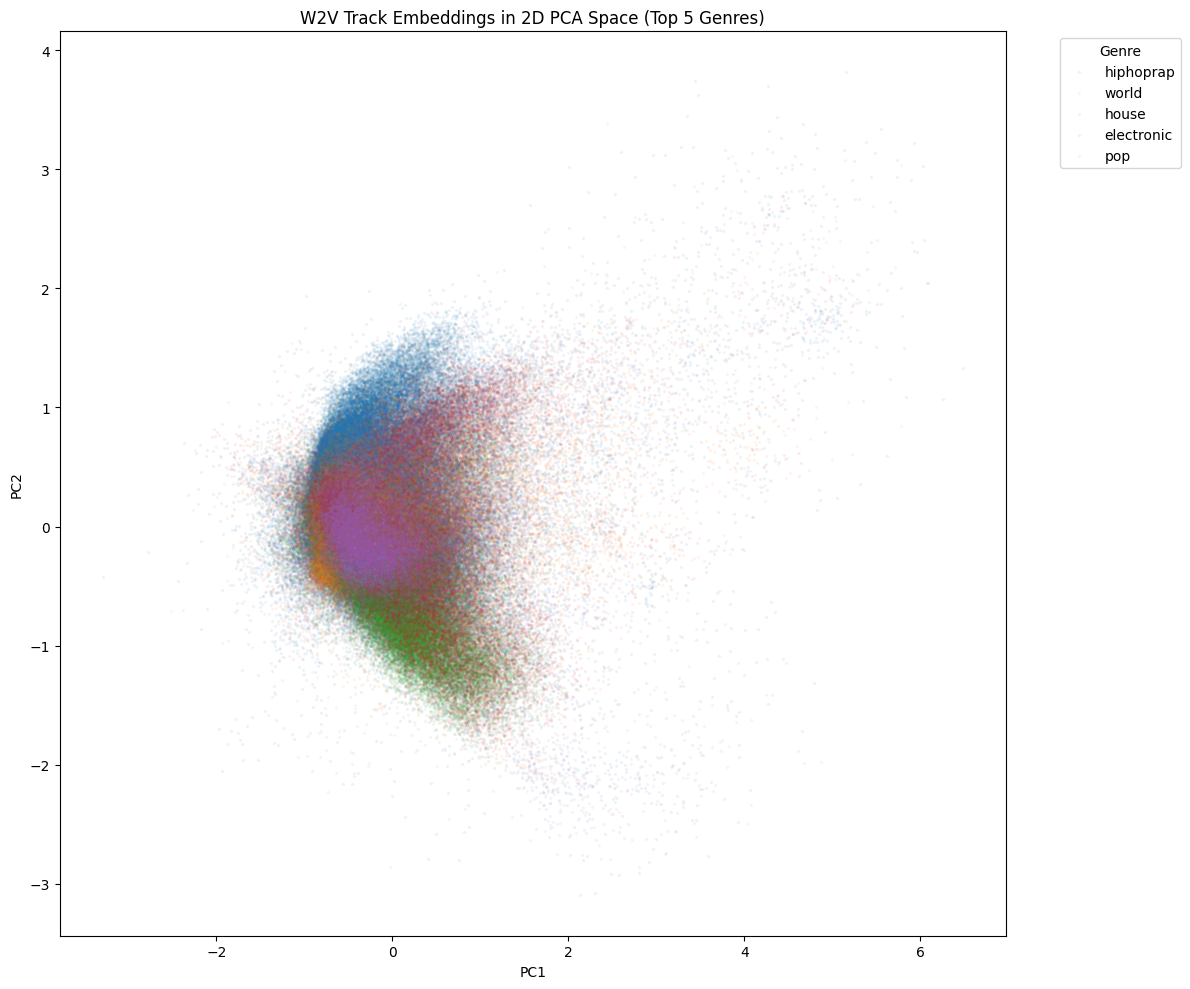

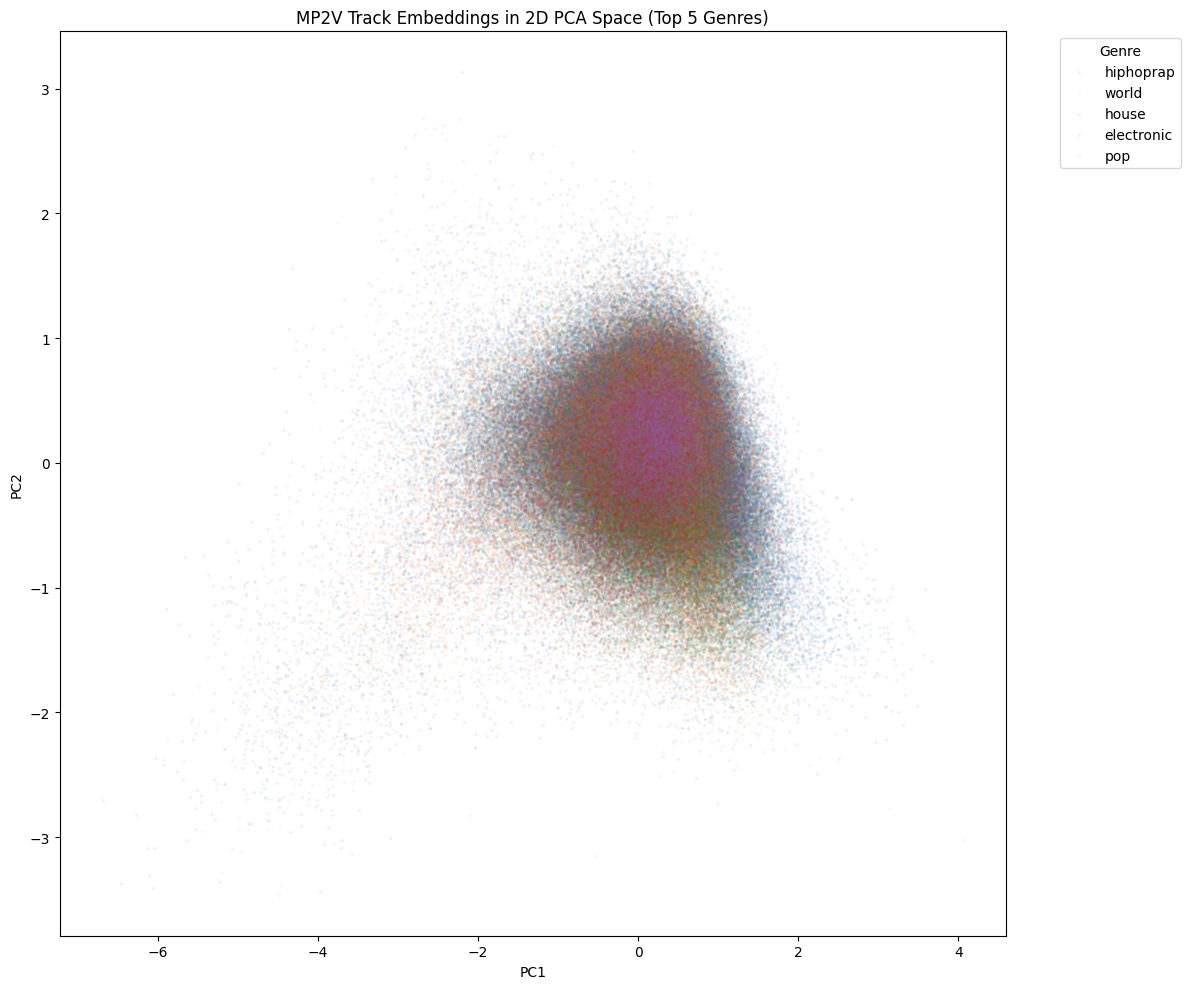

Number of tracks with 'Unknown' genre in subsample: 7070 (1.41%)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Subsample for plotting (reduced to 25K tracks for clarity)
np.random.seed(42)  # For reproducibility
subsample_size = 500000  # Reduced from 50K
subsample_indices = np.random.choice(w2v_track_emb.shape[0], subsample_size, replace=False)

w2v_subsample = w2v_track_emb[subsample_indices]
mp2v_subsample = mp2v_track_emb[subsample_indices]

# PCA reduction to 2D
pca = PCA(n_components=2)
w2v_2d = pca.fit_transform(w2v_subsample)
mp2v_2d = pca.fit_transform(mp2v_subsample)

# Map genres to subsample indices
genre_map = dict(zip(combined_df['track_idx'], combined_df['genre']))
genres = [genre_map.get(idx, 'Unknown') for idx in subsample_indices]

# Define color mapping for top 5 genres
top_genres = combined_df['genre'].value_counts().head(5).index.tolist()
colors = plt.cm.tab20(np.linspace(0, 1, 10))[:5]  # First 5 colors of tab20
genre_to_color = {genre: color for genre, color in zip(top_genres, colors)}

# Assign colors to each point (only top 5 genres, others excluded)
point_colors = [genre_to_color[g] if g in top_genres else 'none' for g in genres]

# Plot W2V
plt.figure(figsize=(12, 10))
for genre in top_genres:
    mask = np.array([g == genre for g in genres])
    plt.scatter(w2v_2d[mask, 0], w2v_2d[mask, 1], c=[genre_to_color[genre]], label=genre, s=2, alpha=0.05)
plt.title('W2V Track Embeddings in 2D PCA Space (Top 5 Genres)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('w2v_genre_pca.png')
plt.show()

# Plot MP2V
plt.figure(figsize=(12, 10))
for genre in top_genres:
    mask = np.array([g == genre for g in genres])
    plt.scatter(mp2v_2d[mask, 0], mp2v_2d[mask, 1], c=[genre_to_color[genre]], label=genre, s=2, alpha=0.05)
plt.title('MP2V Track Embeddings in 2D PCA Space (Top 5 Genres)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('mp2v_genre_pca.png')
plt.show()

# Summary stats
missing_count = sum(1 for g in genres if g == 'Unknown')
print(f"Number of tracks with 'Unknown' genre in subsample: {missing_count} ({missing_count/subsample_size*100:.2f}%)")

Running t-SNE for W2V...


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE for MP2V...


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


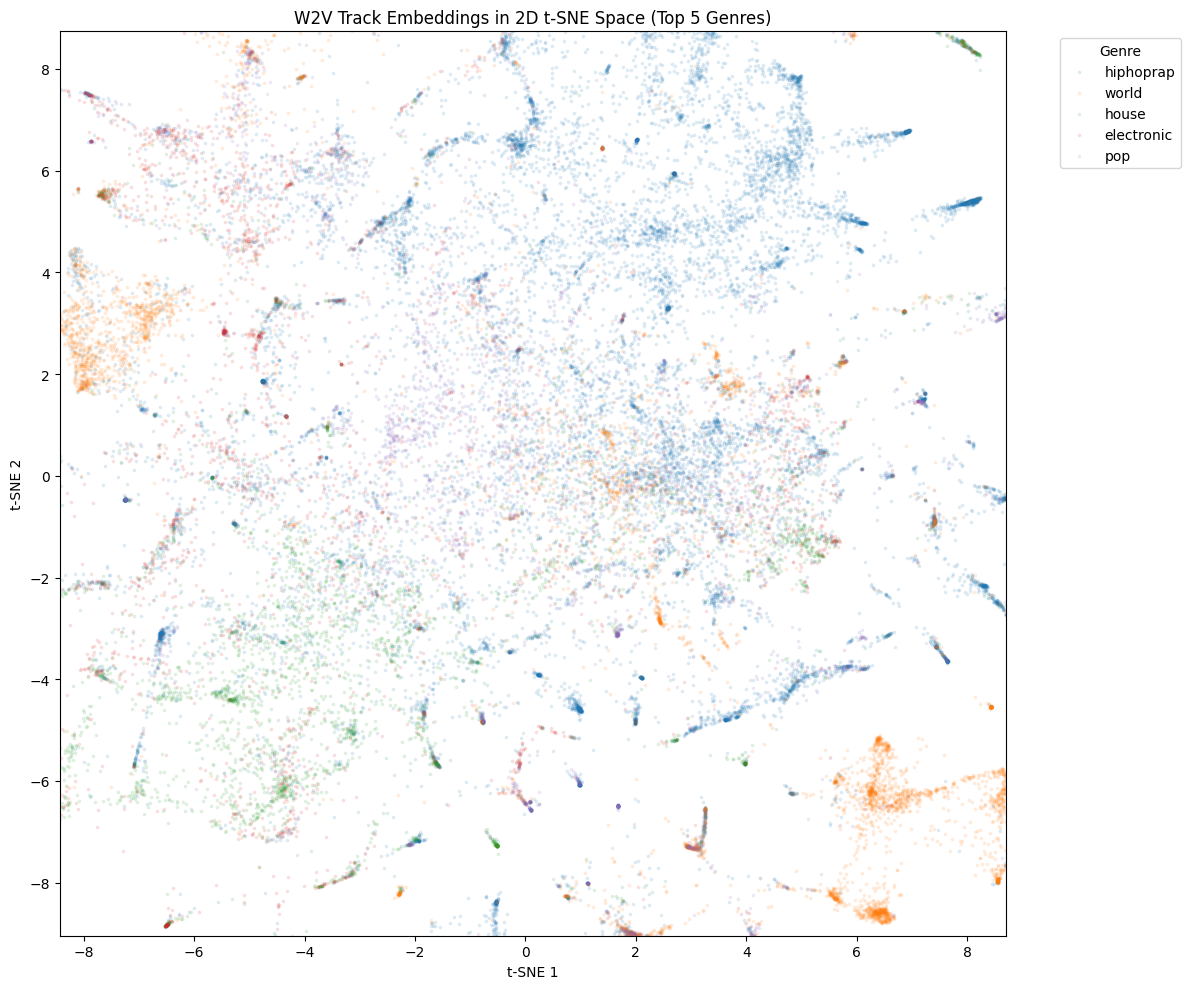

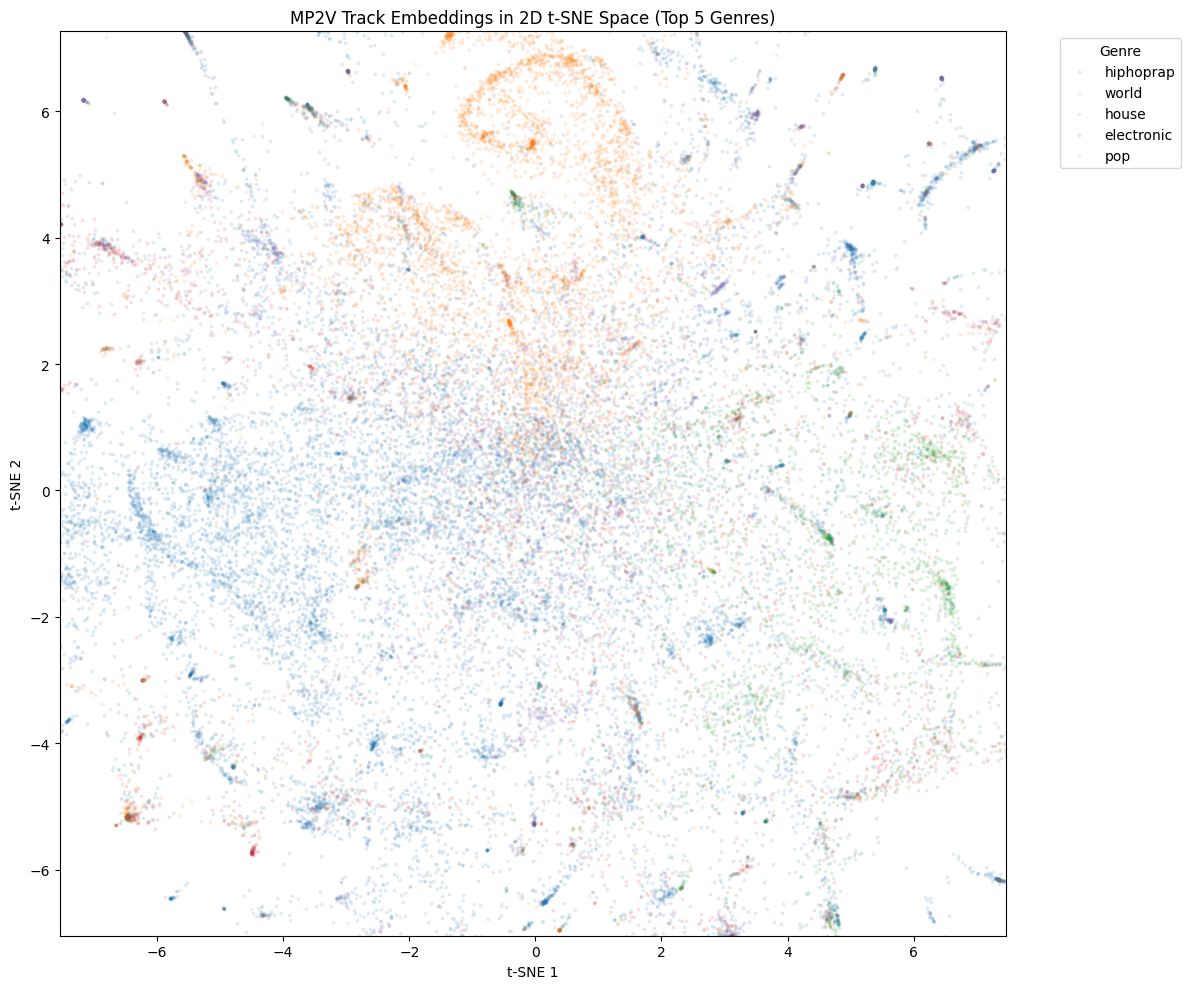

Number of tracks with 'Unknown' genre in subsample: 703 (1.41%)


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Subsample for plotting (50K tracks for t-SNE feasibility)
np.random.seed(42)  # For reproducibility
subsample_size = 50000
subsample_indices = np.random.choice(w2v_track_emb.shape[0], subsample_size, replace=False)

w2v_subsample = w2v_track_emb[subsample_indices]
mp2v_subsample = mp2v_track_emb[subsample_indices]

# t-SNE reduction to 2D
print("Running t-SNE for W2V...")
tsne = TSNE(n_components=2, random_state=42, perplexity=150, n_iter=300)
w2v_2d = tsne.fit_transform(w2v_subsample)

print("Running t-SNE for MP2V...")
mp2v_2d = tsne.fit_transform(mp2v_subsample)

# Map genres to subsample indices
genre_map = dict(zip(combined_df['track_idx'], combined_df['genre']))
genres = [genre_map.get(idx, 'Unknown') for idx in subsample_indices]

# Define color mapping for top 5 genres
top_genres = combined_df['genre'].value_counts().head(5).index.tolist()
colors = plt.cm.tab20(np.linspace(0, 1, 10))[:5]  # First 5 colors of tab20
genre_to_color = {genre: color for genre, color in zip(top_genres, colors)}

# Assign colors to each point (only top 5 genres, others excluded)
point_colors = [genre_to_color[g] if g in top_genres else 'none' for g in genres]

# Calculate percentile-based axis limits
def get_axis_limits(data_2d, percentile_low=5, percentile_high=95):
    x_min, x_max = np.percentile(data_2d[:, 0], [percentile_low, percentile_high])
    y_min, y_max = np.percentile(data_2d[:, 1], [percentile_low, percentile_high])
    return (x_min, x_max), (y_min, y_max)

w2v_x_limits, w2v_y_limits = get_axis_limits(w2v_2d)
mp2v_x_limits, mp2v_y_limits = get_axis_limits(mp2v_2d)

# Plot W2V
plt.figure(figsize=(12, 10))
for genre in top_genres:
    mask = np.array([g == genre for g in genres])
    plt.scatter(w2v_2d[mask, 0], w2v_2d[mask, 1], c=[genre_to_color[genre]], label=genre, s=3, alpha=0.1)
plt.title('W2V Track Embeddings in 2D t-SNE Space (Top 5 Genres)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.xlim(w2v_x_limits)
plt.ylim(w2v_y_limits)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('w2v_genre_tsne.png')
plt.show()

# Plot MP2V
plt.figure(figsize=(12, 10))
for genre in top_genres:
    mask = np.array([g == genre for g in genres])
    plt.scatter(mp2v_2d[mask, 0], mp2v_2d[mask, 1], c=[genre_to_color[genre]], label=genre, s=3, alpha=0.1)
plt.title('MP2V Track Embeddings in 2D t-SNE Space (Top 5 Genres)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.xlim(mp2v_x_limits)
plt.ylim(mp2v_y_limits)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('mp2v_genre_tsne.png')
plt.show()

# Summary stats
missing_count = sum(1 for g in genres if g == 'Unknown')
print(f"Number of tracks with 'Unknown' genre in subsample: {missing_count} ({missing_count/subsample_size*100:.2f}%)")